In [1]:
import torch
torch.__version__

'2.5.1+cu124'

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
device

'cuda:1'

In [3]:
import numpy as np
import pandas as pd
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
import random
import gc

In [4]:
# Set seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Data

In [5]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),     # Randomly rotate by 10 degrees
    transforms.RandomResizedCrop(
        size=IMG_SIZE,  # Output size
        scale=(0.8, 1.0)  # Range of the random crop size relative to the input size
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [7]:
data = pd.read_csv('../Data/fer2013_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33325 entries, 0 to 33324
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33325 non-null  object
 1   emotion  33325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.8+ KB


In [8]:
# pisahkan data train (80%), validation (10%), test (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26992
Validation set size: 3000
Test set size: 3333


In [9]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [10]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


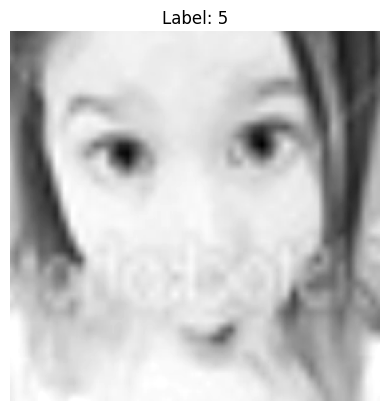

In [11]:
# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [12]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 224, 224])

## Build Vision Transformer (ViT) Model

In [13]:
from torch import nn

In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x

In [15]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [16]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [17]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [18]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, pixel_values, labels=None):
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])

        # Jika labels diberikan, hitung loss
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
    
        return (loss, logits) if loss is not None else logits

## Model Training

In [19]:
class BestModelSaver:
    def __init__(self, save_path, model_name):
        self.save_path = save_path
        self.model_name = model_name
        self.best_accuracy = -float('inf')
        os.makedirs(self.save_path, exist_ok=True)

    def save(self, model, current_accuracy, epoch):
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            model_path = os.path.join(self.save_path, f"{self.model_name}_best.pt")
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved at {model_path} with accuracy: {self.best_accuracy:.4f}")

In [20]:
class MetricsPlotter:
    def __init__(self, save_path, model_name):
        self.save_path = save_path
        self.model_name = model_name
        os.makedirs(self.save_path, exist_ok=True)

    def plot_and_save(self, train_metrics, val_metrics, metric_name, epoch):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_metrics) + 1), train_metrics, label=f"Training {metric_name}", marker='o')
        plt.plot(range(1, len(val_metrics) + 1), val_metrics, label=f"Validation {metric_name}", marker='o')
        plt.title(f"{self.model_name} {metric_name} per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)
        plot_path = os.path.join(self.save_path, f"{self.model_name}_{metric_name.lower()}.png")
        plt.savefig(plot_path)
        plt.close()

In [21]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1

        if self.epochs_no_improve >= self.patience:
            self.early_stop = True

        return self.early_stop

In [22]:
class Validator:
    def __init__(self, model, criterion, device):
        self.model = model
        self.criterion = criterion
        self.device = device

    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_targets = []
        all_predicted = []

        with torch.no_grad():  # Disable gradient computation
            pbar = tqdm(val_loader, desc="Validation")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                # Update statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

                # Collect all targets and predictions for F1-score
                all_targets.extend(targets.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{val_correct / val_total:.4f}"
                })

        # Calculate validation accuracy, loss, and F1-score
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_targets, all_predicted, average="weighted")

        return avg_val_loss, val_accuracy, val_f1

In [23]:
patch_sizes = [32]
num_heads = [8]
embedding_dims = [256, 384, 512, 768]
num_transformer_layers = [6, 12]

EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [24]:
# Define the CSV file paths
config_csv_path = "../Experiment Augment Result/augment_model_configurations2.csv"
epoch_csv_path = "../Experiment Augment Result/augment_epoch_results2.csv"
test_csv_path = "../Experiment Augment Result/augment_test_results2.csv"

# Check if the configuration CSV file exists. If not, create it and write the header.
if not os.path.exists(config_csv_path):
    with open(config_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Config", "Patch Size", "Num Heads", "Embedding Dim", "Num Transformer Layers"])

# Check if the epoch results CSV file exists. If not, create it and write the header.
if not os.path.exists(epoch_csv_path):
    with open(epoch_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Config", "Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc", "F1 Score", "Learning Rate"])
        
# Check if the epoch results CSV file exists. If not, create it and write the header.
if not os.path.exists(test_csv_path):
    with open(test_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Config", "Test Loss", "Test Acc", "F1 Score"])

In [25]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

# Open the configuration CSV file in append mode
with open(config_csv_path, mode='a', newline='') as config_file, \
     open(epoch_csv_path, mode='a', newline='') as epoch_file, \
     open(test_csv_path, mode='a', newline='') as test_file:
    
    config_writer = csv.writer(config_file)
    epoch_writer = csv.writer(epoch_file)
    test_writer = csv.writer(test_file)

    idx = 9

    for patch_size in patch_sizes:
        for num_head in num_heads:
            for embedding_dim in embedding_dims:
                for num_transformer_layer in num_transformer_layers:
                    print(f"Start model{idx} with configuration patch size: {patch_size}, num_heads: {num_head}, embedding_dims: {embedding_dim}, num_layers: {num_transformer_layer}")
                        
                    # Model initialization
                    model = ViT(num_classes=len(class_names), 
                                in_channels=1, 
                                patch_size=patch_size, 
                                num_heads=num_head, 
                                embedding_dim=embedding_dim, 
                                num_transformer_layers=num_transformer_layer)

                    model = model.to(DEVICE)

                    # Initialize BestModelSaver and MetricsPlotter
                    model_saver = BestModelSaver(save_path="../Experiment Augment Result", model_name=f"model{idx}_augment")
                    metrics_plotter = MetricsPlotter(save_path="../Experiment Augment Result", model_name=f"model{idx}_augment")

                    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
                    criterion = nn.CrossEntropyLoss()

                    # Define the learning rate scheduler
                    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
                    early_stopping = EarlyStopping(patience=15, min_delta=0)

                    # Initialize Validator
                    validator = Validator(model=model, criterion=criterion, device=DEVICE)

                    # Initialize lists to store training and validation metrics
                    train_losses = []
                    val_losses = []
                    train_accuracies = []
                    val_accuracies = []

                    for epoch in range(EPOCHS):
                        model.train()
                        train_loss = 0.0
                        correct = 0
                        total = 0

                        # Training
                        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
                        for batch_idx, (inputs, targets) in enumerate(pbar):
                            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                            # Zero the gradients
                            optimizer.zero_grad()

                            # Forward pass
                            outputs = model(inputs)
                            loss = criterion(outputs, targets)

                            # Backward pass and optimize
                            loss.backward()
                            optimizer.step()

                            # Update statistics
                            train_loss += loss.item()
                            _, predicted = outputs.max(1)
                            total += targets.size(0)
                            correct += predicted.eq(targets).sum().item()

                            # Update progress bar
                            pbar.set_postfix({
                                "Loss": f"{train_loss / (batch_idx + 1):.4f}",
                                "Acc": f"{correct / total:.4f}"
                            })

                        # Calculate training accuracy and loss
                        train_accuracy = correct / total
                        avg_train_loss = train_loss / len(train_loader)
                        train_losses.append(avg_train_loss)
                        train_accuracies.append(train_accuracy)

                        # Print training summary
                        print(f"Epoch {epoch + 1}/{EPOCHS}: "
                              f"Train Loss: {avg_train_loss:.4f}, "
                              f"Train Acc: {train_accuracy:.4f}")

                        # ===== VALIDATION =======
                        avg_val_loss, val_accuracy, val_f1 = validator.validate(val_loader)
                        val_losses.append(avg_val_loss)
                        val_accuracies.append(val_accuracy)

                        # Print validation summary
                        print(f"Epoch {epoch + 1}/{EPOCHS}: "
                              f"Val Loss: {avg_val_loss:.4f}, "
                              f"Val Acc: {val_accuracy:.4f}, "
                              f"Val F1: {val_f1:.4f}")

                        # Step the learning rate scheduler based on validation loss
                        scheduler.step(avg_val_loss)

                        # Print the current learning rate
                        current_lr = optimizer.param_groups[0]['lr']
                        print(f"Current Learning Rate: {current_lr}")

                        # Save the best model based on validation accuracy
                        model_saver.save(model, val_accuracy, epoch)

                        # Save loss and accuracy plots
                        metrics_plotter.plot_and_save(train_losses, val_losses, "Loss", epoch)
                        metrics_plotter.plot_and_save(train_accuracies, val_accuracies, "Accuracy", epoch)
                        
                        # Save epoch results to CSV
                        epoch_writer.writerow([
                            idx,  # Config
                            epoch + 1,  # Epoch
                            avg_train_loss,  # Train Loss
                            train_accuracy,  # Train Acc
                            avg_val_loss,  # Val Loss
                            val_accuracy,  # Val Acc
                            val_f1,  # F1 Score
                            current_lr  # Learning Rate
                        ])

                        # Early stopping check
                        if early_stopping(avg_val_loss):
                            print(f"Early stopping triggered at epoch {epoch + 1}!")
                            break

                    # Clear GPU memory after each configuration
                    del model, optimizer, scheduler
                    torch.cuda.empty_cache()
                    gc.collect()

                    # ======= TESTING ========
                    best_model = ViT(num_classes=len(class_names), 
                                    in_channels=1, 
                                    patch_size=patch_size, 
                                    num_heads=num_head, 
                                    embedding_dim=embedding_dim, 
                                    num_transformer_layers=num_transformer_layer)
                    best_model.to(DEVICE)
                    best_model.load_state_dict(torch.load(f"../Experiment Augment Result/model{idx}_augment_best.pt", weights_only=False))

                    best_model.eval()
                    test_loss = 0.0
                    test_correct = 0
                    test_total = 0
                    all_test_targets = []
                    all_test_predicted = []

                    with torch.no_grad():  # Disable gradient computation
                        pbar = tqdm(test_loader, desc="Testing")
                        for batch_idx, (inputs, targets) in enumerate(pbar):
                            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                            # Forward pass
                            outputs = best_model(inputs)
                            loss = criterion(outputs, targets)

                            # Update statistics
                            test_loss += loss.item()
                            _, predicted = outputs.max(1)
                            test_total += targets.size(0)
                            test_correct += predicted.eq(targets).sum().item()

                            # Collect all targets and predictions
                            all_test_targets.extend(targets.cpu().numpy())
                            all_test_predicted.extend(predicted.cpu().numpy())

                            # Update progress bar
                            pbar.set_postfix({
                                "Loss": f"{test_loss / (batch_idx + 1):.4f}",
                                "Acc": f"{test_correct / test_total:.4f}"
                            })

                    # Calculate test accuracy, loss, and F1-score
                    test_accuracy = test_correct / test_total
                    avg_test_loss = test_loss / len(test_loader)
                    test_f1 = f1_score(all_test_targets, all_test_predicted, average="weighted")

                    # Print test summary
                    print(f"Test Loss: {avg_test_loss:.4f}, "
                          f"Test Acc: {test_accuracy:.4f}, "
                          f"Test F1: {test_f1:.4f}")

                    # Clear GPU memory after each configuration
                    del best_model
                    torch.cuda.empty_cache()
                    gc.collect()
                    
                    # Save the configuration to the CSV file
                    test_writer.writerow([idx, avg_test_loss, test_accuracy, test_f1])
                    config_writer.writerow([idx, patch_size, num_head, embedding_dim, num_transformer_layer])

                    idx+=1

Start model9 with configuration patch size: 32, num_heads: 8, embedding_dims: 256, num_layers: 6


Epoch 1/1000: 100%|██████████| 422/422 [00:34<00:00, 12.12it/s, Loss=1.7742, Acc=0.2622]


Epoch 1/1000: Train Loss: 1.7742, Train Acc: 0.2622


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.63it/s, Loss=1.7677, Acc=0.2740]


Epoch 1/1000: Val Loss: 1.7677, Val Acc: 0.2740, Val F1: 0.2382
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.2740


Epoch 2/1000: 100%|██████████| 422/422 [00:34<00:00, 12.07it/s, Loss=1.7079, Acc=0.3094]


Epoch 2/1000: Train Loss: 1.7079, Train Acc: 0.3094


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.70it/s, Loss=1.7039, Acc=0.3153]


Epoch 2/1000: Val Loss: 1.7039, Val Acc: 0.3153, Val F1: 0.2320
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.3153


Epoch 3/1000: 100%|██████████| 422/422 [00:34<00:00, 12.40it/s, Loss=1.6683, Acc=0.3352]


Epoch 3/1000: Train Loss: 1.6683, Train Acc: 0.3352


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.73it/s, Loss=1.6364, Acc=0.3530]


Epoch 3/1000: Val Loss: 1.6364, Val Acc: 0.3530, Val F1: 0.2872
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.3530


Epoch 4/1000: 100%|██████████| 422/422 [00:34<00:00, 12.35it/s, Loss=1.6302, Acc=0.3571]


Epoch 4/1000: Train Loss: 1.6302, Train Acc: 0.3571


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.48it/s, Loss=1.6038, Acc=0.3733]


Epoch 4/1000: Val Loss: 1.6038, Val Acc: 0.3733, Val F1: 0.3154
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.3733


Epoch 5/1000: 100%|██████████| 422/422 [00:34<00:00, 12.24it/s, Loss=1.6064, Acc=0.3688]


Epoch 5/1000: Train Loss: 1.6064, Train Acc: 0.3688


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.04it/s, Loss=1.5852, Acc=0.3790]


Epoch 5/1000: Val Loss: 1.5852, Val Acc: 0.3790, Val F1: 0.3223
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.3790


Epoch 6/1000: 100%|██████████| 422/422 [00:34<00:00, 12.30it/s, Loss=1.5879, Acc=0.3795]


Epoch 6/1000: Train Loss: 1.5879, Train Acc: 0.3795


Validation: 100%|██████████| 47/47 [00:01<00:00, 29.42it/s, Loss=1.5702, Acc=0.3917]


Epoch 6/1000: Val Loss: 1.5702, Val Acc: 0.3917, Val F1: 0.3476
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.3917


Epoch 7/1000: 100%|██████████| 422/422 [00:35<00:00, 11.93it/s, Loss=1.5670, Acc=0.3883]


Epoch 7/1000: Train Loss: 1.5670, Train Acc: 0.3883


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.71it/s, Loss=1.5425, Acc=0.3960]


Epoch 7/1000: Val Loss: 1.5425, Val Acc: 0.3960, Val F1: 0.3712
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.3960


Epoch 8/1000: 100%|██████████| 422/422 [00:34<00:00, 12.40it/s, Loss=1.5587, Acc=0.3909]


Epoch 8/1000: Train Loss: 1.5587, Train Acc: 0.3909


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.74it/s, Loss=1.5264, Acc=0.4053]


Epoch 8/1000: Val Loss: 1.5264, Val Acc: 0.4053, Val F1: 0.3876
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4053


Epoch 9/1000: 100%|██████████| 422/422 [00:34<00:00, 12.38it/s, Loss=1.5406, Acc=0.3971]


Epoch 9/1000: Train Loss: 1.5406, Train Acc: 0.3971


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.66it/s, Loss=1.5337, Acc=0.3987]


Epoch 9/1000: Val Loss: 1.5337, Val Acc: 0.3987, Val F1: 0.3414
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|██████████| 422/422 [00:34<00:00, 12.37it/s, Loss=1.5241, Acc=0.4059]


Epoch 10/1000: Train Loss: 1.5241, Train Acc: 0.4059


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.59it/s, Loss=1.5016, Acc=0.4137]


Epoch 10/1000: Val Loss: 1.5016, Val Acc: 0.4137, Val F1: 0.3663
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4137


Epoch 11/1000: 100%|██████████| 422/422 [00:34<00:00, 12.41it/s, Loss=1.5087, Acc=0.4090]


Epoch 11/1000: Train Loss: 1.5087, Train Acc: 0.4090


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.68it/s, Loss=1.5080, Acc=0.4013]


Epoch 11/1000: Val Loss: 1.5080, Val Acc: 0.4013, Val F1: 0.3887
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|██████████| 422/422 [00:34<00:00, 12.35it/s, Loss=1.5064, Acc=0.4109]


Epoch 12/1000: Train Loss: 1.5064, Train Acc: 0.4109


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.68it/s, Loss=1.4854, Acc=0.4217]


Epoch 12/1000: Val Loss: 1.4854, Val Acc: 0.4217, Val F1: 0.3773
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4217


Epoch 13/1000: 100%|██████████| 422/422 [00:34<00:00, 12.41it/s, Loss=1.4888, Acc=0.4181]


Epoch 13/1000: Train Loss: 1.4888, Train Acc: 0.4181


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.53it/s, Loss=1.4615, Acc=0.4377]


Epoch 13/1000: Val Loss: 1.4615, Val Acc: 0.4377, Val F1: 0.4197
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4377


Epoch 14/1000: 100%|██████████| 422/422 [00:34<00:00, 12.37it/s, Loss=1.4740, Acc=0.4235]


Epoch 14/1000: Train Loss: 1.4740, Train Acc: 0.4235


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.38it/s, Loss=1.4826, Acc=0.4223]


Epoch 14/1000: Val Loss: 1.4826, Val Acc: 0.4223, Val F1: 0.3786
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|██████████| 422/422 [00:34<00:00, 12.40it/s, Loss=1.4655, Acc=0.4283]


Epoch 15/1000: Train Loss: 1.4655, Train Acc: 0.4283


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.14it/s, Loss=1.4734, Acc=0.4217]


Epoch 15/1000: Val Loss: 1.4734, Val Acc: 0.4217, Val F1: 0.4195
Current Learning Rate: 3e-05


Epoch 16/1000: 100%|██████████| 422/422 [00:34<00:00, 12.27it/s, Loss=1.4515, Acc=0.4362]


Epoch 16/1000: Train Loss: 1.4515, Train Acc: 0.4362


Validation: 100%|██████████| 47/47 [00:01<00:00, 32.96it/s, Loss=1.4519, Acc=0.4387]


Epoch 16/1000: Val Loss: 1.4519, Val Acc: 0.4387, Val F1: 0.4258
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4387


Epoch 17/1000: 100%|██████████| 422/422 [00:33<00:00, 12.69it/s, Loss=1.4398, Acc=0.4416]


Epoch 17/1000: Train Loss: 1.4398, Train Acc: 0.4416


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.81it/s, Loss=1.4253, Acc=0.4450]


Epoch 17/1000: Val Loss: 1.4253, Val Acc: 0.4450, Val F1: 0.4293
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4450


Epoch 18/1000: 100%|██████████| 422/422 [00:34<00:00, 12.36it/s, Loss=1.4288, Acc=0.4478]


Epoch 18/1000: Train Loss: 1.4288, Train Acc: 0.4478


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.66it/s, Loss=1.4383, Acc=0.4390]


Epoch 18/1000: Val Loss: 1.4383, Val Acc: 0.4390, Val F1: 0.4309
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|██████████| 422/422 [00:34<00:00, 12.39it/s, Loss=1.4156, Acc=0.4505]


Epoch 19/1000: Train Loss: 1.4156, Train Acc: 0.4505


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.35it/s, Loss=1.4096, Acc=0.4507]


Epoch 19/1000: Val Loss: 1.4096, Val Acc: 0.4507, Val F1: 0.4218
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4507


Epoch 20/1000: 100%|██████████| 422/422 [00:35<00:00, 11.92it/s, Loss=1.4050, Acc=0.4549]


Epoch 20/1000: Train Loss: 1.4050, Train Acc: 0.4549


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.53it/s, Loss=1.4131, Acc=0.4543]


Epoch 20/1000: Val Loss: 1.4131, Val Acc: 0.4543, Val F1: 0.4256
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4543


Epoch 21/1000: 100%|██████████| 422/422 [00:34<00:00, 12.32it/s, Loss=1.4011, Acc=0.4558]


Epoch 21/1000: Train Loss: 1.4011, Train Acc: 0.4558


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.76it/s, Loss=1.3932, Acc=0.4580]


Epoch 21/1000: Val Loss: 1.3932, Val Acc: 0.4580, Val F1: 0.4501
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4580


Epoch 22/1000: 100%|██████████| 422/422 [00:34<00:00, 12.15it/s, Loss=1.3900, Acc=0.4604]


Epoch 22/1000: Train Loss: 1.3900, Train Acc: 0.4604


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.69it/s, Loss=1.3930, Acc=0.4650]


Epoch 22/1000: Val Loss: 1.3930, Val Acc: 0.4650, Val F1: 0.4414
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4650


Epoch 23/1000: 100%|██████████| 422/422 [00:34<00:00, 12.31it/s, Loss=1.3792, Acc=0.4662]


Epoch 23/1000: Train Loss: 1.3792, Train Acc: 0.4662


Validation: 100%|██████████| 47/47 [00:01<00:00, 30.94it/s, Loss=1.3787, Acc=0.4610]


Epoch 23/1000: Val Loss: 1.3787, Val Acc: 0.4610, Val F1: 0.4353
Current Learning Rate: 3e-05


Epoch 24/1000: 100%|██████████| 422/422 [00:35<00:00, 11.82it/s, Loss=1.3687, Acc=0.4715]


Epoch 24/1000: Train Loss: 1.3687, Train Acc: 0.4715


Validation: 100%|██████████| 47/47 [00:01<00:00, 29.68it/s, Loss=1.3802, Acc=0.4713]


Epoch 24/1000: Val Loss: 1.3802, Val Acc: 0.4713, Val F1: 0.4663
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4713


Epoch 25/1000: 100%|██████████| 422/422 [00:34<00:00, 12.31it/s, Loss=1.3653, Acc=0.4706]


Epoch 25/1000: Train Loss: 1.3653, Train Acc: 0.4706


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.69it/s, Loss=1.3651, Acc=0.4787]


Epoch 25/1000: Val Loss: 1.3651, Val Acc: 0.4787, Val F1: 0.4658
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4787


Epoch 26/1000: 100%|██████████| 422/422 [00:35<00:00, 11.92it/s, Loss=1.3543, Acc=0.4760]


Epoch 26/1000: Train Loss: 1.3543, Train Acc: 0.4760


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.69it/s, Loss=1.3633, Acc=0.4733]


Epoch 26/1000: Val Loss: 1.3633, Val Acc: 0.4733, Val F1: 0.4554
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [00:34<00:00, 12.31it/s, Loss=1.3462, Acc=0.4786]


Epoch 27/1000: Train Loss: 1.3462, Train Acc: 0.4786


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.65it/s, Loss=1.3472, Acc=0.4800]


Epoch 27/1000: Val Loss: 1.3472, Val Acc: 0.4800, Val F1: 0.4673
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4800


Epoch 28/1000: 100%|██████████| 422/422 [00:34<00:00, 12.41it/s, Loss=1.3318, Acc=0.4816]


Epoch 28/1000: Train Loss: 1.3318, Train Acc: 0.4816


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.63it/s, Loss=1.3538, Acc=0.4773]


Epoch 28/1000: Val Loss: 1.3538, Val Acc: 0.4773, Val F1: 0.4566
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [00:33<00:00, 12.60it/s, Loss=1.3246, Acc=0.4887]


Epoch 29/1000: Train Loss: 1.3246, Train Acc: 0.4887


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.70it/s, Loss=1.3483, Acc=0.4783]


Epoch 29/1000: Val Loss: 1.3483, Val Acc: 0.4783, Val F1: 0.4653
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [00:33<00:00, 12.75it/s, Loss=1.3178, Acc=0.4881]


Epoch 30/1000: Train Loss: 1.3178, Train Acc: 0.4881


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.68it/s, Loss=1.3372, Acc=0.4847]


Epoch 30/1000: Val Loss: 1.3372, Val Acc: 0.4847, Val F1: 0.4621
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4847


Epoch 31/1000: 100%|██████████| 422/422 [00:34<00:00, 12.07it/s, Loss=1.3086, Acc=0.4924]


Epoch 31/1000: Train Loss: 1.3086, Train Acc: 0.4924


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.87it/s, Loss=1.3354, Acc=0.4947]


Epoch 31/1000: Val Loss: 1.3354, Val Acc: 0.4947, Val F1: 0.4770
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4947


Epoch 32/1000: 100%|██████████| 422/422 [00:34<00:00, 12.33it/s, Loss=1.3031, Acc=0.4969]


Epoch 32/1000: Train Loss: 1.3031, Train Acc: 0.4969


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.91it/s, Loss=1.3268, Acc=0.4900]


Epoch 32/1000: Val Loss: 1.3268, Val Acc: 0.4900, Val F1: 0.4852
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [00:33<00:00, 12.70it/s, Loss=1.2959, Acc=0.5017]


Epoch 33/1000: Train Loss: 1.2959, Train Acc: 0.5017


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.86it/s, Loss=1.3317, Acc=0.4917]


Epoch 33/1000: Val Loss: 1.3317, Val Acc: 0.4917, Val F1: 0.4793
Current Learning Rate: 3e-05


Epoch 34/1000: 100%|██████████| 422/422 [00:33<00:00, 12.43it/s, Loss=1.2916, Acc=0.5028]


Epoch 34/1000: Train Loss: 1.2916, Train Acc: 0.5028


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.84it/s, Loss=1.3604, Acc=0.4723]


Epoch 34/1000: Val Loss: 1.3604, Val Acc: 0.4723, Val F1: 0.4758
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [00:34<00:00, 12.29it/s, Loss=1.2844, Acc=0.5063]


Epoch 35/1000: Train Loss: 1.2844, Train Acc: 0.5063


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.84it/s, Loss=1.3185, Acc=0.4983]


Epoch 35/1000: Val Loss: 1.3185, Val Acc: 0.4983, Val F1: 0.4849
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.4983


Epoch 36/1000: 100%|██████████| 422/422 [00:33<00:00, 12.59it/s, Loss=1.2743, Acc=0.5096]


Epoch 36/1000: Train Loss: 1.2743, Train Acc: 0.5096


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.55it/s, Loss=1.3238, Acc=0.4883]


Epoch 36/1000: Val Loss: 1.3238, Val Acc: 0.4883, Val F1: 0.4705
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [00:33<00:00, 12.64it/s, Loss=1.2728, Acc=0.5092]


Epoch 37/1000: Train Loss: 1.2728, Train Acc: 0.5092


Validation: 100%|██████████| 47/47 [00:01<00:00, 32.43it/s, Loss=1.3113, Acc=0.4967]


Epoch 37/1000: Val Loss: 1.3113, Val Acc: 0.4967, Val F1: 0.4799
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [00:34<00:00, 12.34it/s, Loss=1.2622, Acc=0.5161]


Epoch 38/1000: Train Loss: 1.2622, Train Acc: 0.5161


Validation: 100%|██████████| 47/47 [00:01<00:00, 30.16it/s, Loss=1.3067, Acc=0.4923]


Epoch 38/1000: Val Loss: 1.3067, Val Acc: 0.4923, Val F1: 0.4746
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [00:34<00:00, 12.10it/s, Loss=1.2519, Acc=0.5170]


Epoch 39/1000: Train Loss: 1.2519, Train Acc: 0.5170


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.61it/s, Loss=1.2984, Acc=0.5043]


Epoch 39/1000: Val Loss: 1.2984, Val Acc: 0.5043, Val F1: 0.4958
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5043


Epoch 40/1000: 100%|██████████| 422/422 [00:34<00:00, 12.35it/s, Loss=1.2488, Acc=0.5219]


Epoch 40/1000: Train Loss: 1.2488, Train Acc: 0.5219


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.40it/s, Loss=1.3120, Acc=0.5063]


Epoch 40/1000: Val Loss: 1.3120, Val Acc: 0.5063, Val F1: 0.4907
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5063


Epoch 41/1000: 100%|██████████| 422/422 [00:34<00:00, 12.36it/s, Loss=1.2466, Acc=0.5217]


Epoch 41/1000: Train Loss: 1.2466, Train Acc: 0.5217


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.74it/s, Loss=1.3124, Acc=0.5000]


Epoch 41/1000: Val Loss: 1.3124, Val Acc: 0.5000, Val F1: 0.4985
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [00:34<00:00, 12.33it/s, Loss=1.2387, Acc=0.5237]


Epoch 42/1000: Train Loss: 1.2387, Train Acc: 0.5237


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.74it/s, Loss=1.2929, Acc=0.5057]


Epoch 42/1000: Val Loss: 1.2929, Val Acc: 0.5057, Val F1: 0.5039
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|██████████| 422/422 [00:34<00:00, 12.34it/s, Loss=1.2255, Acc=0.5311]


Epoch 43/1000: Train Loss: 1.2255, Train Acc: 0.5311


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.52it/s, Loss=1.2912, Acc=0.4990]


Epoch 43/1000: Val Loss: 1.2912, Val Acc: 0.4990, Val F1: 0.4888
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [00:35<00:00, 11.85it/s, Loss=1.2170, Acc=0.5322]


Epoch 44/1000: Train Loss: 1.2170, Train Acc: 0.5322


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.64it/s, Loss=1.2928, Acc=0.5130]


Epoch 44/1000: Val Loss: 1.2928, Val Acc: 0.5130, Val F1: 0.5039
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5130


Epoch 45/1000: 100%|██████████| 422/422 [00:33<00:00, 12.42it/s, Loss=1.2167, Acc=0.5316]


Epoch 45/1000: Train Loss: 1.2167, Train Acc: 0.5316


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.38it/s, Loss=1.2835, Acc=0.5097]


Epoch 45/1000: Val Loss: 1.2835, Val Acc: 0.5097, Val F1: 0.5012
Current Learning Rate: 3e-05


Epoch 46/1000: 100%|██████████| 422/422 [00:35<00:00, 11.90it/s, Loss=1.2070, Acc=0.5383]


Epoch 46/1000: Train Loss: 1.2070, Train Acc: 0.5383


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.38it/s, Loss=1.2935, Acc=0.5070]


Epoch 46/1000: Val Loss: 1.2935, Val Acc: 0.5070, Val F1: 0.4975
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [00:33<00:00, 12.53it/s, Loss=1.2000, Acc=0.5440]


Epoch 47/1000: Train Loss: 1.2000, Train Acc: 0.5440


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.62it/s, Loss=1.3041, Acc=0.5090]


Epoch 47/1000: Val Loss: 1.3041, Val Acc: 0.5090, Val F1: 0.4942
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [00:34<00:00, 12.19it/s, Loss=1.1902, Acc=0.5478]


Epoch 48/1000: Train Loss: 1.1902, Train Acc: 0.5478


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.69it/s, Loss=1.2831, Acc=0.5153]


Epoch 48/1000: Val Loss: 1.2831, Val Acc: 0.5153, Val F1: 0.4956
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5153


Epoch 49/1000: 100%|██████████| 422/422 [00:35<00:00, 12.00it/s, Loss=1.1829, Acc=0.5479]


Epoch 49/1000: Train Loss: 1.1829, Train Acc: 0.5479


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.69it/s, Loss=1.2850, Acc=0.5140]


Epoch 49/1000: Val Loss: 1.2850, Val Acc: 0.5140, Val F1: 0.5117
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [00:34<00:00, 12.23it/s, Loss=1.1755, Acc=0.5499]


Epoch 50/1000: Train Loss: 1.1755, Train Acc: 0.5499


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.67it/s, Loss=1.2737, Acc=0.5143]


Epoch 50/1000: Val Loss: 1.2737, Val Acc: 0.5143, Val F1: 0.5110
Current Learning Rate: 3e-05


Epoch 51/1000: 100%|██████████| 422/422 [00:34<00:00, 12.37it/s, Loss=1.1711, Acc=0.5531]


Epoch 51/1000: Train Loss: 1.1711, Train Acc: 0.5531


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.52it/s, Loss=1.2723, Acc=0.5170]


Epoch 51/1000: Val Loss: 1.2723, Val Acc: 0.5170, Val F1: 0.5107
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5170


Epoch 52/1000: 100%|██████████| 422/422 [00:34<00:00, 12.22it/s, Loss=1.1623, Acc=0.5568]


Epoch 52/1000: Train Loss: 1.1623, Train Acc: 0.5568


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.66it/s, Loss=1.2953, Acc=0.5080]


Epoch 52/1000: Val Loss: 1.2953, Val Acc: 0.5080, Val F1: 0.5092
Current Learning Rate: 3e-05


Epoch 53/1000: 100%|██████████| 422/422 [00:35<00:00, 11.97it/s, Loss=1.1522, Acc=0.5610]


Epoch 53/1000: Train Loss: 1.1522, Train Acc: 0.5610


Validation: 100%|██████████| 47/47 [00:01<00:00, 32.08it/s, Loss=1.2827, Acc=0.5217]


Epoch 53/1000: Val Loss: 1.2827, Val Acc: 0.5217, Val F1: 0.5118
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5217


Epoch 54/1000: 100%|██████████| 422/422 [00:33<00:00, 12.58it/s, Loss=1.1493, Acc=0.5618]


Epoch 54/1000: Train Loss: 1.1493, Train Acc: 0.5618


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.48it/s, Loss=1.2607, Acc=0.5307]


Epoch 54/1000: Val Loss: 1.2607, Val Acc: 0.5307, Val F1: 0.5200
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5307


Epoch 55/1000: 100%|██████████| 422/422 [00:34<00:00, 12.38it/s, Loss=1.1427, Acc=0.5641]


Epoch 55/1000: Train Loss: 1.1427, Train Acc: 0.5641


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.70it/s, Loss=1.2658, Acc=0.5220]


Epoch 55/1000: Val Loss: 1.2658, Val Acc: 0.5220, Val F1: 0.5192
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [00:33<00:00, 12.67it/s, Loss=1.1381, Acc=0.5664]


Epoch 56/1000: Train Loss: 1.1381, Train Acc: 0.5664


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.08it/s, Loss=1.2714, Acc=0.5177]


Epoch 56/1000: Val Loss: 1.2714, Val Acc: 0.5177, Val F1: 0.5048
Current Learning Rate: 3e-05


Epoch 57/1000: 100%|██████████| 422/422 [00:33<00:00, 12.55it/s, Loss=1.1327, Acc=0.5677]


Epoch 57/1000: Train Loss: 1.1327, Train Acc: 0.5677


Validation: 100%|██████████| 47/47 [00:01<00:00, 32.41it/s, Loss=1.2725, Acc=0.5237]


Epoch 57/1000: Val Loss: 1.2725, Val Acc: 0.5237, Val F1: 0.5186
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [00:33<00:00, 12.68it/s, Loss=1.1231, Acc=0.5731]


Epoch 58/1000: Train Loss: 1.1231, Train Acc: 0.5731


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.93it/s, Loss=1.2635, Acc=0.5257]


Epoch 58/1000: Val Loss: 1.2635, Val Acc: 0.5257, Val F1: 0.5203
Current Learning Rate: 3e-05


Epoch 59/1000: 100%|██████████| 422/422 [00:32<00:00, 12.80it/s, Loss=1.1202, Acc=0.5724]


Epoch 59/1000: Train Loss: 1.1202, Train Acc: 0.5724


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.83it/s, Loss=1.2815, Acc=0.5123]


Epoch 59/1000: Val Loss: 1.2815, Val Acc: 0.5123, Val F1: 0.5092
Current Learning Rate: 3e-05


Epoch 60/1000: 100%|██████████| 422/422 [00:33<00:00, 12.44it/s, Loss=1.1058, Acc=0.5816]


Epoch 60/1000: Train Loss: 1.1058, Train Acc: 0.5816


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.69it/s, Loss=1.2712, Acc=0.5233]


Epoch 60/1000: Val Loss: 1.2712, Val Acc: 0.5233, Val F1: 0.5165
Current Learning Rate: 3e-06


Epoch 61/1000: 100%|██████████| 422/422 [00:33<00:00, 12.74it/s, Loss=1.0566, Acc=0.5990]


Epoch 61/1000: Train Loss: 1.0566, Train Acc: 0.5990


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.87it/s, Loss=1.2436, Acc=0.5300]


Epoch 61/1000: Val Loss: 1.2436, Val Acc: 0.5300, Val F1: 0.5242
Current Learning Rate: 3e-06


Epoch 62/1000: 100%|██████████| 422/422 [00:33<00:00, 12.44it/s, Loss=1.0436, Acc=0.6068]


Epoch 62/1000: Train Loss: 1.0436, Train Acc: 0.6068


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.54it/s, Loss=1.2378, Acc=0.5313]


Epoch 62/1000: Val Loss: 1.2378, Val Acc: 0.5313, Val F1: 0.5274
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5313


Epoch 63/1000: 100%|██████████| 422/422 [00:33<00:00, 12.61it/s, Loss=1.0310, Acc=0.6117]


Epoch 63/1000: Train Loss: 1.0310, Train Acc: 0.6117


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.78it/s, Loss=1.2417, Acc=0.5333]


Epoch 63/1000: Val Loss: 1.2417, Val Acc: 0.5333, Val F1: 0.5258
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5333


Epoch 64/1000: 100%|██████████| 422/422 [00:33<00:00, 12.60it/s, Loss=1.0273, Acc=0.6129]


Epoch 64/1000: Train Loss: 1.0273, Train Acc: 0.6129


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.85it/s, Loss=1.2374, Acc=0.5313]


Epoch 64/1000: Val Loss: 1.2374, Val Acc: 0.5313, Val F1: 0.5256
Current Learning Rate: 3e-06


Epoch 65/1000: 100%|██████████| 422/422 [00:33<00:00, 12.41it/s, Loss=1.0179, Acc=0.6201]


Epoch 65/1000: Train Loss: 1.0179, Train Acc: 0.6201


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.93it/s, Loss=1.2366, Acc=0.5413]


Epoch 65/1000: Val Loss: 1.2366, Val Acc: 0.5413, Val F1: 0.5363
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5413


Epoch 66/1000: 100%|██████████| 422/422 [00:33<00:00, 12.72it/s, Loss=1.0199, Acc=0.6156]


Epoch 66/1000: Train Loss: 1.0199, Train Acc: 0.6156


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.85it/s, Loss=1.2405, Acc=0.5390]


Epoch 66/1000: Val Loss: 1.2405, Val Acc: 0.5390, Val F1: 0.5320
Current Learning Rate: 3e-06


Epoch 67/1000: 100%|██████████| 422/422 [00:34<00:00, 12.39it/s, Loss=1.0158, Acc=0.6197]


Epoch 67/1000: Train Loss: 1.0158, Train Acc: 0.6197


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.29it/s, Loss=1.2385, Acc=0.5380]


Epoch 67/1000: Val Loss: 1.2385, Val Acc: 0.5380, Val F1: 0.5317
Current Learning Rate: 3e-06


Epoch 68/1000: 100%|██████████| 422/422 [00:33<00:00, 12.66it/s, Loss=1.0074, Acc=0.6213]


Epoch 68/1000: Train Loss: 1.0074, Train Acc: 0.6213


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.82it/s, Loss=1.2395, Acc=0.5373]


Epoch 68/1000: Val Loss: 1.2395, Val Acc: 0.5373, Val F1: 0.5327
Current Learning Rate: 3e-06


Epoch 69/1000: 100%|██████████| 422/422 [00:34<00:00, 12.15it/s, Loss=1.0084, Acc=0.6220]


Epoch 69/1000: Train Loss: 1.0084, Train Acc: 0.6220


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.66it/s, Loss=1.2450, Acc=0.5357]


Epoch 69/1000: Val Loss: 1.2450, Val Acc: 0.5357, Val F1: 0.5307
Current Learning Rate: 3e-06


Epoch 70/1000: 100%|██████████| 422/422 [00:33<00:00, 12.47it/s, Loss=1.0041, Acc=0.6178]


Epoch 70/1000: Train Loss: 1.0041, Train Acc: 0.6178


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.39it/s, Loss=1.2372, Acc=0.5427]


Epoch 70/1000: Val Loss: 1.2372, Val Acc: 0.5427, Val F1: 0.5389
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5427


Epoch 71/1000: 100%|██████████| 422/422 [00:34<00:00, 12.38it/s, Loss=1.0056, Acc=0.6237]


Epoch 71/1000: Train Loss: 1.0056, Train Acc: 0.6237


Validation: 100%|██████████| 47/47 [00:01<00:00, 32.86it/s, Loss=1.2372, Acc=0.5490]


Epoch 71/1000: Val Loss: 1.2372, Val Acc: 0.5490, Val F1: 0.5451
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5490


Epoch 72/1000: 100%|██████████| 422/422 [00:33<00:00, 12.61it/s, Loss=0.9976, Acc=0.6278]


Epoch 72/1000: Train Loss: 0.9976, Train Acc: 0.6278


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.92it/s, Loss=1.2360, Acc=0.5507]


Epoch 72/1000: Val Loss: 1.2360, Val Acc: 0.5507, Val F1: 0.5458
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Experiment Augment Result/model9_augment_best.pt with accuracy: 0.5507


Epoch 73/1000: 100%|██████████| 422/422 [00:33<00:00, 12.75it/s, Loss=0.9927, Acc=0.6291]


Epoch 73/1000: Train Loss: 0.9927, Train Acc: 0.6291


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.87it/s, Loss=1.2368, Acc=0.5470]


Epoch 73/1000: Val Loss: 1.2368, Val Acc: 0.5470, Val F1: 0.5419
Current Learning Rate: 3.0000000000000004e-07


Epoch 74/1000: 100%|██████████| 422/422 [00:33<00:00, 12.69it/s, Loss=0.9965, Acc=0.6236]


Epoch 74/1000: Train Loss: 0.9965, Train Acc: 0.6236


Validation: 100%|██████████| 47/47 [00:01<00:00, 33.46it/s, Loss=1.2362, Acc=0.5470]


Epoch 74/1000: Val Loss: 1.2362, Val Acc: 0.5470, Val F1: 0.5418
Current Learning Rate: 3.0000000000000004e-07


Epoch 75/1000: 100%|██████████| 422/422 [00:33<00:00, 12.61it/s, Loss=0.9938, Acc=0.6258]


Epoch 75/1000: Train Loss: 0.9938, Train Acc: 0.6258


Validation: 100%|██████████| 47/47 [00:01<00:00, 30.62it/s, Loss=1.2380, Acc=0.5467]


Epoch 75/1000: Val Loss: 1.2380, Val Acc: 0.5467, Val F1: 0.5414
Current Learning Rate: 3.0000000000000004e-07


Epoch 76/1000: 100%|██████████| 422/422 [00:34<00:00, 12.30it/s, Loss=0.9910, Acc=0.6266]


Epoch 76/1000: Train Loss: 0.9910, Train Acc: 0.6266


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.28it/s, Loss=1.2372, Acc=0.5470]


Epoch 76/1000: Val Loss: 1.2372, Val Acc: 0.5470, Val F1: 0.5418
Current Learning Rate: 3.0000000000000004e-07


Epoch 77/1000: 100%|██████████| 422/422 [00:34<00:00, 12.39it/s, Loss=0.9928, Acc=0.6284]


Epoch 77/1000: Train Loss: 0.9928, Train Acc: 0.6284


Validation: 100%|██████████| 47/47 [00:01<00:00, 32.25it/s, Loss=1.2372, Acc=0.5473]


Epoch 77/1000: Val Loss: 1.2372, Val Acc: 0.5473, Val F1: 0.5423
Current Learning Rate: 3.0000000000000004e-07


Epoch 78/1000: 100%|██████████| 422/422 [00:34<00:00, 12.39it/s, Loss=0.9905, Acc=0.6254]


Epoch 78/1000: Train Loss: 0.9905, Train Acc: 0.6254


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.58it/s, Loss=1.2375, Acc=0.5453]


Epoch 78/1000: Val Loss: 1.2375, Val Acc: 0.5453, Val F1: 0.5397
Current Learning Rate: 3.0000000000000004e-08


Epoch 79/1000: 100%|██████████| 422/422 [00:34<00:00, 12.40it/s, Loss=0.9919, Acc=0.6279]


Epoch 79/1000: Train Loss: 0.9919, Train Acc: 0.6279


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.59it/s, Loss=1.2372, Acc=0.5463]


Epoch 79/1000: Val Loss: 1.2372, Val Acc: 0.5463, Val F1: 0.5409
Current Learning Rate: 3.0000000000000004e-08


Epoch 80/1000: 100%|██████████| 422/422 [00:34<00:00, 12.38it/s, Loss=0.9932, Acc=0.6269]


Epoch 80/1000: Train Loss: 0.9932, Train Acc: 0.6269


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.61it/s, Loss=1.2373, Acc=0.5450]


Epoch 80/1000: Val Loss: 1.2373, Val Acc: 0.5450, Val F1: 0.5395
Current Learning Rate: 3.0000000000000004e-08


Epoch 81/1000: 100%|██████████| 422/422 [00:34<00:00, 12.36it/s, Loss=0.9901, Acc=0.6290]


Epoch 81/1000: Train Loss: 0.9901, Train Acc: 0.6290


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.76it/s, Loss=1.2372, Acc=0.5453]


Epoch 81/1000: Val Loss: 1.2372, Val Acc: 0.5453, Val F1: 0.5398
Current Learning Rate: 3.0000000000000004e-08


Epoch 82/1000: 100%|██████████| 422/422 [00:34<00:00, 12.41it/s, Loss=0.9899, Acc=0.6279]


Epoch 82/1000: Train Loss: 0.9899, Train Acc: 0.6279


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.01it/s, Loss=1.2374, Acc=0.5457]


Epoch 82/1000: Val Loss: 1.2374, Val Acc: 0.5457, Val F1: 0.5402
Current Learning Rate: 3.0000000000000004e-08


Epoch 83/1000: 100%|██████████| 422/422 [00:34<00:00, 12.30it/s, Loss=0.9906, Acc=0.6278]


Epoch 83/1000: Train Loss: 0.9906, Train Acc: 0.6278


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.07it/s, Loss=1.2371, Acc=0.5460]


Epoch 83/1000: Val Loss: 1.2371, Val Acc: 0.5460, Val F1: 0.5404
Current Learning Rate: 3.0000000000000004e-08


Epoch 84/1000: 100%|██████████| 422/422 [00:34<00:00, 12.33it/s, Loss=0.9939, Acc=0.6267]


Epoch 84/1000: Train Loss: 0.9939, Train Acc: 0.6267


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.83it/s, Loss=1.2374, Acc=0.5460]


Epoch 84/1000: Val Loss: 1.2374, Val Acc: 0.5460, Val F1: 0.5404
Current Learning Rate: 3.0000000000000004e-09


Epoch 85/1000: 100%|██████████| 422/422 [00:34<00:00, 12.25it/s, Loss=0.9913, Acc=0.6276]


Epoch 85/1000: Train Loss: 0.9913, Train Acc: 0.6276


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.53it/s, Loss=1.2380, Acc=0.5460]


Epoch 85/1000: Val Loss: 1.2380, Val Acc: 0.5460, Val F1: 0.5404
Current Learning Rate: 3.0000000000000004e-09


Epoch 86/1000: 100%|██████████| 422/422 [00:34<00:00, 12.26it/s, Loss=0.9947, Acc=0.6253]


Epoch 86/1000: Train Loss: 0.9947, Train Acc: 0.6253


Validation: 100%|██████████| 47/47 [00:01<00:00, 31.69it/s, Loss=1.2368, Acc=0.5460]


Epoch 86/1000: Val Loss: 1.2368, Val Acc: 0.5460, Val F1: 0.5404
Current Learning Rate: 3.0000000000000004e-09


Epoch 87/1000: 100%|██████████| 422/422 [00:34<00:00, 12.35it/s, Loss=0.9922, Acc=0.6267]


Epoch 87/1000: Train Loss: 0.9922, Train Acc: 0.6267


Validation: 100%|██████████| 47/47 [00:01<00:00, 29.14it/s, Loss=1.2376, Acc=0.5463]


Epoch 87/1000: Val Loss: 1.2376, Val Acc: 0.5463, Val F1: 0.5408
Current Learning Rate: 3.0000000000000004e-09
Early stopping triggered at epoch 87!


Testing: 100%|██████████| 53/53 [00:01<00:00, 31.99it/s, Loss=1.2533, Acc=0.5350]


Test Loss: 1.2533, Test Acc: 0.5350, Test F1: 0.5271
Start model10 with configuration patch size: 32, num_heads: 8, embedding_dims: 256, num_layers: 12


Epoch 1/1000: 100%|██████████| 422/422 [00:47<00:00,  8.87it/s, Loss=1.7802, Acc=0.2606]


Epoch 1/1000: Train Loss: 1.7802, Train Acc: 0.2606


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.70it/s, Loss=1.7510, Acc=0.2720]


Epoch 1/1000: Val Loss: 1.7510, Val Acc: 0.2720, Val F1: 0.2326
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.2720


Epoch 2/1000: 100%|██████████| 422/422 [00:47<00:00,  8.83it/s, Loss=1.7088, Acc=0.3124]


Epoch 2/1000: Train Loss: 1.7088, Train Acc: 0.3124


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.82it/s, Loss=1.6733, Acc=0.3400]


Epoch 2/1000: Val Loss: 1.6733, Val Acc: 0.3400, Val F1: 0.2961
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.3400


Epoch 3/1000: 100%|██████████| 422/422 [00:47<00:00,  8.85it/s, Loss=1.6573, Acc=0.3386]


Epoch 3/1000: Train Loss: 1.6573, Train Acc: 0.3386


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.86it/s, Loss=1.6270, Acc=0.3613]


Epoch 3/1000: Val Loss: 1.6270, Val Acc: 0.3613, Val F1: 0.2902
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.3613


Epoch 4/1000: 100%|██████████| 422/422 [00:47<00:00,  8.89it/s, Loss=1.6182, Acc=0.3646]


Epoch 4/1000: Train Loss: 1.6182, Train Acc: 0.3646


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.76it/s, Loss=1.5923, Acc=0.3780]


Epoch 4/1000: Val Loss: 1.5923, Val Acc: 0.3780, Val F1: 0.3113
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.3780


Epoch 5/1000: 100%|██████████| 422/422 [00:48<00:00,  8.74it/s, Loss=1.5851, Acc=0.3803]


Epoch 5/1000: Train Loss: 1.5851, Train Acc: 0.3803


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.77it/s, Loss=1.5555, Acc=0.3987]


Epoch 5/1000: Val Loss: 1.5555, Val Acc: 0.3987, Val F1: 0.3609
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.3987


Epoch 6/1000: 100%|██████████| 422/422 [00:47<00:00,  8.82it/s, Loss=1.5642, Acc=0.3896]


Epoch 6/1000: Train Loss: 1.5642, Train Acc: 0.3896


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.55it/s, Loss=1.5446, Acc=0.4043]


Epoch 6/1000: Val Loss: 1.5446, Val Acc: 0.4043, Val F1: 0.3539
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4043


Epoch 7/1000: 100%|██████████| 422/422 [00:49<00:00,  8.59it/s, Loss=1.5401, Acc=0.3983]


Epoch 7/1000: Train Loss: 1.5401, Train Acc: 0.3983


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.78it/s, Loss=1.5204, Acc=0.4153]


Epoch 7/1000: Val Loss: 1.5204, Val Acc: 0.4153, Val F1: 0.3879
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4153


Epoch 8/1000: 100%|██████████| 422/422 [00:49<00:00,  8.60it/s, Loss=1.5227, Acc=0.4075]


Epoch 8/1000: Train Loss: 1.5227, Train Acc: 0.4075


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.91it/s, Loss=1.4875, Acc=0.4193]


Epoch 8/1000: Val Loss: 1.4875, Val Acc: 0.4193, Val F1: 0.4078
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4193


Epoch 9/1000: 100%|██████████| 422/422 [00:48<00:00,  8.79it/s, Loss=1.5030, Acc=0.4145]


Epoch 9/1000: Train Loss: 1.5030, Train Acc: 0.4145


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.82it/s, Loss=1.5102, Acc=0.4120]


Epoch 9/1000: Val Loss: 1.5102, Val Acc: 0.4120, Val F1: 0.3909
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|██████████| 422/422 [00:48<00:00,  8.76it/s, Loss=1.4862, Acc=0.4219]


Epoch 10/1000: Train Loss: 1.4862, Train Acc: 0.4219


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.38it/s, Loss=1.4603, Acc=0.4307]


Epoch 10/1000: Val Loss: 1.4603, Val Acc: 0.4307, Val F1: 0.3967
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4307


Epoch 11/1000: 100%|██████████| 422/422 [00:49<00:00,  8.54it/s, Loss=1.4710, Acc=0.4254]


Epoch 11/1000: Train Loss: 1.4710, Train Acc: 0.4254


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.50it/s, Loss=1.4444, Acc=0.4430]


Epoch 11/1000: Val Loss: 1.4444, Val Acc: 0.4430, Val F1: 0.4101
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4430


Epoch 12/1000: 100%|██████████| 422/422 [00:47<00:00,  8.88it/s, Loss=1.4579, Acc=0.4342]


Epoch 12/1000: Train Loss: 1.4579, Train Acc: 0.4342


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.10it/s, Loss=1.4469, Acc=0.4473]


Epoch 12/1000: Val Loss: 1.4469, Val Acc: 0.4473, Val F1: 0.4281
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4473


Epoch 13/1000: 100%|██████████| 422/422 [00:48<00:00,  8.79it/s, Loss=1.4449, Acc=0.4388]


Epoch 13/1000: Train Loss: 1.4449, Train Acc: 0.4388


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.11it/s, Loss=1.4492, Acc=0.4463]


Epoch 13/1000: Val Loss: 1.4492, Val Acc: 0.4463, Val F1: 0.4188
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|██████████| 422/422 [00:47<00:00,  8.89it/s, Loss=1.4291, Acc=0.4423]


Epoch 14/1000: Train Loss: 1.4291, Train Acc: 0.4423


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.03it/s, Loss=1.4325, Acc=0.4463]


Epoch 14/1000: Val Loss: 1.4325, Val Acc: 0.4463, Val F1: 0.4369
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|██████████| 422/422 [00:47<00:00,  8.97it/s, Loss=1.4208, Acc=0.4488]


Epoch 15/1000: Train Loss: 1.4208, Train Acc: 0.4488


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.03it/s, Loss=1.4103, Acc=0.4533]


Epoch 15/1000: Val Loss: 1.4103, Val Acc: 0.4533, Val F1: 0.4236
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4533


Epoch 16/1000: 100%|██████████| 422/422 [00:47<00:00,  8.92it/s, Loss=1.4118, Acc=0.4518]


Epoch 16/1000: Train Loss: 1.4118, Train Acc: 0.4518


Validation: 100%|██████████| 47/47 [00:02<00:00, 22.77it/s, Loss=1.4247, Acc=0.4597]


Epoch 16/1000: Val Loss: 1.4247, Val Acc: 0.4597, Val F1: 0.4539
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4597


Epoch 17/1000: 100%|██████████| 422/422 [00:47<00:00,  8.88it/s, Loss=1.3973, Acc=0.4581]


Epoch 17/1000: Train Loss: 1.3973, Train Acc: 0.4581


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.72it/s, Loss=1.4037, Acc=0.4590]


Epoch 17/1000: Val Loss: 1.4037, Val Acc: 0.4590, Val F1: 0.4273
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [00:47<00:00,  8.92it/s, Loss=1.3841, Acc=0.4603]


Epoch 18/1000: Train Loss: 1.3841, Train Acc: 0.4603


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.81it/s, Loss=1.4045, Acc=0.4613]


Epoch 18/1000: Val Loss: 1.4045, Val Acc: 0.4613, Val F1: 0.4286
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4613


Epoch 19/1000: 100%|██████████| 422/422 [00:47<00:00,  8.82it/s, Loss=1.3769, Acc=0.4670]


Epoch 19/1000: Train Loss: 1.3769, Train Acc: 0.4670


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.86it/s, Loss=1.3748, Acc=0.4707]


Epoch 19/1000: Val Loss: 1.3748, Val Acc: 0.4707, Val F1: 0.4440
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4707


Epoch 20/1000: 100%|██████████| 422/422 [00:47<00:00,  8.83it/s, Loss=1.3693, Acc=0.4686]


Epoch 20/1000: Train Loss: 1.3693, Train Acc: 0.4686


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.81it/s, Loss=1.4433, Acc=0.4407]


Epoch 20/1000: Val Loss: 1.4433, Val Acc: 0.4407, Val F1: 0.4049
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|██████████| 422/422 [00:49<00:00,  8.57it/s, Loss=1.3544, Acc=0.4748]


Epoch 21/1000: Train Loss: 1.3544, Train Acc: 0.4748


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.70it/s, Loss=1.3585, Acc=0.4773]


Epoch 21/1000: Val Loss: 1.3585, Val Acc: 0.4773, Val F1: 0.4620
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4773


Epoch 22/1000: 100%|██████████| 422/422 [00:47<00:00,  8.82it/s, Loss=1.3438, Acc=0.4811]


Epoch 22/1000: Train Loss: 1.3438, Train Acc: 0.4811


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.42it/s, Loss=1.3730, Acc=0.4663]


Epoch 22/1000: Val Loss: 1.3730, Val Acc: 0.4663, Val F1: 0.4387
Current Learning Rate: 3e-05


Epoch 23/1000: 100%|██████████| 422/422 [00:48<00:00,  8.77it/s, Loss=1.3337, Acc=0.4830]


Epoch 23/1000: Train Loss: 1.3337, Train Acc: 0.4830


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.73it/s, Loss=1.3681, Acc=0.4770]


Epoch 23/1000: Val Loss: 1.3681, Val Acc: 0.4770, Val F1: 0.4622
Current Learning Rate: 3e-05


Epoch 24/1000: 100%|██████████| 422/422 [00:47<00:00,  8.82it/s, Loss=1.3242, Acc=0.4884]


Epoch 24/1000: Train Loss: 1.3242, Train Acc: 0.4884


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.12it/s, Loss=1.3411, Acc=0.4770]


Epoch 24/1000: Val Loss: 1.3411, Val Acc: 0.4770, Val F1: 0.4503
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [00:50<00:00,  8.31it/s, Loss=1.3120, Acc=0.4918]


Epoch 25/1000: Train Loss: 1.3120, Train Acc: 0.4918


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.66it/s, Loss=1.3685, Acc=0.4690]


Epoch 25/1000: Val Loss: 1.3685, Val Acc: 0.4690, Val F1: 0.4335
Current Learning Rate: 3e-05


Epoch 26/1000: 100%|██████████| 422/422 [00:46<00:00,  9.01it/s, Loss=1.3043, Acc=0.4964]


Epoch 26/1000: Train Loss: 1.3043, Train Acc: 0.4964


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.30it/s, Loss=1.3310, Acc=0.4840]


Epoch 26/1000: Val Loss: 1.3310, Val Acc: 0.4840, Val F1: 0.4683
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4840


Epoch 27/1000: 100%|██████████| 422/422 [00:47<00:00,  8.93it/s, Loss=1.2961, Acc=0.4984]


Epoch 27/1000: Train Loss: 1.2961, Train Acc: 0.4984


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.83it/s, Loss=1.3309, Acc=0.4883]


Epoch 27/1000: Val Loss: 1.3309, Val Acc: 0.4883, Val F1: 0.4622
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4883


Epoch 28/1000: 100%|██████████| 422/422 [00:47<00:00,  8.92it/s, Loss=1.2838, Acc=0.5074]


Epoch 28/1000: Train Loss: 1.2838, Train Acc: 0.5074


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.07it/s, Loss=1.3311, Acc=0.4907]


Epoch 28/1000: Val Loss: 1.3311, Val Acc: 0.4907, Val F1: 0.4737
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4907


Epoch 29/1000: 100%|██████████| 422/422 [00:47<00:00,  8.86it/s, Loss=1.2758, Acc=0.5113]


Epoch 29/1000: Train Loss: 1.2758, Train Acc: 0.5113


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.09it/s, Loss=1.3252, Acc=0.4810]


Epoch 29/1000: Val Loss: 1.3252, Val Acc: 0.4810, Val F1: 0.4531
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [00:47<00:00,  8.88it/s, Loss=1.2682, Acc=0.5122]


Epoch 30/1000: Train Loss: 1.2682, Train Acc: 0.5122


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.75it/s, Loss=1.2995, Acc=0.4980]


Epoch 30/1000: Val Loss: 1.2995, Val Acc: 0.4980, Val F1: 0.4817
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.4980


Epoch 31/1000: 100%|██████████| 422/422 [00:48<00:00,  8.71it/s, Loss=1.2625, Acc=0.5173]


Epoch 31/1000: Train Loss: 1.2625, Train Acc: 0.5173


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.79it/s, Loss=1.3213, Acc=0.4770]


Epoch 31/1000: Val Loss: 1.3213, Val Acc: 0.4770, Val F1: 0.4600
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [00:47<00:00,  8.88it/s, Loss=1.2517, Acc=0.5179]


Epoch 32/1000: Train Loss: 1.2517, Train Acc: 0.5179


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.76it/s, Loss=1.2966, Acc=0.5030]


Epoch 32/1000: Val Loss: 1.2966, Val Acc: 0.5030, Val F1: 0.4916
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5030


Epoch 33/1000: 100%|██████████| 422/422 [00:47<00:00,  8.92it/s, Loss=1.2358, Acc=0.5226]


Epoch 33/1000: Train Loss: 1.2358, Train Acc: 0.5226


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.06it/s, Loss=1.2982, Acc=0.4927]


Epoch 33/1000: Val Loss: 1.2982, Val Acc: 0.4927, Val F1: 0.4821
Current Learning Rate: 3e-05


Epoch 34/1000: 100%|██████████| 422/422 [00:47<00:00,  8.87it/s, Loss=1.2311, Acc=0.5282]


Epoch 34/1000: Train Loss: 1.2311, Train Acc: 0.5282


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.10it/s, Loss=1.2958, Acc=0.4950]


Epoch 34/1000: Val Loss: 1.2958, Val Acc: 0.4950, Val F1: 0.4820
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [00:47<00:00,  8.95it/s, Loss=1.2222, Acc=0.5293]


Epoch 35/1000: Train Loss: 1.2222, Train Acc: 0.5293


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.58it/s, Loss=1.3030, Acc=0.4993]


Epoch 35/1000: Val Loss: 1.3030, Val Acc: 0.4993, Val F1: 0.4914
Current Learning Rate: 3e-05


Epoch 36/1000: 100%|██████████| 422/422 [00:47<00:00,  8.87it/s, Loss=1.2159, Acc=0.5325]


Epoch 36/1000: Train Loss: 1.2159, Train Acc: 0.5325


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.33it/s, Loss=1.2733, Acc=0.5010]


Epoch 36/1000: Val Loss: 1.2733, Val Acc: 0.5010, Val F1: 0.4905
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [00:47<00:00,  8.81it/s, Loss=1.2017, Acc=0.5354]


Epoch 37/1000: Train Loss: 1.2017, Train Acc: 0.5354


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.40it/s, Loss=1.3106, Acc=0.4900]


Epoch 37/1000: Val Loss: 1.3106, Val Acc: 0.4900, Val F1: 0.4795
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [00:47<00:00,  8.96it/s, Loss=1.2062, Acc=0.5366]


Epoch 38/1000: Train Loss: 1.2062, Train Acc: 0.5366


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.93it/s, Loss=1.2862, Acc=0.5010]


Epoch 38/1000: Val Loss: 1.2862, Val Acc: 0.5010, Val F1: 0.4773
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [00:48<00:00,  8.72it/s, Loss=1.1918, Acc=0.5462]


Epoch 39/1000: Train Loss: 1.1918, Train Acc: 0.5462


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.17it/s, Loss=1.2754, Acc=0.5017]


Epoch 39/1000: Val Loss: 1.2754, Val Acc: 0.5017, Val F1: 0.4789
Current Learning Rate: 3e-05


Epoch 40/1000: 100%|██████████| 422/422 [00:47<00:00,  8.91it/s, Loss=1.1767, Acc=0.5478]


Epoch 40/1000: Train Loss: 1.1767, Train Acc: 0.5478


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.75it/s, Loss=1.2825, Acc=0.4980]


Epoch 40/1000: Val Loss: 1.2825, Val Acc: 0.4980, Val F1: 0.4957
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|██████████| 422/422 [00:48<00:00,  8.70it/s, Loss=1.1681, Acc=0.5534]


Epoch 41/1000: Train Loss: 1.1681, Train Acc: 0.5534


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.01it/s, Loss=1.2600, Acc=0.5173]


Epoch 41/1000: Val Loss: 1.2600, Val Acc: 0.5173, Val F1: 0.5024
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5173


Epoch 42/1000: 100%|██████████| 422/422 [00:46<00:00,  9.00it/s, Loss=1.1635, Acc=0.5525]


Epoch 42/1000: Train Loss: 1.1635, Train Acc: 0.5525


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.09it/s, Loss=1.2826, Acc=0.5073]


Epoch 42/1000: Val Loss: 1.2826, Val Acc: 0.5073, Val F1: 0.5046
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|██████████| 422/422 [00:47<00:00,  8.86it/s, Loss=1.1574, Acc=0.5554]


Epoch 43/1000: Train Loss: 1.1574, Train Acc: 0.5554


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.64it/s, Loss=1.2535, Acc=0.5087]


Epoch 43/1000: Val Loss: 1.2535, Val Acc: 0.5087, Val F1: 0.4969
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [00:46<00:00,  9.02it/s, Loss=1.1516, Acc=0.5571]


Epoch 44/1000: Train Loss: 1.1516, Train Acc: 0.5571


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.06it/s, Loss=1.2477, Acc=0.5163]


Epoch 44/1000: Val Loss: 1.2477, Val Acc: 0.5163, Val F1: 0.5102
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [00:47<00:00,  8.97it/s, Loss=1.1390, Acc=0.5670]


Epoch 45/1000: Train Loss: 1.1390, Train Acc: 0.5670


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.97it/s, Loss=1.2566, Acc=0.5230]


Epoch 45/1000: Val Loss: 1.2566, Val Acc: 0.5230, Val F1: 0.5177
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5230


Epoch 46/1000: 100%|██████████| 422/422 [00:47<00:00,  8.90it/s, Loss=1.1268, Acc=0.5674]


Epoch 46/1000: Train Loss: 1.1268, Train Acc: 0.5674


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.79it/s, Loss=1.2589, Acc=0.5220]


Epoch 46/1000: Val Loss: 1.2589, Val Acc: 0.5220, Val F1: 0.5116
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [00:47<00:00,  8.85it/s, Loss=1.1188, Acc=0.5741]


Epoch 47/1000: Train Loss: 1.1188, Train Acc: 0.5741


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.86it/s, Loss=1.2400, Acc=0.5237]


Epoch 47/1000: Val Loss: 1.2400, Val Acc: 0.5237, Val F1: 0.5089
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5237


Epoch 48/1000: 100%|██████████| 422/422 [00:48<00:00,  8.78it/s, Loss=1.1087, Acc=0.5814]


Epoch 48/1000: Train Loss: 1.1087, Train Acc: 0.5814


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.80it/s, Loss=1.2496, Acc=0.5177]


Epoch 48/1000: Val Loss: 1.2496, Val Acc: 0.5177, Val F1: 0.5109
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [00:48<00:00,  8.76it/s, Loss=1.1051, Acc=0.5798]


Epoch 49/1000: Train Loss: 1.1051, Train Acc: 0.5798


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.84it/s, Loss=1.2543, Acc=0.5210]


Epoch 49/1000: Val Loss: 1.2543, Val Acc: 0.5210, Val F1: 0.5172
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [00:48<00:00,  8.73it/s, Loss=1.0937, Acc=0.5820]


Epoch 50/1000: Train Loss: 1.0937, Train Acc: 0.5820


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.40it/s, Loss=1.2652, Acc=0.5170]


Epoch 50/1000: Val Loss: 1.2652, Val Acc: 0.5170, Val F1: 0.5119
Current Learning Rate: 3e-05


Epoch 51/1000: 100%|██████████| 422/422 [00:47<00:00,  8.84it/s, Loss=1.0795, Acc=0.5927]


Epoch 51/1000: Train Loss: 1.0795, Train Acc: 0.5927


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.73it/s, Loss=1.2504, Acc=0.5260]


Epoch 51/1000: Val Loss: 1.2504, Val Acc: 0.5260, Val F1: 0.5218
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5260


Epoch 52/1000: 100%|██████████| 422/422 [00:47<00:00,  8.86it/s, Loss=1.0741, Acc=0.5925]


Epoch 52/1000: Train Loss: 1.0741, Train Acc: 0.5925


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.86it/s, Loss=1.2384, Acc=0.5323]


Epoch 52/1000: Val Loss: 1.2384, Val Acc: 0.5323, Val F1: 0.5259
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5323


Epoch 53/1000: 100%|██████████| 422/422 [00:47<00:00,  8.87it/s, Loss=1.0642, Acc=0.5967]


Epoch 53/1000: Train Loss: 1.0642, Train Acc: 0.5967


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.63it/s, Loss=1.2605, Acc=0.5267]


Epoch 53/1000: Val Loss: 1.2605, Val Acc: 0.5267, Val F1: 0.5213
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [00:47<00:00,  8.97it/s, Loss=1.0605, Acc=0.5974]


Epoch 54/1000: Train Loss: 1.0605, Train Acc: 0.5974


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.89it/s, Loss=1.2532, Acc=0.5217]


Epoch 54/1000: Val Loss: 1.2532, Val Acc: 0.5217, Val F1: 0.5180
Current Learning Rate: 3e-05


Epoch 55/1000: 100%|██████████| 422/422 [00:46<00:00,  8.99it/s, Loss=1.0474, Acc=0.6040]


Epoch 55/1000: Train Loss: 1.0474, Train Acc: 0.6040


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.32it/s, Loss=1.2527, Acc=0.5270]


Epoch 55/1000: Val Loss: 1.2527, Val Acc: 0.5270, Val F1: 0.5247
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [00:47<00:00,  8.97it/s, Loss=1.0398, Acc=0.6071]


Epoch 56/1000: Train Loss: 1.0398, Train Acc: 0.6071


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.02it/s, Loss=1.2439, Acc=0.5373]


Epoch 56/1000: Val Loss: 1.2439, Val Acc: 0.5373, Val F1: 0.5331
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5373


Epoch 57/1000: 100%|██████████| 422/422 [00:47<00:00,  8.98it/s, Loss=1.0259, Acc=0.6108]


Epoch 57/1000: Train Loss: 1.0259, Train Acc: 0.6108


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.07it/s, Loss=1.2459, Acc=0.5300]


Epoch 57/1000: Val Loss: 1.2459, Val Acc: 0.5300, Val F1: 0.5196
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [00:47<00:00,  8.86it/s, Loss=1.0206, Acc=0.6157]


Epoch 58/1000: Train Loss: 1.0206, Train Acc: 0.6157


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.08it/s, Loss=1.2655, Acc=0.5260]


Epoch 58/1000: Val Loss: 1.2655, Val Acc: 0.5260, Val F1: 0.5096
Current Learning Rate: 3e-06


Epoch 59/1000: 100%|██████████| 422/422 [00:47<00:00,  8.94it/s, Loss=0.9523, Acc=0.6424]


Epoch 59/1000: Train Loss: 0.9523, Train Acc: 0.6424


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.01it/s, Loss=1.2265, Acc=0.5380]


Epoch 59/1000: Val Loss: 1.2265, Val Acc: 0.5380, Val F1: 0.5318
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5380


Epoch 60/1000: 100%|██████████| 422/422 [00:47<00:00,  8.90it/s, Loss=0.9212, Acc=0.6571]


Epoch 60/1000: Train Loss: 0.9212, Train Acc: 0.6571


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.96it/s, Loss=1.2275, Acc=0.5417]


Epoch 60/1000: Val Loss: 1.2275, Val Acc: 0.5417, Val F1: 0.5354
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5417


Epoch 61/1000: 100%|██████████| 422/422 [00:47<00:00,  8.93it/s, Loss=0.9158, Acc=0.6581]


Epoch 61/1000: Train Loss: 0.9158, Train Acc: 0.6581


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.09it/s, Loss=1.2318, Acc=0.5383]


Epoch 61/1000: Val Loss: 1.2318, Val Acc: 0.5383, Val F1: 0.5326
Current Learning Rate: 3e-06


Epoch 62/1000: 100%|██████████| 422/422 [00:47<00:00,  8.94it/s, Loss=0.9094, Acc=0.6600]


Epoch 62/1000: Train Loss: 0.9094, Train Acc: 0.6600


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.86it/s, Loss=1.2286, Acc=0.5437]


Epoch 62/1000: Val Loss: 1.2286, Val Acc: 0.5437, Val F1: 0.5374
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5437


Epoch 63/1000: 100%|██████████| 422/422 [00:49<00:00,  8.45it/s, Loss=0.9055, Acc=0.6628]


Epoch 63/1000: Train Loss: 0.9055, Train Acc: 0.6628


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.67it/s, Loss=1.2318, Acc=0.5460]


Epoch 63/1000: Val Loss: 1.2318, Val Acc: 0.5460, Val F1: 0.5411
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model10_augment_best.pt with accuracy: 0.5460


Epoch 64/1000: 100%|██████████| 422/422 [00:47<00:00,  8.84it/s, Loss=0.9002, Acc=0.6638]


Epoch 64/1000: Train Loss: 0.9002, Train Acc: 0.6638


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.74it/s, Loss=1.2361, Acc=0.5373]


Epoch 64/1000: Val Loss: 1.2361, Val Acc: 0.5373, Val F1: 0.5331
Current Learning Rate: 3e-06


Epoch 65/1000: 100%|██████████| 422/422 [00:48<00:00,  8.76it/s, Loss=0.8937, Acc=0.6659]


Epoch 65/1000: Train Loss: 0.8937, Train Acc: 0.6659


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.98it/s, Loss=1.2346, Acc=0.5430]


Epoch 65/1000: Val Loss: 1.2346, Val Acc: 0.5430, Val F1: 0.5383
Current Learning Rate: 3.0000000000000004e-07


Epoch 66/1000: 100%|██████████| 422/422 [00:47<00:00,  8.81it/s, Loss=0.8839, Acc=0.6692]


Epoch 66/1000: Train Loss: 0.8839, Train Acc: 0.6692


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.12it/s, Loss=1.2352, Acc=0.5407]


Epoch 66/1000: Val Loss: 1.2352, Val Acc: 0.5407, Val F1: 0.5363
Current Learning Rate: 3.0000000000000004e-07


Epoch 67/1000: 100%|██████████| 422/422 [00:46<00:00,  8.99it/s, Loss=0.8832, Acc=0.6682]


Epoch 67/1000: Train Loss: 0.8832, Train Acc: 0.6682


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.25it/s, Loss=1.2343, Acc=0.5410]


Epoch 67/1000: Val Loss: 1.2343, Val Acc: 0.5410, Val F1: 0.5368
Current Learning Rate: 3.0000000000000004e-07


Epoch 68/1000: 100%|██████████| 422/422 [00:47<00:00,  8.80it/s, Loss=0.8789, Acc=0.6711]


Epoch 68/1000: Train Loss: 0.8789, Train Acc: 0.6711


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.63it/s, Loss=1.2350, Acc=0.5430]


Epoch 68/1000: Val Loss: 1.2350, Val Acc: 0.5430, Val F1: 0.5386
Current Learning Rate: 3.0000000000000004e-07


Epoch 69/1000: 100%|██████████| 422/422 [00:48<00:00,  8.78it/s, Loss=0.8821, Acc=0.6713]


Epoch 69/1000: Train Loss: 0.8821, Train Acc: 0.6713


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.85it/s, Loss=1.2346, Acc=0.5440]


Epoch 69/1000: Val Loss: 1.2346, Val Acc: 0.5440, Val F1: 0.5386
Current Learning Rate: 3.0000000000000004e-07


Epoch 70/1000: 100%|██████████| 422/422 [00:48<00:00,  8.63it/s, Loss=0.8778, Acc=0.6759]


Epoch 70/1000: Train Loss: 0.8778, Train Acc: 0.6759


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.51it/s, Loss=1.2367, Acc=0.5420]


Epoch 70/1000: Val Loss: 1.2367, Val Acc: 0.5420, Val F1: 0.5375
Current Learning Rate: 3.0000000000000004e-07


Epoch 71/1000: 100%|██████████| 422/422 [00:47<00:00,  8.87it/s, Loss=0.8822, Acc=0.6729]


Epoch 71/1000: Train Loss: 0.8822, Train Acc: 0.6729


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.79it/s, Loss=1.2345, Acc=0.5427]


Epoch 71/1000: Val Loss: 1.2345, Val Acc: 0.5427, Val F1: 0.5377
Current Learning Rate: 3.0000000000000004e-08


Epoch 72/1000: 100%|██████████| 422/422 [00:47<00:00,  8.87it/s, Loss=0.8801, Acc=0.6732]


Epoch 72/1000: Train Loss: 0.8801, Train Acc: 0.6732


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.75it/s, Loss=1.2359, Acc=0.5427]


Epoch 72/1000: Val Loss: 1.2359, Val Acc: 0.5427, Val F1: 0.5377
Current Learning Rate: 3.0000000000000004e-08


Epoch 73/1000: 100%|██████████| 422/422 [00:47<00:00,  8.82it/s, Loss=0.8757, Acc=0.6726]


Epoch 73/1000: Train Loss: 0.8757, Train Acc: 0.6726


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.06it/s, Loss=1.2355, Acc=0.5430]


Epoch 73/1000: Val Loss: 1.2355, Val Acc: 0.5430, Val F1: 0.5381
Current Learning Rate: 3.0000000000000004e-08


Epoch 74/1000: 100%|██████████| 422/422 [00:50<00:00,  8.31it/s, Loss=0.8778, Acc=0.6694]


Epoch 74/1000: Train Loss: 0.8778, Train Acc: 0.6694


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.86it/s, Loss=1.2356, Acc=0.5430]


Epoch 74/1000: Val Loss: 1.2356, Val Acc: 0.5430, Val F1: 0.5380
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 74!


Testing: 100%|██████████| 53/53 [00:02<00:00, 25.00it/s, Loss=1.2215, Acc=0.5572]


Test Loss: 1.2215, Test Acc: 0.5572, Test F1: 0.5495
Start model11 with configuration patch size: 32, num_heads: 8, embedding_dims: 384, num_layers: 6


Epoch 1/1000: 100%|██████████| 422/422 [00:42<00:00, 10.02it/s, Loss=1.7676, Acc=0.2697]


Epoch 1/1000: Train Loss: 1.7676, Train Acc: 0.2697


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.01it/s, Loss=1.7231, Acc=0.2983]


Epoch 1/1000: Val Loss: 1.7231, Val Acc: 0.2983, Val F1: 0.2120
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.2983


Epoch 2/1000: 100%|██████████| 422/422 [00:42<00:00, 10.02it/s, Loss=1.6876, Acc=0.3257]


Epoch 2/1000: Train Loss: 1.6876, Train Acc: 0.3257


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.06it/s, Loss=1.6346, Acc=0.3627]


Epoch 2/1000: Val Loss: 1.6346, Val Acc: 0.3627, Val F1: 0.3074
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.3627


Epoch 3/1000: 100%|██████████| 422/422 [00:42<00:00, 10.00it/s, Loss=1.6346, Acc=0.3545]


Epoch 3/1000: Train Loss: 1.6346, Train Acc: 0.3545


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.93it/s, Loss=1.5953, Acc=0.3807]


Epoch 3/1000: Val Loss: 1.5953, Val Acc: 0.3807, Val F1: 0.3257
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.3807


Epoch 4/1000: 100%|██████████| 422/422 [00:41<00:00, 10.12it/s, Loss=1.6076, Acc=0.3702]


Epoch 4/1000: Train Loss: 1.6076, Train Acc: 0.3702


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.85it/s, Loss=1.5701, Acc=0.3843]


Epoch 4/1000: Val Loss: 1.5701, Val Acc: 0.3843, Val F1: 0.3417
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.3843


Epoch 5/1000: 100%|██████████| 422/422 [00:41<00:00, 10.06it/s, Loss=1.5779, Acc=0.3823]


Epoch 5/1000: Train Loss: 1.5779, Train Acc: 0.3823


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.63it/s, Loss=1.5477, Acc=0.4050]


Epoch 5/1000: Val Loss: 1.5477, Val Acc: 0.4050, Val F1: 0.3611
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4050


Epoch 6/1000: 100%|██████████| 422/422 [00:41<00:00, 10.11it/s, Loss=1.5626, Acc=0.3914]


Epoch 6/1000: Train Loss: 1.5626, Train Acc: 0.3914


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.88it/s, Loss=1.5700, Acc=0.3913]


Epoch 6/1000: Val Loss: 1.5700, Val Acc: 0.3913, Val F1: 0.3296
Current Learning Rate: 3e-05


Epoch 7/1000: 100%|██████████| 422/422 [00:41<00:00, 10.09it/s, Loss=1.5441, Acc=0.3963]


Epoch 7/1000: Train Loss: 1.5441, Train Acc: 0.3963


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.87it/s, Loss=1.5359, Acc=0.4050]


Epoch 7/1000: Val Loss: 1.5359, Val Acc: 0.4050, Val F1: 0.3510
Current Learning Rate: 3e-05


Epoch 8/1000: 100%|██████████| 422/422 [00:41<00:00, 10.14it/s, Loss=1.5321, Acc=0.4020]


Epoch 8/1000: Train Loss: 1.5321, Train Acc: 0.4020


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.42it/s, Loss=1.5060, Acc=0.4220]


Epoch 8/1000: Val Loss: 1.5060, Val Acc: 0.4220, Val F1: 0.4009
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4220


Epoch 9/1000: 100%|██████████| 422/422 [00:42<00:00,  9.89it/s, Loss=1.5148, Acc=0.4113]


Epoch 9/1000: Train Loss: 1.5148, Train Acc: 0.4113


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.96it/s, Loss=1.5133, Acc=0.4150]


Epoch 9/1000: Val Loss: 1.5133, Val Acc: 0.4150, Val F1: 0.3921
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|██████████| 422/422 [00:41<00:00, 10.10it/s, Loss=1.5028, Acc=0.4134]


Epoch 10/1000: Train Loss: 1.5028, Train Acc: 0.4134


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.77it/s, Loss=1.4961, Acc=0.4197]


Epoch 10/1000: Val Loss: 1.4961, Val Acc: 0.4197, Val F1: 0.4029
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|██████████| 422/422 [00:43<00:00,  9.78it/s, Loss=1.4896, Acc=0.4208]


Epoch 11/1000: Train Loss: 1.4896, Train Acc: 0.4208


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.66it/s, Loss=1.4770, Acc=0.4257]


Epoch 11/1000: Val Loss: 1.4770, Val Acc: 0.4257, Val F1: 0.4195
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4257


Epoch 12/1000: 100%|██████████| 422/422 [00:42<00:00, 10.01it/s, Loss=1.4778, Acc=0.4241]


Epoch 12/1000: Train Loss: 1.4778, Train Acc: 0.4241


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.14it/s, Loss=1.4666, Acc=0.4363]


Epoch 12/1000: Val Loss: 1.4666, Val Acc: 0.4363, Val F1: 0.4105
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4363


Epoch 13/1000: 100%|██████████| 422/422 [00:41<00:00, 10.06it/s, Loss=1.4627, Acc=0.4309]


Epoch 13/1000: Train Loss: 1.4627, Train Acc: 0.4309


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.28it/s, Loss=1.4719, Acc=0.4317]


Epoch 13/1000: Val Loss: 1.4719, Val Acc: 0.4317, Val F1: 0.4252
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|██████████| 422/422 [00:42<00:00,  9.98it/s, Loss=1.4516, Acc=0.4404]


Epoch 14/1000: Train Loss: 1.4516, Train Acc: 0.4404


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.52it/s, Loss=1.4617, Acc=0.4393]


Epoch 14/1000: Val Loss: 1.4617, Val Acc: 0.4393, Val F1: 0.4158
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4393


Epoch 15/1000: 100%|██████████| 422/422 [00:42<00:00, 10.05it/s, Loss=1.4430, Acc=0.4415]


Epoch 15/1000: Train Loss: 1.4430, Train Acc: 0.4415


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.68it/s, Loss=1.4405, Acc=0.4440]


Epoch 15/1000: Val Loss: 1.4405, Val Acc: 0.4440, Val F1: 0.4378
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4440


Epoch 16/1000: 100%|██████████| 422/422 [00:41<00:00, 10.14it/s, Loss=1.4288, Acc=0.4459]


Epoch 16/1000: Train Loss: 1.4288, Train Acc: 0.4459


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.42it/s, Loss=1.4166, Acc=0.4450]


Epoch 16/1000: Val Loss: 1.4166, Val Acc: 0.4450, Val F1: 0.4207
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4450


Epoch 17/1000: 100%|██████████| 422/422 [00:41<00:00, 10.12it/s, Loss=1.4197, Acc=0.4466]


Epoch 17/1000: Train Loss: 1.4197, Train Acc: 0.4466


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.02it/s, Loss=1.4072, Acc=0.4550]


Epoch 17/1000: Val Loss: 1.4072, Val Acc: 0.4550, Val F1: 0.4303
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4550


Epoch 18/1000: 100%|██████████| 422/422 [00:41<00:00, 10.14it/s, Loss=1.4035, Acc=0.4556]


Epoch 18/1000: Train Loss: 1.4035, Train Acc: 0.4556


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.89it/s, Loss=1.4296, Acc=0.4523]


Epoch 18/1000: Val Loss: 1.4296, Val Acc: 0.4523, Val F1: 0.4266
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|██████████| 422/422 [00:43<00:00,  9.75it/s, Loss=1.3992, Acc=0.4583]


Epoch 19/1000: Train Loss: 1.3992, Train Acc: 0.4583


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.03it/s, Loss=1.3993, Acc=0.4663]


Epoch 19/1000: Val Loss: 1.3993, Val Acc: 0.4663, Val F1: 0.4516
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4663


Epoch 20/1000: 100%|██████████| 422/422 [00:42<00:00,  9.97it/s, Loss=1.3834, Acc=0.4652]


Epoch 20/1000: Train Loss: 1.3834, Train Acc: 0.4652


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.96it/s, Loss=1.3889, Acc=0.4677]


Epoch 20/1000: Val Loss: 1.3889, Val Acc: 0.4677, Val F1: 0.4481
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4677


Epoch 21/1000: 100%|██████████| 422/422 [00:43<00:00,  9.75it/s, Loss=1.3767, Acc=0.4692]


Epoch 21/1000: Train Loss: 1.3767, Train Acc: 0.4692


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.38it/s, Loss=1.3916, Acc=0.4617]


Epoch 21/1000: Val Loss: 1.3916, Val Acc: 0.4617, Val F1: 0.4288
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [00:41<00:00, 10.13it/s, Loss=1.3648, Acc=0.4678]


Epoch 22/1000: Train Loss: 1.3648, Train Acc: 0.4678


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.34it/s, Loss=1.3776, Acc=0.4710]


Epoch 22/1000: Val Loss: 1.3776, Val Acc: 0.4710, Val F1: 0.4551
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4710


Epoch 23/1000: 100%|██████████| 422/422 [00:41<00:00, 10.20it/s, Loss=1.3615, Acc=0.4722]


Epoch 23/1000: Train Loss: 1.3615, Train Acc: 0.4722


Validation: 100%|██████████| 47/47 [00:01<00:00, 28.47it/s, Loss=1.3825, Acc=0.4643]


Epoch 23/1000: Val Loss: 1.3825, Val Acc: 0.4643, Val F1: 0.4420
Current Learning Rate: 3e-05


Epoch 24/1000: 100%|██████████| 422/422 [00:41<00:00, 10.20it/s, Loss=1.3499, Acc=0.4794]


Epoch 24/1000: Train Loss: 1.3499, Train Acc: 0.4794


Validation: 100%|██████████| 47/47 [00:01<00:00, 28.50it/s, Loss=1.3783, Acc=0.4637]


Epoch 24/1000: Val Loss: 1.3783, Val Acc: 0.4637, Val F1: 0.4313
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [00:41<00:00, 10.27it/s, Loss=1.3408, Acc=0.4817]


Epoch 25/1000: Train Loss: 1.3408, Train Acc: 0.4817


Validation: 100%|██████████| 47/47 [00:01<00:00, 28.51it/s, Loss=1.3646, Acc=0.4720]


Epoch 25/1000: Val Loss: 1.3646, Val Acc: 0.4720, Val F1: 0.4400
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4720


Epoch 26/1000: 100%|██████████| 422/422 [00:41<00:00, 10.28it/s, Loss=1.3324, Acc=0.4871]


Epoch 26/1000: Train Loss: 1.3324, Train Acc: 0.4871


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.92it/s, Loss=1.3583, Acc=0.4723]


Epoch 26/1000: Val Loss: 1.3583, Val Acc: 0.4723, Val F1: 0.4560
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4723


Epoch 27/1000: 100%|██████████| 422/422 [00:42<00:00,  9.84it/s, Loss=1.3192, Acc=0.4910]


Epoch 27/1000: Train Loss: 1.3192, Train Acc: 0.4910


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.96it/s, Loss=1.3535, Acc=0.4780]


Epoch 27/1000: Val Loss: 1.3535, Val Acc: 0.4780, Val F1: 0.4576
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4780


Epoch 28/1000: 100%|██████████| 422/422 [00:41<00:00, 10.17it/s, Loss=1.3160, Acc=0.4930]


Epoch 28/1000: Train Loss: 1.3160, Train Acc: 0.4930


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.39it/s, Loss=1.3411, Acc=0.4720]


Epoch 28/1000: Val Loss: 1.3411, Val Acc: 0.4720, Val F1: 0.4533
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [00:41<00:00, 10.16it/s, Loss=1.3088, Acc=0.4920]


Epoch 29/1000: Train Loss: 1.3088, Train Acc: 0.4920


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.85it/s, Loss=1.3586, Acc=0.4763]


Epoch 29/1000: Val Loss: 1.3586, Val Acc: 0.4763, Val F1: 0.4669
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [00:42<00:00, 10.03it/s, Loss=1.2975, Acc=0.4965]


Epoch 30/1000: Train Loss: 1.2975, Train Acc: 0.4965


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.88it/s, Loss=1.3544, Acc=0.4730]


Epoch 30/1000: Val Loss: 1.3544, Val Acc: 0.4730, Val F1: 0.4481
Current Learning Rate: 3e-05


Epoch 31/1000: 100%|██████████| 422/422 [00:42<00:00,  9.88it/s, Loss=1.2880, Acc=0.5048]


Epoch 31/1000: Train Loss: 1.2880, Train Acc: 0.5048


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.94it/s, Loss=1.3409, Acc=0.4803]


Epoch 31/1000: Val Loss: 1.3409, Val Acc: 0.4803, Val F1: 0.4626
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4803


Epoch 32/1000: 100%|██████████| 422/422 [00:41<00:00, 10.16it/s, Loss=1.2787, Acc=0.5061]


Epoch 32/1000: Train Loss: 1.2787, Train Acc: 0.5061


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.86it/s, Loss=1.3354, Acc=0.4790]


Epoch 32/1000: Val Loss: 1.3354, Val Acc: 0.4790, Val F1: 0.4603
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [00:41<00:00, 10.10it/s, Loss=1.2739, Acc=0.5108]


Epoch 33/1000: Train Loss: 1.2739, Train Acc: 0.5108


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.34it/s, Loss=1.3193, Acc=0.4813]


Epoch 33/1000: Val Loss: 1.3193, Val Acc: 0.4813, Val F1: 0.4700
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4813


Epoch 34/1000: 100%|██████████| 422/422 [00:41<00:00, 10.19it/s, Loss=1.2656, Acc=0.5122]


Epoch 34/1000: Train Loss: 1.2656, Train Acc: 0.5122


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.91it/s, Loss=1.3296, Acc=0.4873]


Epoch 34/1000: Val Loss: 1.3296, Val Acc: 0.4873, Val F1: 0.4773
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4873


Epoch 35/1000: 100%|██████████| 422/422 [00:43<00:00,  9.61it/s, Loss=1.2582, Acc=0.5141]


Epoch 35/1000: Train Loss: 1.2582, Train Acc: 0.5141


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.75it/s, Loss=1.3296, Acc=0.4760]


Epoch 35/1000: Val Loss: 1.3296, Val Acc: 0.4760, Val F1: 0.4686
Current Learning Rate: 3e-05


Epoch 36/1000: 100%|██████████| 422/422 [00:40<00:00, 10.40it/s, Loss=1.2543, Acc=0.5177]


Epoch 36/1000: Train Loss: 1.2543, Train Acc: 0.5177


Validation: 100%|██████████| 47/47 [00:01<00:00, 28.51it/s, Loss=1.3138, Acc=0.4923]


Epoch 36/1000: Val Loss: 1.3138, Val Acc: 0.4923, Val F1: 0.4817
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.4923


Epoch 37/1000: 100%|██████████| 422/422 [00:41<00:00, 10.16it/s, Loss=1.2433, Acc=0.5280]


Epoch 37/1000: Train Loss: 1.2433, Train Acc: 0.5280


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.77it/s, Loss=1.3229, Acc=0.4913]


Epoch 37/1000: Val Loss: 1.3229, Val Acc: 0.4913, Val F1: 0.4704
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [00:40<00:00, 10.36it/s, Loss=1.2328, Acc=0.5310]


Epoch 38/1000: Train Loss: 1.2328, Train Acc: 0.5310


Validation: 100%|██████████| 47/47 [00:01<00:00, 28.27it/s, Loss=1.3064, Acc=0.5003]


Epoch 38/1000: Val Loss: 1.3064, Val Acc: 0.5003, Val F1: 0.4920
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5003


Epoch 39/1000: 100%|██████████| 422/422 [00:42<00:00,  9.89it/s, Loss=1.2266, Acc=0.5300]


Epoch 39/1000: Train Loss: 1.2266, Train Acc: 0.5300


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.76it/s, Loss=1.3300, Acc=0.4863]


Epoch 39/1000: Val Loss: 1.3300, Val Acc: 0.4863, Val F1: 0.4733
Current Learning Rate: 3e-05


Epoch 40/1000: 100%|██████████| 422/422 [00:42<00:00,  9.94it/s, Loss=1.2177, Acc=0.5337]


Epoch 40/1000: Train Loss: 1.2177, Train Acc: 0.5337


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.98it/s, Loss=1.3068, Acc=0.4987]


Epoch 40/1000: Val Loss: 1.3068, Val Acc: 0.4987, Val F1: 0.4882
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|██████████| 422/422 [00:42<00:00,  9.98it/s, Loss=1.2141, Acc=0.5347]


Epoch 41/1000: Train Loss: 1.2141, Train Acc: 0.5347


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.25it/s, Loss=1.2999, Acc=0.4997]


Epoch 41/1000: Val Loss: 1.2999, Val Acc: 0.4997, Val F1: 0.4894
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [00:41<00:00, 10.15it/s, Loss=1.2026, Acc=0.5409]


Epoch 42/1000: Train Loss: 1.2026, Train Acc: 0.5409


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.92it/s, Loss=1.3009, Acc=0.5020]


Epoch 42/1000: Val Loss: 1.3009, Val Acc: 0.5020, Val F1: 0.4886
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5020


Epoch 43/1000: 100%|██████████| 422/422 [00:42<00:00, 10.00it/s, Loss=1.1886, Acc=0.5441]


Epoch 43/1000: Train Loss: 1.1886, Train Acc: 0.5441


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.98it/s, Loss=1.3044, Acc=0.4857]


Epoch 43/1000: Val Loss: 1.3044, Val Acc: 0.4857, Val F1: 0.4746
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [00:41<00:00, 10.19it/s, Loss=1.1826, Acc=0.5480]


Epoch 44/1000: Train Loss: 1.1826, Train Acc: 0.5480


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.36it/s, Loss=1.3164, Acc=0.4897]


Epoch 44/1000: Val Loss: 1.3164, Val Acc: 0.4897, Val F1: 0.4788
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [00:41<00:00, 10.13it/s, Loss=1.1815, Acc=0.5510]


Epoch 45/1000: Train Loss: 1.1815, Train Acc: 0.5510


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.99it/s, Loss=1.2981, Acc=0.4957]


Epoch 45/1000: Val Loss: 1.2981, Val Acc: 0.4957, Val F1: 0.4886
Current Learning Rate: 3e-05


Epoch 46/1000: 100%|██████████| 422/422 [00:43<00:00,  9.77it/s, Loss=1.1658, Acc=0.5536]


Epoch 46/1000: Train Loss: 1.1658, Train Acc: 0.5536


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.99it/s, Loss=1.2917, Acc=0.5060]


Epoch 46/1000: Val Loss: 1.2917, Val Acc: 0.5060, Val F1: 0.4974
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5060


Epoch 47/1000: 100%|██████████| 422/422 [00:43<00:00,  9.71it/s, Loss=1.1670, Acc=0.5527]


Epoch 47/1000: Train Loss: 1.1670, Train Acc: 0.5527


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.98it/s, Loss=1.2949, Acc=0.5003]


Epoch 47/1000: Val Loss: 1.2949, Val Acc: 0.5003, Val F1: 0.4886
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [00:41<00:00, 10.08it/s, Loss=1.1592, Acc=0.5575]


Epoch 48/1000: Train Loss: 1.1592, Train Acc: 0.5575


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.75it/s, Loss=1.2934, Acc=0.5023]


Epoch 48/1000: Val Loss: 1.2934, Val Acc: 0.5023, Val F1: 0.4994
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [00:42<00:00,  9.99it/s, Loss=1.1440, Acc=0.5632]


Epoch 49/1000: Train Loss: 1.1440, Train Acc: 0.5632


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.60it/s, Loss=1.3027, Acc=0.5010]


Epoch 49/1000: Val Loss: 1.3027, Val Acc: 0.5010, Val F1: 0.4973
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [00:42<00:00,  9.97it/s, Loss=1.1405, Acc=0.5652]


Epoch 50/1000: Train Loss: 1.1405, Train Acc: 0.5652


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.73it/s, Loss=1.2898, Acc=0.5010]


Epoch 50/1000: Val Loss: 1.2898, Val Acc: 0.5010, Val F1: 0.4878
Current Learning Rate: 3e-05


Epoch 51/1000: 100%|██████████| 422/422 [00:41<00:00, 10.15it/s, Loss=1.1283, Acc=0.5714]


Epoch 51/1000: Train Loss: 1.1283, Train Acc: 0.5714


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.94it/s, Loss=1.2884, Acc=0.5077]


Epoch 51/1000: Val Loss: 1.2884, Val Acc: 0.5077, Val F1: 0.4979
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5077


Epoch 52/1000: 100%|██████████| 422/422 [00:41<00:00, 10.13it/s, Loss=1.1218, Acc=0.5736]


Epoch 52/1000: Train Loss: 1.1218, Train Acc: 0.5736


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.62it/s, Loss=1.3122, Acc=0.4943]


Epoch 52/1000: Val Loss: 1.3122, Val Acc: 0.4943, Val F1: 0.4926
Current Learning Rate: 3e-05


Epoch 53/1000: 100%|██████████| 422/422 [00:42<00:00,  9.93it/s, Loss=1.1105, Acc=0.5756]


Epoch 53/1000: Train Loss: 1.1105, Train Acc: 0.5756


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.83it/s, Loss=1.2884, Acc=0.5157]


Epoch 53/1000: Val Loss: 1.2884, Val Acc: 0.5157, Val F1: 0.5027
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5157


Epoch 54/1000: 100%|██████████| 422/422 [00:42<00:00,  9.83it/s, Loss=1.1111, Acc=0.5784]


Epoch 54/1000: Train Loss: 1.1111, Train Acc: 0.5784


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.84it/s, Loss=1.2754, Acc=0.5163]


Epoch 54/1000: Val Loss: 1.2754, Val Acc: 0.5163, Val F1: 0.5070
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5163


Epoch 55/1000: 100%|██████████| 422/422 [00:42<00:00,  9.95it/s, Loss=1.0968, Acc=0.5851]


Epoch 55/1000: Train Loss: 1.0968, Train Acc: 0.5851


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.92it/s, Loss=1.2929, Acc=0.5067]


Epoch 55/1000: Val Loss: 1.2929, Val Acc: 0.5067, Val F1: 0.5043
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [00:41<00:00, 10.06it/s, Loss=1.0877, Acc=0.5893]


Epoch 56/1000: Train Loss: 1.0877, Train Acc: 0.5893


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.99it/s, Loss=1.3102, Acc=0.5050]


Epoch 56/1000: Val Loss: 1.3102, Val Acc: 0.5050, Val F1: 0.4936
Current Learning Rate: 3e-05


Epoch 57/1000: 100%|██████████| 422/422 [00:41<00:00, 10.09it/s, Loss=1.0747, Acc=0.5908]


Epoch 57/1000: Train Loss: 1.0747, Train Acc: 0.5908


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.89it/s, Loss=1.2825, Acc=0.5227]


Epoch 57/1000: Val Loss: 1.2825, Val Acc: 0.5227, Val F1: 0.5096
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5227


Epoch 58/1000: 100%|██████████| 422/422 [00:41<00:00, 10.14it/s, Loss=1.0779, Acc=0.5931]


Epoch 58/1000: Train Loss: 1.0779, Train Acc: 0.5931


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.74it/s, Loss=1.2910, Acc=0.5167]


Epoch 58/1000: Val Loss: 1.2910, Val Acc: 0.5167, Val F1: 0.5051
Current Learning Rate: 3e-05


Epoch 59/1000: 100%|██████████| 422/422 [00:42<00:00,  9.96it/s, Loss=1.0645, Acc=0.5950]


Epoch 59/1000: Train Loss: 1.0645, Train Acc: 0.5950


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.79it/s, Loss=1.2811, Acc=0.5243]


Epoch 59/1000: Val Loss: 1.2811, Val Acc: 0.5243, Val F1: 0.5158
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5243


Epoch 60/1000: 100%|██████████| 422/422 [00:42<00:00, 10.03it/s, Loss=1.0470, Acc=0.6043]


Epoch 60/1000: Train Loss: 1.0470, Train Acc: 0.6043


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.91it/s, Loss=1.2981, Acc=0.5143]


Epoch 60/1000: Val Loss: 1.2981, Val Acc: 0.5143, Val F1: 0.5044
Current Learning Rate: 3e-06


Epoch 61/1000: 100%|██████████| 422/422 [00:43<00:00,  9.81it/s, Loss=0.9974, Acc=0.6294]


Epoch 61/1000: Train Loss: 0.9974, Train Acc: 0.6294


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.97it/s, Loss=1.2664, Acc=0.5203]


Epoch 61/1000: Val Loss: 1.2664, Val Acc: 0.5203, Val F1: 0.5144
Current Learning Rate: 3e-06


Epoch 62/1000: 100%|██████████| 422/422 [00:41<00:00, 10.13it/s, Loss=0.9675, Acc=0.6361]


Epoch 62/1000: Train Loss: 0.9675, Train Acc: 0.6361


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.98it/s, Loss=1.2694, Acc=0.5257]


Epoch 62/1000: Val Loss: 1.2694, Val Acc: 0.5257, Val F1: 0.5211
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5257


Epoch 63/1000: 100%|██████████| 422/422 [00:41<00:00, 10.11it/s, Loss=0.9604, Acc=0.6420]


Epoch 63/1000: Train Loss: 0.9604, Train Acc: 0.6420


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.96it/s, Loss=1.2716, Acc=0.5220]


Epoch 63/1000: Val Loss: 1.2716, Val Acc: 0.5220, Val F1: 0.5182
Current Learning Rate: 3e-06


Epoch 64/1000: 100%|██████████| 422/422 [00:42<00:00, 10.05it/s, Loss=0.9540, Acc=0.6444]


Epoch 64/1000: Train Loss: 0.9540, Train Acc: 0.6444


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.96it/s, Loss=1.2690, Acc=0.5227]


Epoch 64/1000: Val Loss: 1.2690, Val Acc: 0.5227, Val F1: 0.5163
Current Learning Rate: 3e-06


Epoch 65/1000: 100%|██████████| 422/422 [00:41<00:00, 10.10it/s, Loss=0.9495, Acc=0.6474]


Epoch 65/1000: Train Loss: 0.9495, Train Acc: 0.6474


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.97it/s, Loss=1.2755, Acc=0.5257]


Epoch 65/1000: Val Loss: 1.2755, Val Acc: 0.5257, Val F1: 0.5211
Current Learning Rate: 3e-06


Epoch 66/1000: 100%|██████████| 422/422 [00:41<00:00, 10.16it/s, Loss=0.9466, Acc=0.6479]


Epoch 66/1000: Train Loss: 0.9466, Train Acc: 0.6479


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.94it/s, Loss=1.2773, Acc=0.5243]


Epoch 66/1000: Val Loss: 1.2773, Val Acc: 0.5243, Val F1: 0.5171
Current Learning Rate: 3e-06


Epoch 67/1000: 100%|██████████| 422/422 [00:41<00:00, 10.14it/s, Loss=0.9302, Acc=0.6530]


Epoch 67/1000: Train Loss: 0.9302, Train Acc: 0.6530


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.96it/s, Loss=1.2818, Acc=0.5230]


Epoch 67/1000: Val Loss: 1.2818, Val Acc: 0.5230, Val F1: 0.5166
Current Learning Rate: 3.0000000000000004e-07


Epoch 68/1000: 100%|██████████| 422/422 [00:42<00:00,  9.92it/s, Loss=0.9288, Acc=0.6533]


Epoch 68/1000: Train Loss: 0.9288, Train Acc: 0.6533


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.91it/s, Loss=1.2789, Acc=0.5257]


Epoch 68/1000: Val Loss: 1.2789, Val Acc: 0.5257, Val F1: 0.5209
Current Learning Rate: 3.0000000000000004e-07


Epoch 69/1000: 100%|██████████| 422/422 [00:41<00:00, 10.14it/s, Loss=0.9360, Acc=0.6504]


Epoch 69/1000: Train Loss: 0.9360, Train Acc: 0.6504


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.91it/s, Loss=1.2785, Acc=0.5260]


Epoch 69/1000: Val Loss: 1.2785, Val Acc: 0.5260, Val F1: 0.5212
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Experiment Augment Result/model11_augment_best.pt with accuracy: 0.5260


Epoch 70/1000: 100%|██████████| 422/422 [00:41<00:00, 10.10it/s, Loss=0.9270, Acc=0.6546]


Epoch 70/1000: Train Loss: 0.9270, Train Acc: 0.6546


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.86it/s, Loss=1.2786, Acc=0.5260]


Epoch 70/1000: Val Loss: 1.2786, Val Acc: 0.5260, Val F1: 0.5213
Current Learning Rate: 3.0000000000000004e-07


Epoch 71/1000: 100%|██████████| 422/422 [00:41<00:00, 10.13it/s, Loss=0.9273, Acc=0.6544]


Epoch 71/1000: Train Loss: 0.9273, Train Acc: 0.6544


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.95it/s, Loss=1.2789, Acc=0.5223]


Epoch 71/1000: Val Loss: 1.2789, Val Acc: 0.5223, Val F1: 0.5177
Current Learning Rate: 3.0000000000000004e-07


Epoch 72/1000: 100%|██████████| 422/422 [00:41<00:00, 10.27it/s, Loss=0.9289, Acc=0.6539]


Epoch 72/1000: Train Loss: 0.9289, Train Acc: 0.6539


Validation: 100%|██████████| 47/47 [00:01<00:00, 28.40it/s, Loss=1.2793, Acc=0.5210]


Epoch 72/1000: Val Loss: 1.2793, Val Acc: 0.5210, Val F1: 0.5160
Current Learning Rate: 3.0000000000000004e-07


Epoch 73/1000: 100%|██████████| 422/422 [00:41<00:00, 10.09it/s, Loss=0.9314, Acc=0.6542]


Epoch 73/1000: Train Loss: 0.9314, Train Acc: 0.6542


Validation: 100%|██████████| 47/47 [00:01<00:00, 28.58it/s, Loss=1.2786, Acc=0.5247]


Epoch 73/1000: Val Loss: 1.2786, Val Acc: 0.5247, Val F1: 0.5196
Current Learning Rate: 3.0000000000000004e-08


Epoch 74/1000: 100%|██████████| 422/422 [00:41<00:00, 10.10it/s, Loss=0.9268, Acc=0.6546]


Epoch 74/1000: Train Loss: 0.9268, Train Acc: 0.6546


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.62it/s, Loss=1.2787, Acc=0.5260]


Epoch 74/1000: Val Loss: 1.2787, Val Acc: 0.5260, Val F1: 0.5210
Current Learning Rate: 3.0000000000000004e-08


Epoch 75/1000: 100%|██████████| 422/422 [00:43<00:00,  9.73it/s, Loss=0.9243, Acc=0.6568]


Epoch 75/1000: Train Loss: 0.9243, Train Acc: 0.6568


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.96it/s, Loss=1.2783, Acc=0.5260]


Epoch 75/1000: Val Loss: 1.2783, Val Acc: 0.5260, Val F1: 0.5210
Current Learning Rate: 3.0000000000000004e-08


Epoch 76/1000: 100%|██████████| 422/422 [00:42<00:00,  9.93it/s, Loss=0.9190, Acc=0.6560]


Epoch 76/1000: Train Loss: 0.9190, Train Acc: 0.6560


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.75it/s, Loss=1.2782, Acc=0.5257]


Epoch 76/1000: Val Loss: 1.2782, Val Acc: 0.5257, Val F1: 0.5206
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 76!


Testing: 100%|██████████| 53/53 [00:01<00:00, 27.27it/s, Loss=1.2687, Acc=0.5389]


Test Loss: 1.2687, Test Acc: 0.5389, Test F1: 0.5304
Start model12 with configuration patch size: 32, num_heads: 8, embedding_dims: 384, num_layers: 12


Epoch 1/1000: 100%|██████████| 422/422 [01:02<00:00,  6.80it/s, Loss=1.7786, Acc=0.2612]


Epoch 1/1000: Train Loss: 1.7786, Train Acc: 0.2612


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.97it/s, Loss=1.7380, Acc=0.2883]


Epoch 1/1000: Val Loss: 1.7380, Val Acc: 0.2883, Val F1: 0.2175
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.2883


Epoch 2/1000: 100%|██████████| 422/422 [01:02<00:00,  6.79it/s, Loss=1.6818, Acc=0.3289]


Epoch 2/1000: Train Loss: 1.6818, Train Acc: 0.3289


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s, Loss=1.6404, Acc=0.3623]


Epoch 2/1000: Val Loss: 1.6404, Val Acc: 0.3623, Val F1: 0.3061
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.3623


Epoch 3/1000: 100%|██████████| 422/422 [01:02<00:00,  6.76it/s, Loss=1.6292, Acc=0.3619]


Epoch 3/1000: Train Loss: 1.6292, Train Acc: 0.3619


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.39it/s, Loss=1.6157, Acc=0.3653]


Epoch 3/1000: Val Loss: 1.6157, Val Acc: 0.3653, Val F1: 0.3416
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.3653


Epoch 4/1000: 100%|██████████| 422/422 [01:01<00:00,  6.81it/s, Loss=1.5962, Acc=0.3731]


Epoch 4/1000: Train Loss: 1.5962, Train Acc: 0.3731


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.77it/s, Loss=1.5866, Acc=0.3830]


Epoch 4/1000: Val Loss: 1.5866, Val Acc: 0.3830, Val F1: 0.3169
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.3830


Epoch 5/1000: 100%|██████████| 422/422 [01:01<00:00,  6.84it/s, Loss=1.5661, Acc=0.3884]


Epoch 5/1000: Train Loss: 1.5661, Train Acc: 0.3884


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.95it/s, Loss=1.5255, Acc=0.4070]


Epoch 5/1000: Val Loss: 1.5255, Val Acc: 0.4070, Val F1: 0.3721
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4070


Epoch 6/1000: 100%|██████████| 422/422 [01:02<00:00,  6.78it/s, Loss=1.5469, Acc=0.3957]


Epoch 6/1000: Train Loss: 1.5469, Train Acc: 0.3957


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.72it/s, Loss=1.5233, Acc=0.4183]


Epoch 6/1000: Val Loss: 1.5233, Val Acc: 0.4183, Val F1: 0.3948
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4183


Epoch 7/1000: 100%|██████████| 422/422 [01:02<00:00,  6.77it/s, Loss=1.5287, Acc=0.3986]


Epoch 7/1000: Train Loss: 1.5287, Train Acc: 0.3986


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.78it/s, Loss=1.5077, Acc=0.4150]


Epoch 7/1000: Val Loss: 1.5077, Val Acc: 0.4150, Val F1: 0.3893
Current Learning Rate: 3e-05


Epoch 8/1000: 100%|██████████| 422/422 [01:02<00:00,  6.78it/s, Loss=1.5058, Acc=0.4139]


Epoch 8/1000: Train Loss: 1.5058, Train Acc: 0.4139


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.64it/s, Loss=1.4780, Acc=0.4263]


Epoch 8/1000: Val Loss: 1.4780, Val Acc: 0.4263, Val F1: 0.3875
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4263


Epoch 9/1000: 100%|██████████| 422/422 [01:02<00:00,  6.72it/s, Loss=1.4883, Acc=0.4175]


Epoch 9/1000: Train Loss: 1.4883, Train Acc: 0.4175


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.82it/s, Loss=1.4980, Acc=0.4270]


Epoch 9/1000: Val Loss: 1.4980, Val Acc: 0.4270, Val F1: 0.4247
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4270


Epoch 10/1000: 100%|██████████| 422/422 [01:04<00:00,  6.56it/s, Loss=1.4761, Acc=0.4262]


Epoch 10/1000: Train Loss: 1.4761, Train Acc: 0.4262


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.81it/s, Loss=1.4495, Acc=0.4403]


Epoch 10/1000: Val Loss: 1.4495, Val Acc: 0.4403, Val F1: 0.4130
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4403


Epoch 11/1000: 100%|██████████| 422/422 [01:02<00:00,  6.77it/s, Loss=1.4577, Acc=0.4335]


Epoch 11/1000: Train Loss: 1.4577, Train Acc: 0.4335


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.90it/s, Loss=1.4537, Acc=0.4357]


Epoch 11/1000: Val Loss: 1.4537, Val Acc: 0.4357, Val F1: 0.3977
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|██████████| 422/422 [01:02<00:00,  6.77it/s, Loss=1.4428, Acc=0.4371]


Epoch 12/1000: Train Loss: 1.4428, Train Acc: 0.4371


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.95it/s, Loss=1.4612, Acc=0.4350]


Epoch 12/1000: Val Loss: 1.4612, Val Acc: 0.4350, Val F1: 0.4036
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|██████████| 422/422 [01:02<00:00,  6.79it/s, Loss=1.4296, Acc=0.4415]


Epoch 13/1000: Train Loss: 1.4296, Train Acc: 0.4415


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s, Loss=1.4201, Acc=0.4490]


Epoch 13/1000: Val Loss: 1.4201, Val Acc: 0.4490, Val F1: 0.4353
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4490


Epoch 14/1000: 100%|██████████| 422/422 [01:02<00:00,  6.77it/s, Loss=1.4132, Acc=0.4505]


Epoch 14/1000: Train Loss: 1.4132, Train Acc: 0.4505


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.97it/s, Loss=1.4057, Acc=0.4657]


Epoch 14/1000: Val Loss: 1.4057, Val Acc: 0.4657, Val F1: 0.4347
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4657


Epoch 15/1000: 100%|██████████| 422/422 [01:02<00:00,  6.71it/s, Loss=1.4044, Acc=0.4530]


Epoch 15/1000: Train Loss: 1.4044, Train Acc: 0.4530


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.92it/s, Loss=1.4056, Acc=0.4573]


Epoch 15/1000: Val Loss: 1.4056, Val Acc: 0.4573, Val F1: 0.4402
Current Learning Rate: 3e-05


Epoch 16/1000: 100%|██████████| 422/422 [01:02<00:00,  6.77it/s, Loss=1.3885, Acc=0.4607]


Epoch 16/1000: Train Loss: 1.3885, Train Acc: 0.4607


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.46it/s, Loss=1.3965, Acc=0.4530]


Epoch 16/1000: Val Loss: 1.3965, Val Acc: 0.4530, Val F1: 0.4462
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|██████████| 422/422 [01:02<00:00,  6.70it/s, Loss=1.3702, Acc=0.4715]


Epoch 17/1000: Train Loss: 1.3702, Train Acc: 0.4715


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s, Loss=1.3905, Acc=0.4600]


Epoch 17/1000: Val Loss: 1.3905, Val Acc: 0.4600, Val F1: 0.4420
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [01:02<00:00,  6.72it/s, Loss=1.3603, Acc=0.4721]


Epoch 18/1000: Train Loss: 1.3603, Train Acc: 0.4721


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.79it/s, Loss=1.3613, Acc=0.4780]


Epoch 18/1000: Val Loss: 1.3613, Val Acc: 0.4780, Val F1: 0.4602
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4780


Epoch 19/1000: 100%|██████████| 422/422 [01:03<00:00,  6.67it/s, Loss=1.3513, Acc=0.4763]


Epoch 19/1000: Train Loss: 1.3513, Train Acc: 0.4763


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.85it/s, Loss=1.3541, Acc=0.4840]


Epoch 19/1000: Val Loss: 1.3541, Val Acc: 0.4840, Val F1: 0.4601
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4840


Epoch 20/1000: 100%|██████████| 422/422 [01:05<00:00,  6.47it/s, Loss=1.3386, Acc=0.4808]


Epoch 20/1000: Train Loss: 1.3386, Train Acc: 0.4808


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.93it/s, Loss=1.3527, Acc=0.4793]


Epoch 20/1000: Val Loss: 1.3527, Val Acc: 0.4793, Val F1: 0.4641
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|██████████| 422/422 [01:02<00:00,  6.73it/s, Loss=1.3246, Acc=0.4885]


Epoch 21/1000: Train Loss: 1.3246, Train Acc: 0.4885


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.78it/s, Loss=1.3424, Acc=0.4837]


Epoch 21/1000: Val Loss: 1.3424, Val Acc: 0.4837, Val F1: 0.4729
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [01:02<00:00,  6.70it/s, Loss=1.3078, Acc=0.4980]


Epoch 22/1000: Train Loss: 1.3078, Train Acc: 0.4980


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.90it/s, Loss=1.3240, Acc=0.4913]


Epoch 22/1000: Val Loss: 1.3240, Val Acc: 0.4913, Val F1: 0.4794
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4913


Epoch 23/1000: 100%|██████████| 422/422 [01:02<00:00,  6.79it/s, Loss=1.2980, Acc=0.5007]


Epoch 23/1000: Train Loss: 1.2980, Train Acc: 0.5007


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.74it/s, Loss=1.3542, Acc=0.4763]


Epoch 23/1000: Val Loss: 1.3542, Val Acc: 0.4763, Val F1: 0.4655
Current Learning Rate: 3e-05


Epoch 24/1000: 100%|██████████| 422/422 [01:02<00:00,  6.75it/s, Loss=1.2885, Acc=0.5047]


Epoch 24/1000: Train Loss: 1.2885, Train Acc: 0.5047


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.87it/s, Loss=1.3288, Acc=0.4847]


Epoch 24/1000: Val Loss: 1.3288, Val Acc: 0.4847, Val F1: 0.4737
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [01:02<00:00,  6.74it/s, Loss=1.2789, Acc=0.5073]


Epoch 25/1000: Train Loss: 1.2789, Train Acc: 0.5073


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.94it/s, Loss=1.3366, Acc=0.4773]


Epoch 25/1000: Val Loss: 1.3366, Val Acc: 0.4773, Val F1: 0.4623
Current Learning Rate: 3e-05


Epoch 26/1000: 100%|██████████| 422/422 [01:02<00:00,  6.78it/s, Loss=1.2619, Acc=0.5157]


Epoch 26/1000: Train Loss: 1.2619, Train Acc: 0.5157


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.90it/s, Loss=1.3251, Acc=0.4987]


Epoch 26/1000: Val Loss: 1.3251, Val Acc: 0.4987, Val F1: 0.4746
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4987


Epoch 27/1000: 100%|██████████| 422/422 [01:02<00:00,  6.77it/s, Loss=1.2572, Acc=0.5159]


Epoch 27/1000: Train Loss: 1.2572, Train Acc: 0.5159


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.94it/s, Loss=1.3035, Acc=0.4917]


Epoch 27/1000: Val Loss: 1.3035, Val Acc: 0.4917, Val F1: 0.4818
Current Learning Rate: 3e-05


Epoch 28/1000: 100%|██████████| 422/422 [01:02<00:00,  6.78it/s, Loss=1.2464, Acc=0.5191]


Epoch 28/1000: Train Loss: 1.2464, Train Acc: 0.5191


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.89it/s, Loss=1.3008, Acc=0.4990]


Epoch 28/1000: Val Loss: 1.3008, Val Acc: 0.4990, Val F1: 0.4890
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.4990


Epoch 29/1000: 100%|██████████| 422/422 [01:02<00:00,  6.80it/s, Loss=1.2328, Acc=0.5247]


Epoch 29/1000: Train Loss: 1.2328, Train Acc: 0.5247


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.21it/s, Loss=1.3212, Acc=0.4907]


Epoch 29/1000: Val Loss: 1.3212, Val Acc: 0.4907, Val F1: 0.4839
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [01:02<00:00,  6.74it/s, Loss=1.2243, Acc=0.5311]


Epoch 30/1000: Train Loss: 1.2243, Train Acc: 0.5311


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.80it/s, Loss=1.3287, Acc=0.4847]


Epoch 30/1000: Val Loss: 1.3287, Val Acc: 0.4847, Val F1: 0.4749
Current Learning Rate: 3e-05


Epoch 31/1000: 100%|██████████| 422/422 [01:01<00:00,  6.83it/s, Loss=1.2125, Acc=0.5328]


Epoch 31/1000: Train Loss: 1.2125, Train Acc: 0.5328


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.59it/s, Loss=1.2952, Acc=0.4947]


Epoch 31/1000: Val Loss: 1.2952, Val Acc: 0.4947, Val F1: 0.4897
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [01:01<00:00,  6.87it/s, Loss=1.2027, Acc=0.5370]


Epoch 32/1000: Train Loss: 1.2027, Train Acc: 0.5370


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.70it/s, Loss=1.3009, Acc=0.5037]


Epoch 32/1000: Val Loss: 1.3009, Val Acc: 0.5037, Val F1: 0.4923
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5037


Epoch 33/1000: 100%|██████████| 422/422 [01:01<00:00,  6.83it/s, Loss=1.1925, Acc=0.5390]


Epoch 33/1000: Train Loss: 1.1925, Train Acc: 0.5390


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.38it/s, Loss=1.2821, Acc=0.5113]


Epoch 33/1000: Val Loss: 1.2821, Val Acc: 0.5113, Val F1: 0.5011
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5113


Epoch 34/1000: 100%|██████████| 422/422 [01:01<00:00,  6.84it/s, Loss=1.1765, Acc=0.5475]


Epoch 34/1000: Train Loss: 1.1765, Train Acc: 0.5475


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.35it/s, Loss=1.2939, Acc=0.5010]


Epoch 34/1000: Val Loss: 1.2939, Val Acc: 0.5010, Val F1: 0.5006
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [01:01<00:00,  6.82it/s, Loss=1.1658, Acc=0.5516]


Epoch 35/1000: Train Loss: 1.1658, Train Acc: 0.5516


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.05it/s, Loss=1.2742, Acc=0.5140]


Epoch 35/1000: Val Loss: 1.2742, Val Acc: 0.5140, Val F1: 0.5027
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5140


Epoch 36/1000: 100%|██████████| 422/422 [01:02<00:00,  6.76it/s, Loss=1.1608, Acc=0.5571]


Epoch 36/1000: Train Loss: 1.1608, Train Acc: 0.5571


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.65it/s, Loss=1.2534, Acc=0.5163]


Epoch 36/1000: Val Loss: 1.2534, Val Acc: 0.5163, Val F1: 0.5053
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5163


Epoch 37/1000: 100%|██████████| 422/422 [01:02<00:00,  6.74it/s, Loss=1.1416, Acc=0.5639]


Epoch 37/1000: Train Loss: 1.1416, Train Acc: 0.5639


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.98it/s, Loss=1.2593, Acc=0.5177]


Epoch 37/1000: Val Loss: 1.2593, Val Acc: 0.5177, Val F1: 0.5068
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5177


Epoch 38/1000: 100%|██████████| 422/422 [01:02<00:00,  6.78it/s, Loss=1.1382, Acc=0.5642]


Epoch 38/1000: Train Loss: 1.1382, Train Acc: 0.5642


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s, Loss=1.2665, Acc=0.5113]


Epoch 38/1000: Val Loss: 1.2665, Val Acc: 0.5113, Val F1: 0.5051
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [01:02<00:00,  6.77it/s, Loss=1.1285, Acc=0.5662]


Epoch 39/1000: Train Loss: 1.1285, Train Acc: 0.5662


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.94it/s, Loss=1.2437, Acc=0.5230]


Epoch 39/1000: Val Loss: 1.2437, Val Acc: 0.5230, Val F1: 0.5141
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5230


Epoch 40/1000: 100%|██████████| 422/422 [01:02<00:00,  6.79it/s, Loss=1.1144, Acc=0.5743]


Epoch 40/1000: Train Loss: 1.1144, Train Acc: 0.5743


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.98it/s, Loss=1.2785, Acc=0.5133]


Epoch 40/1000: Val Loss: 1.2785, Val Acc: 0.5133, Val F1: 0.5103
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|██████████| 422/422 [01:03<00:00,  6.66it/s, Loss=1.1059, Acc=0.5780]


Epoch 41/1000: Train Loss: 1.1059, Train Acc: 0.5780


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.88it/s, Loss=1.2685, Acc=0.5183]


Epoch 41/1000: Val Loss: 1.2685, Val Acc: 0.5183, Val F1: 0.5095
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [01:02<00:00,  6.78it/s, Loss=1.0973, Acc=0.5842]


Epoch 42/1000: Train Loss: 1.0973, Train Acc: 0.5842


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.83it/s, Loss=1.2411, Acc=0.5283]


Epoch 42/1000: Val Loss: 1.2411, Val Acc: 0.5283, Val F1: 0.5233
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5283


Epoch 43/1000: 100%|██████████| 422/422 [01:02<00:00,  6.75it/s, Loss=1.0813, Acc=0.5901]


Epoch 43/1000: Train Loss: 1.0813, Train Acc: 0.5901


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.96it/s, Loss=1.2759, Acc=0.5173]


Epoch 43/1000: Val Loss: 1.2759, Val Acc: 0.5173, Val F1: 0.5182
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [01:02<00:00,  6.75it/s, Loss=1.0737, Acc=0.5937]


Epoch 44/1000: Train Loss: 1.0737, Train Acc: 0.5937


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.68it/s, Loss=1.2541, Acc=0.5250]


Epoch 44/1000: Val Loss: 1.2541, Val Acc: 0.5250, Val F1: 0.5190
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [01:02<00:00,  6.80it/s, Loss=1.0596, Acc=0.5996]


Epoch 45/1000: Train Loss: 1.0596, Train Acc: 0.5996


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.78it/s, Loss=1.2516, Acc=0.5310]


Epoch 45/1000: Val Loss: 1.2516, Val Acc: 0.5310, Val F1: 0.5331
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5310


Epoch 46/1000: 100%|██████████| 422/422 [01:02<00:00,  6.76it/s, Loss=1.0468, Acc=0.6053]


Epoch 46/1000: Train Loss: 1.0468, Train Acc: 0.6053


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.94it/s, Loss=1.2427, Acc=0.5223]


Epoch 46/1000: Val Loss: 1.2427, Val Acc: 0.5223, Val F1: 0.5149
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [01:02<00:00,  6.77it/s, Loss=1.0321, Acc=0.6080]


Epoch 47/1000: Train Loss: 1.0321, Train Acc: 0.6080


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.91it/s, Loss=1.2396, Acc=0.5263]


Epoch 47/1000: Val Loss: 1.2396, Val Acc: 0.5263, Val F1: 0.5221
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [01:03<00:00,  6.64it/s, Loss=1.0236, Acc=0.6165]


Epoch 48/1000: Train Loss: 1.0236, Train Acc: 0.6165


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.09it/s, Loss=1.2605, Acc=0.5343]


Epoch 48/1000: Val Loss: 1.2605, Val Acc: 0.5343, Val F1: 0.5239
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5343


Epoch 49/1000: 100%|██████████| 422/422 [01:02<00:00,  6.70it/s, Loss=1.0127, Acc=0.6179]


Epoch 49/1000: Train Loss: 1.0127, Train Acc: 0.6179


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.41it/s, Loss=1.2631, Acc=0.5233]


Epoch 49/1000: Val Loss: 1.2631, Val Acc: 0.5233, Val F1: 0.5128
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [01:01<00:00,  6.85it/s, Loss=0.9990, Acc=0.6237]


Epoch 50/1000: Train Loss: 0.9990, Train Acc: 0.6237


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.83it/s, Loss=1.2543, Acc=0.5230]


Epoch 50/1000: Val Loss: 1.2543, Val Acc: 0.5230, Val F1: 0.5221
Current Learning Rate: 3e-05


Epoch 51/1000: 100%|██████████| 422/422 [01:02<00:00,  6.71it/s, Loss=0.9907, Acc=0.6244]


Epoch 51/1000: Train Loss: 0.9907, Train Acc: 0.6244


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.94it/s, Loss=1.2425, Acc=0.5333]


Epoch 51/1000: Val Loss: 1.2425, Val Acc: 0.5333, Val F1: 0.5275
Current Learning Rate: 3e-05


Epoch 52/1000: 100%|██████████| 422/422 [01:01<00:00,  6.82it/s, Loss=0.9770, Acc=0.6302]


Epoch 52/1000: Train Loss: 0.9770, Train Acc: 0.6302


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.72it/s, Loss=1.2317, Acc=0.5387]


Epoch 52/1000: Val Loss: 1.2317, Val Acc: 0.5387, Val F1: 0.5335
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5387


Epoch 53/1000: 100%|██████████| 422/422 [01:01<00:00,  6.87it/s, Loss=0.9623, Acc=0.6374]


Epoch 53/1000: Train Loss: 0.9623, Train Acc: 0.6374


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.61it/s, Loss=1.2779, Acc=0.5350]


Epoch 53/1000: Val Loss: 1.2779, Val Acc: 0.5350, Val F1: 0.5196
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [01:02<00:00,  6.70it/s, Loss=0.9549, Acc=0.6417]


Epoch 54/1000: Train Loss: 0.9549, Train Acc: 0.6417


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.30it/s, Loss=1.2679, Acc=0.5290]


Epoch 54/1000: Val Loss: 1.2679, Val Acc: 0.5290, Val F1: 0.5268
Current Learning Rate: 3e-05


Epoch 55/1000: 100%|██████████| 422/422 [01:01<00:00,  6.82it/s, Loss=0.9430, Acc=0.6451]


Epoch 55/1000: Train Loss: 0.9430, Train Acc: 0.6451


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.63it/s, Loss=1.2599, Acc=0.5367]


Epoch 55/1000: Val Loss: 1.2599, Val Acc: 0.5367, Val F1: 0.5302
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [01:01<00:00,  6.81it/s, Loss=0.9271, Acc=0.6545]


Epoch 56/1000: Train Loss: 0.9271, Train Acc: 0.6545


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.54it/s, Loss=1.2479, Acc=0.5440]


Epoch 56/1000: Val Loss: 1.2479, Val Acc: 0.5440, Val F1: 0.5392
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5440


Epoch 57/1000: 100%|██████████| 422/422 [01:02<00:00,  6.81it/s, Loss=0.9191, Acc=0.6551]


Epoch 57/1000: Train Loss: 0.9191, Train Acc: 0.6551


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.61it/s, Loss=1.2699, Acc=0.5387]


Epoch 57/1000: Val Loss: 1.2699, Val Acc: 0.5387, Val F1: 0.5367
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [01:01<00:00,  6.84it/s, Loss=0.8990, Acc=0.6618]


Epoch 58/1000: Train Loss: 0.8990, Train Acc: 0.6618


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.59it/s, Loss=1.2925, Acc=0.5317]


Epoch 58/1000: Val Loss: 1.2925, Val Acc: 0.5317, Val F1: 0.5307
Current Learning Rate: 3e-06


Epoch 59/1000: 100%|██████████| 422/422 [01:02<00:00,  6.76it/s, Loss=0.8220, Acc=0.6935]


Epoch 59/1000: Train Loss: 0.8220, Train Acc: 0.6935


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.98it/s, Loss=1.2541, Acc=0.5483]


Epoch 59/1000: Val Loss: 1.2541, Val Acc: 0.5483, Val F1: 0.5454
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5483


Epoch 60/1000: 100%|██████████| 422/422 [01:02<00:00,  6.71it/s, Loss=0.7941, Acc=0.7076]


Epoch 60/1000: Train Loss: 0.7941, Train Acc: 0.7076


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.90it/s, Loss=1.2595, Acc=0.5490]


Epoch 60/1000: Val Loss: 1.2595, Val Acc: 0.5490, Val F1: 0.5457
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5490


Epoch 61/1000: 100%|██████████| 422/422 [01:02<00:00,  6.73it/s, Loss=0.7791, Acc=0.7131]


Epoch 61/1000: Train Loss: 0.7791, Train Acc: 0.7131


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.94it/s, Loss=1.2679, Acc=0.5450]


Epoch 61/1000: Val Loss: 1.2679, Val Acc: 0.5450, Val F1: 0.5421
Current Learning Rate: 3e-06


Epoch 62/1000: 100%|██████████| 422/422 [01:02<00:00,  6.70it/s, Loss=0.7698, Acc=0.7142]


Epoch 62/1000: Train Loss: 0.7698, Train Acc: 0.7142


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.61it/s, Loss=1.2725, Acc=0.5470]


Epoch 62/1000: Val Loss: 1.2725, Val Acc: 0.5470, Val F1: 0.5450
Current Learning Rate: 3e-06


Epoch 63/1000: 100%|██████████| 422/422 [01:03<00:00,  6.69it/s, Loss=0.7640, Acc=0.7206]


Epoch 63/1000: Train Loss: 0.7640, Train Acc: 0.7206


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.94it/s, Loss=1.2823, Acc=0.5513]


Epoch 63/1000: Val Loss: 1.2823, Val Acc: 0.5513, Val F1: 0.5489
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model12_augment_best.pt with accuracy: 0.5513


Epoch 64/1000: 100%|██████████| 422/422 [01:02<00:00,  6.79it/s, Loss=0.7571, Acc=0.7221]


Epoch 64/1000: Train Loss: 0.7571, Train Acc: 0.7221


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.95it/s, Loss=1.2905, Acc=0.5497]


Epoch 64/1000: Val Loss: 1.2905, Val Acc: 0.5497, Val F1: 0.5480
Current Learning Rate: 3.0000000000000004e-07


Epoch 65/1000: 100%|██████████| 422/422 [01:02<00:00,  6.75it/s, Loss=0.7374, Acc=0.7264]


Epoch 65/1000: Train Loss: 0.7374, Train Acc: 0.7264


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.93it/s, Loss=1.2881, Acc=0.5483]


Epoch 65/1000: Val Loss: 1.2881, Val Acc: 0.5483, Val F1: 0.5458
Current Learning Rate: 3.0000000000000004e-07


Epoch 66/1000: 100%|██████████| 422/422 [01:02<00:00,  6.76it/s, Loss=0.7394, Acc=0.7297]


Epoch 66/1000: Train Loss: 0.7394, Train Acc: 0.7297


Validation: 100%|██████████| 47/47 [00:02<00:00, 19.77it/s, Loss=1.2884, Acc=0.5467]


Epoch 66/1000: Val Loss: 1.2884, Val Acc: 0.5467, Val F1: 0.5437
Current Learning Rate: 3.0000000000000004e-07


Epoch 67/1000: 100%|██████████| 422/422 [01:02<00:00,  6.75it/s, Loss=0.7373, Acc=0.7270]


Epoch 67/1000: Train Loss: 0.7373, Train Acc: 0.7270


Validation: 100%|██████████| 47/47 [00:02<00:00, 20.01it/s, Loss=1.2884, Acc=0.5460]


Epoch 67/1000: Val Loss: 1.2884, Val Acc: 0.5460, Val F1: 0.5430
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 67!


Testing: 100%|██████████| 53/53 [00:02<00:00, 20.15it/s, Loss=1.3050, Acc=0.5575]


Test Loss: 1.3050, Test Acc: 0.5575, Test F1: 0.5534
Start model13 with configuration patch size: 32, num_heads: 8, embedding_dims: 512, num_layers: 6


Epoch 1/1000: 100%|██████████| 422/422 [00:50<00:00,  8.41it/s, Loss=1.7623, Acc=0.2727]


Epoch 1/1000: Train Loss: 1.7623, Train Acc: 0.2727


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.60it/s, Loss=1.6770, Acc=0.3307]


Epoch 1/1000: Val Loss: 1.6770, Val Acc: 0.3307, Val F1: 0.2546
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.3307


Epoch 2/1000: 100%|██████████| 422/422 [00:49<00:00,  8.49it/s, Loss=1.6677, Acc=0.3378]


Epoch 2/1000: Train Loss: 1.6677, Train Acc: 0.3378


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.72it/s, Loss=1.6306, Acc=0.3650]


Epoch 2/1000: Val Loss: 1.6306, Val Acc: 0.3650, Val F1: 0.3080
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.3650


Epoch 3/1000: 100%|██████████| 422/422 [00:49<00:00,  8.45it/s, Loss=1.6247, Acc=0.3593]


Epoch 3/1000: Train Loss: 1.6247, Train Acc: 0.3593


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.64it/s, Loss=1.5796, Acc=0.3837]


Epoch 3/1000: Val Loss: 1.5796, Val Acc: 0.3837, Val F1: 0.3447
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.3837


Epoch 4/1000: 100%|██████████| 422/422 [00:49<00:00,  8.50it/s, Loss=1.6012, Acc=0.3744]


Epoch 4/1000: Train Loss: 1.6012, Train Acc: 0.3744


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.65it/s, Loss=1.5606, Acc=0.3930]


Epoch 4/1000: Val Loss: 1.5606, Val Acc: 0.3930, Val F1: 0.3445
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.3930


Epoch 5/1000: 100%|██████████| 422/422 [00:51<00:00,  8.22it/s, Loss=1.5713, Acc=0.3892]


Epoch 5/1000: Train Loss: 1.5713, Train Acc: 0.3892


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.58it/s, Loss=1.5749, Acc=0.3937]


Epoch 5/1000: Val Loss: 1.5749, Val Acc: 0.3937, Val F1: 0.3246
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.3937


Epoch 6/1000: 100%|██████████| 422/422 [00:50<00:00,  8.41it/s, Loss=1.5529, Acc=0.3916]


Epoch 6/1000: Train Loss: 1.5529, Train Acc: 0.3916


Validation: 100%|██████████| 47/47 [00:02<00:00, 22.45it/s, Loss=1.5172, Acc=0.4190]


Epoch 6/1000: Val Loss: 1.5172, Val Acc: 0.4190, Val F1: 0.3926
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4190


Epoch 7/1000: 100%|██████████| 422/422 [00:53<00:00,  7.95it/s, Loss=1.5371, Acc=0.4026]


Epoch 7/1000: Train Loss: 1.5371, Train Acc: 0.4026


Validation: 100%|██████████| 47/47 [00:02<00:00, 23.45it/s, Loss=1.5191, Acc=0.4210]


Epoch 7/1000: Val Loss: 1.5191, Val Acc: 0.4210, Val F1: 0.3837
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4210


Epoch 8/1000: 100%|██████████| 422/422 [00:54<00:00,  7.81it/s, Loss=1.5208, Acc=0.4076]


Epoch 8/1000: Train Loss: 1.5208, Train Acc: 0.4076


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.69it/s, Loss=1.4909, Acc=0.4267]


Epoch 8/1000: Val Loss: 1.4909, Val Acc: 0.4267, Val F1: 0.3895
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4267


Epoch 9/1000: 100%|██████████| 422/422 [00:50<00:00,  8.41it/s, Loss=1.5059, Acc=0.4113]


Epoch 9/1000: Train Loss: 1.5059, Train Acc: 0.4113


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.70it/s, Loss=1.4898, Acc=0.4290]


Epoch 9/1000: Val Loss: 1.4898, Val Acc: 0.4290, Val F1: 0.3845
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4290


Epoch 10/1000: 100%|██████████| 422/422 [00:50<00:00,  8.43it/s, Loss=1.4931, Acc=0.4169]


Epoch 10/1000: Train Loss: 1.4931, Train Acc: 0.4169


Validation: 100%|██████████| 47/47 [00:02<00:00, 23.18it/s, Loss=1.4762, Acc=0.4367]


Epoch 10/1000: Val Loss: 1.4762, Val Acc: 0.4367, Val F1: 0.4129
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4367


Epoch 11/1000: 100%|██████████| 422/422 [00:49<00:00,  8.46it/s, Loss=1.4779, Acc=0.4226]


Epoch 11/1000: Train Loss: 1.4779, Train Acc: 0.4226


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.67it/s, Loss=1.4560, Acc=0.4387]


Epoch 11/1000: Val Loss: 1.4560, Val Acc: 0.4387, Val F1: 0.4097
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4387


Epoch 12/1000: 100%|██████████| 422/422 [00:50<00:00,  8.34it/s, Loss=1.4644, Acc=0.4288]


Epoch 12/1000: Train Loss: 1.4644, Train Acc: 0.4288


Validation: 100%|██████████| 47/47 [00:02<00:00, 23.23it/s, Loss=1.4592, Acc=0.4420]


Epoch 12/1000: Val Loss: 1.4592, Val Acc: 0.4420, Val F1: 0.4175
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4420


Epoch 13/1000: 100%|██████████| 422/422 [00:50<00:00,  8.37it/s, Loss=1.4512, Acc=0.4349]


Epoch 13/1000: Train Loss: 1.4512, Train Acc: 0.4349


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.75it/s, Loss=1.4561, Acc=0.4437]


Epoch 13/1000: Val Loss: 1.4561, Val Acc: 0.4437, Val F1: 0.4060
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4437


Epoch 14/1000: 100%|██████████| 422/422 [00:49<00:00,  8.47it/s, Loss=1.4397, Acc=0.4412]


Epoch 14/1000: Train Loss: 1.4397, Train Acc: 0.4412


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.72it/s, Loss=1.4163, Acc=0.4583]


Epoch 14/1000: Val Loss: 1.4163, Val Acc: 0.4583, Val F1: 0.4342
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4583


Epoch 15/1000: 100%|██████████| 422/422 [00:50<00:00,  8.40it/s, Loss=1.4264, Acc=0.4466]


Epoch 15/1000: Train Loss: 1.4264, Train Acc: 0.4466


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.51it/s, Loss=1.4416, Acc=0.4440]


Epoch 15/1000: Val Loss: 1.4416, Val Acc: 0.4440, Val F1: 0.4309
Current Learning Rate: 3e-05


Epoch 16/1000: 100%|██████████| 422/422 [00:49<00:00,  8.49it/s, Loss=1.4134, Acc=0.4495]


Epoch 16/1000: Train Loss: 1.4134, Train Acc: 0.4495


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.70it/s, Loss=1.4038, Acc=0.4643]


Epoch 16/1000: Val Loss: 1.4038, Val Acc: 0.4643, Val F1: 0.4353
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4643


Epoch 17/1000: 100%|██████████| 422/422 [00:50<00:00,  8.33it/s, Loss=1.3980, Acc=0.4585]


Epoch 17/1000: Train Loss: 1.3980, Train Acc: 0.4585


Validation: 100%|██████████| 47/47 [00:02<00:00, 22.92it/s, Loss=1.4041, Acc=0.4533]


Epoch 17/1000: Val Loss: 1.4041, Val Acc: 0.4533, Val F1: 0.4480
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [00:49<00:00,  8.48it/s, Loss=1.3918, Acc=0.4620]


Epoch 18/1000: Train Loss: 1.3918, Train Acc: 0.4620


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.69it/s, Loss=1.3863, Acc=0.4750]


Epoch 18/1000: Val Loss: 1.3863, Val Acc: 0.4750, Val F1: 0.4485
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4750


Epoch 19/1000: 100%|██████████| 422/422 [00:51<00:00,  8.27it/s, Loss=1.3856, Acc=0.4634]


Epoch 19/1000: Train Loss: 1.3856, Train Acc: 0.4634


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.69it/s, Loss=1.3796, Acc=0.4700]


Epoch 19/1000: Val Loss: 1.3796, Val Acc: 0.4700, Val F1: 0.4519
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [00:50<00:00,  8.42it/s, Loss=1.3738, Acc=0.4671]


Epoch 20/1000: Train Loss: 1.3738, Train Acc: 0.4671


Validation: 100%|██████████| 47/47 [00:02<00:00, 23.17it/s, Loss=1.3834, Acc=0.4710]


Epoch 20/1000: Val Loss: 1.3834, Val Acc: 0.4710, Val F1: 0.4494
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|██████████| 422/422 [00:50<00:00,  8.36it/s, Loss=1.3657, Acc=0.4711]


Epoch 21/1000: Train Loss: 1.3657, Train Acc: 0.4711


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.26it/s, Loss=1.3698, Acc=0.4750]


Epoch 21/1000: Val Loss: 1.3698, Val Acc: 0.4750, Val F1: 0.4580
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [00:49<00:00,  8.56it/s, Loss=1.3468, Acc=0.4814]


Epoch 22/1000: Train Loss: 1.3468, Train Acc: 0.4814


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.29it/s, Loss=1.3623, Acc=0.4763]


Epoch 22/1000: Val Loss: 1.3623, Val Acc: 0.4763, Val F1: 0.4658
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4763


Epoch 23/1000: 100%|██████████| 422/422 [00:49<00:00,  8.55it/s, Loss=1.3441, Acc=0.4797]


Epoch 23/1000: Train Loss: 1.3441, Train Acc: 0.4797


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.44it/s, Loss=1.3435, Acc=0.4767]


Epoch 23/1000: Val Loss: 1.3435, Val Acc: 0.4767, Val F1: 0.4709
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4767


Epoch 24/1000: 100%|██████████| 422/422 [00:51<00:00,  8.26it/s, Loss=1.3369, Acc=0.4819]


Epoch 24/1000: Train Loss: 1.3369, Train Acc: 0.4819


Validation: 100%|██████████| 47/47 [00:02<00:00, 22.88it/s, Loss=1.3539, Acc=0.4707]


Epoch 24/1000: Val Loss: 1.3539, Val Acc: 0.4707, Val F1: 0.4542
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [00:49<00:00,  8.52it/s, Loss=1.3239, Acc=0.4875]


Epoch 25/1000: Train Loss: 1.3239, Train Acc: 0.4875


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.01it/s, Loss=1.3369, Acc=0.4860]


Epoch 25/1000: Val Loss: 1.3369, Val Acc: 0.4860, Val F1: 0.4690
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4860


Epoch 26/1000: 100%|██████████| 422/422 [00:49<00:00,  8.54it/s, Loss=1.3116, Acc=0.4970]


Epoch 26/1000: Train Loss: 1.3116, Train Acc: 0.4970


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.81it/s, Loss=1.3406, Acc=0.4797]


Epoch 26/1000: Val Loss: 1.3406, Val Acc: 0.4797, Val F1: 0.4588
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [00:49<00:00,  8.48it/s, Loss=1.3053, Acc=0.4972]


Epoch 27/1000: Train Loss: 1.3053, Train Acc: 0.4972


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.67it/s, Loss=1.3549, Acc=0.4797]


Epoch 27/1000: Val Loss: 1.3549, Val Acc: 0.4797, Val F1: 0.4757
Current Learning Rate: 3e-05


Epoch 28/1000: 100%|██████████| 422/422 [00:49<00:00,  8.48it/s, Loss=1.2952, Acc=0.5023]


Epoch 28/1000: Train Loss: 1.2952, Train Acc: 0.5023


Validation: 100%|██████████| 47/47 [00:02<00:00, 22.99it/s, Loss=1.3372, Acc=0.4853]


Epoch 28/1000: Val Loss: 1.3372, Val Acc: 0.4853, Val F1: 0.4772
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [00:49<00:00,  8.60it/s, Loss=1.2852, Acc=0.5032]


Epoch 29/1000: Train Loss: 1.2852, Train Acc: 0.5032


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.25it/s, Loss=1.3274, Acc=0.4893]


Epoch 29/1000: Val Loss: 1.3274, Val Acc: 0.4893, Val F1: 0.4804
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4893


Epoch 30/1000: 100%|██████████| 422/422 [00:51<00:00,  8.15it/s, Loss=1.2797, Acc=0.5071]


Epoch 30/1000: Train Loss: 1.2797, Train Acc: 0.5071


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.70it/s, Loss=1.3154, Acc=0.4870]


Epoch 30/1000: Val Loss: 1.3154, Val Acc: 0.4870, Val F1: 0.4795
Current Learning Rate: 3e-05


Epoch 31/1000: 100%|██████████| 422/422 [00:52<00:00,  8.01it/s, Loss=1.2692, Acc=0.5096]


Epoch 31/1000: Train Loss: 1.2692, Train Acc: 0.5096


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.87it/s, Loss=1.3207, Acc=0.4817]


Epoch 31/1000: Val Loss: 1.3207, Val Acc: 0.4817, Val F1: 0.4722
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [00:50<00:00,  8.31it/s, Loss=1.2559, Acc=0.5184]


Epoch 32/1000: Train Loss: 1.2559, Train Acc: 0.5184


Validation: 100%|██████████| 47/47 [00:02<00:00, 23.04it/s, Loss=1.3297, Acc=0.4917]


Epoch 32/1000: Val Loss: 1.3297, Val Acc: 0.4917, Val F1: 0.4757
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4917


Epoch 33/1000: 100%|██████████| 422/422 [00:50<00:00,  8.38it/s, Loss=1.2458, Acc=0.5177]


Epoch 33/1000: Train Loss: 1.2458, Train Acc: 0.5177


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.62it/s, Loss=1.3124, Acc=0.4977]


Epoch 33/1000: Val Loss: 1.3124, Val Acc: 0.4977, Val F1: 0.4958
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.4977


Epoch 34/1000: 100%|██████████| 422/422 [00:50<00:00,  8.38it/s, Loss=1.2421, Acc=0.5242]


Epoch 34/1000: Train Loss: 1.2421, Train Acc: 0.5242


Validation: 100%|██████████| 47/47 [00:02<00:00, 23.44it/s, Loss=1.3076, Acc=0.4797]


Epoch 34/1000: Val Loss: 1.3076, Val Acc: 0.4797, Val F1: 0.4614
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [00:51<00:00,  8.15it/s, Loss=1.2261, Acc=0.5280]


Epoch 35/1000: Train Loss: 1.2261, Train Acc: 0.5280


Validation: 100%|██████████| 47/47 [00:02<00:00, 22.01it/s, Loss=1.2888, Acc=0.5023]


Epoch 35/1000: Val Loss: 1.2888, Val Acc: 0.5023, Val F1: 0.4917
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5023


Epoch 36/1000: 100%|██████████| 422/422 [00:50<00:00,  8.34it/s, Loss=1.2255, Acc=0.5299]


Epoch 36/1000: Train Loss: 1.2255, Train Acc: 0.5299


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.69it/s, Loss=1.3164, Acc=0.4887]


Epoch 36/1000: Val Loss: 1.3164, Val Acc: 0.4887, Val F1: 0.4820
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [00:50<00:00,  8.35it/s, Loss=1.2061, Acc=0.5399]


Epoch 37/1000: Train Loss: 1.2061, Train Acc: 0.5399


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.64it/s, Loss=1.2910, Acc=0.5040]


Epoch 37/1000: Val Loss: 1.2910, Val Acc: 0.5040, Val F1: 0.4911
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5040


Epoch 38/1000: 100%|██████████| 422/422 [00:49<00:00,  8.56it/s, Loss=1.2068, Acc=0.5385]


Epoch 38/1000: Train Loss: 1.2068, Train Acc: 0.5385


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.36it/s, Loss=1.2942, Acc=0.5010]


Epoch 38/1000: Val Loss: 1.2942, Val Acc: 0.5010, Val F1: 0.4892
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [00:49<00:00,  8.49it/s, Loss=1.1942, Acc=0.5438]


Epoch 39/1000: Train Loss: 1.1942, Train Acc: 0.5438


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.73it/s, Loss=1.2840, Acc=0.5063]


Epoch 39/1000: Val Loss: 1.2840, Val Acc: 0.5063, Val F1: 0.5002
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5063


Epoch 40/1000: 100%|██████████| 422/422 [00:49<00:00,  8.47it/s, Loss=1.1876, Acc=0.5422]


Epoch 40/1000: Train Loss: 1.1876, Train Acc: 0.5422


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.83it/s, Loss=1.3088, Acc=0.4883]


Epoch 40/1000: Val Loss: 1.3088, Val Acc: 0.4883, Val F1: 0.4765
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|██████████| 422/422 [00:52<00:00,  8.03it/s, Loss=1.1802, Acc=0.5465]


Epoch 41/1000: Train Loss: 1.1802, Train Acc: 0.5465


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.74it/s, Loss=1.2909, Acc=0.5017]


Epoch 41/1000: Val Loss: 1.2909, Val Acc: 0.5017, Val F1: 0.4892
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [00:50<00:00,  8.40it/s, Loss=1.1720, Acc=0.5531]


Epoch 42/1000: Train Loss: 1.1720, Train Acc: 0.5531


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.67it/s, Loss=1.2812, Acc=0.4987]


Epoch 42/1000: Val Loss: 1.2812, Val Acc: 0.4987, Val F1: 0.4996
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|██████████| 422/422 [00:49<00:00,  8.45it/s, Loss=1.1542, Acc=0.5599]


Epoch 43/1000: Train Loss: 1.1542, Train Acc: 0.5599


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.65it/s, Loss=1.2889, Acc=0.5083]


Epoch 43/1000: Val Loss: 1.2889, Val Acc: 0.5083, Val F1: 0.4997
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5083


Epoch 44/1000: 100%|██████████| 422/422 [00:49<00:00,  8.57it/s, Loss=1.1520, Acc=0.5594]


Epoch 44/1000: Train Loss: 1.1520, Train Acc: 0.5594


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.76it/s, Loss=1.2744, Acc=0.5133]


Epoch 44/1000: Val Loss: 1.2744, Val Acc: 0.5133, Val F1: 0.5063
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5133


Epoch 45/1000: 100%|██████████| 422/422 [00:49<00:00,  8.53it/s, Loss=1.1429, Acc=0.5629]


Epoch 45/1000: Train Loss: 1.1429, Train Acc: 0.5629


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.77it/s, Loss=1.2726, Acc=0.5117]


Epoch 45/1000: Val Loss: 1.2726, Val Acc: 0.5117, Val F1: 0.5086
Current Learning Rate: 3e-05


Epoch 46/1000: 100%|██████████| 422/422 [00:49<00:00,  8.60it/s, Loss=1.1359, Acc=0.5647]


Epoch 46/1000: Train Loss: 1.1359, Train Acc: 0.5647


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.70it/s, Loss=1.2744, Acc=0.5190]


Epoch 46/1000: Val Loss: 1.2744, Val Acc: 0.5190, Val F1: 0.5123
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5190


Epoch 47/1000: 100%|██████████| 422/422 [00:49<00:00,  8.55it/s, Loss=1.1215, Acc=0.5733]


Epoch 47/1000: Train Loss: 1.1215, Train Acc: 0.5733


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.70it/s, Loss=1.2906, Acc=0.5063]


Epoch 47/1000: Val Loss: 1.2906, Val Acc: 0.5063, Val F1: 0.5037
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [00:49<00:00,  8.47it/s, Loss=1.1149, Acc=0.5731]


Epoch 48/1000: Train Loss: 1.1149, Train Acc: 0.5731


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.10it/s, Loss=1.2541, Acc=0.5257]


Epoch 48/1000: Val Loss: 1.2541, Val Acc: 0.5257, Val F1: 0.5158
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5257


Epoch 49/1000: 100%|██████████| 422/422 [00:49<00:00,  8.61it/s, Loss=1.1051, Acc=0.5799]


Epoch 49/1000: Train Loss: 1.1051, Train Acc: 0.5799


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.01it/s, Loss=1.2691, Acc=0.5113]


Epoch 49/1000: Val Loss: 1.2691, Val Acc: 0.5113, Val F1: 0.4952
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [00:49<00:00,  8.57it/s, Loss=1.0927, Acc=0.5813]


Epoch 50/1000: Train Loss: 1.0927, Train Acc: 0.5813


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.93it/s, Loss=1.2604, Acc=0.5260]


Epoch 50/1000: Val Loss: 1.2604, Val Acc: 0.5260, Val F1: 0.5196
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5260


Epoch 51/1000: 100%|██████████| 422/422 [00:49<00:00,  8.55it/s, Loss=1.0884, Acc=0.5872]


Epoch 51/1000: Train Loss: 1.0884, Train Acc: 0.5872


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.62it/s, Loss=1.2744, Acc=0.5127]


Epoch 51/1000: Val Loss: 1.2744, Val Acc: 0.5127, Val F1: 0.5062
Current Learning Rate: 3e-05


Epoch 52/1000: 100%|██████████| 422/422 [00:50<00:00,  8.27it/s, Loss=1.0745, Acc=0.5923]


Epoch 52/1000: Train Loss: 1.0745, Train Acc: 0.5923


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.52it/s, Loss=1.2874, Acc=0.5187]


Epoch 52/1000: Val Loss: 1.2874, Val Acc: 0.5187, Val F1: 0.5081
Current Learning Rate: 3e-05


Epoch 53/1000: 100%|██████████| 422/422 [00:49<00:00,  8.54it/s, Loss=1.0608, Acc=0.5990]


Epoch 53/1000: Train Loss: 1.0608, Train Acc: 0.5990


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.69it/s, Loss=1.2680, Acc=0.5237]


Epoch 53/1000: Val Loss: 1.2680, Val Acc: 0.5237, Val F1: 0.5140
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [00:50<00:00,  8.41it/s, Loss=1.0553, Acc=0.6010]


Epoch 54/1000: Train Loss: 1.0553, Train Acc: 0.6010


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.79it/s, Loss=1.2680, Acc=0.5190]


Epoch 54/1000: Val Loss: 1.2680, Val Acc: 0.5190, Val F1: 0.5097
Current Learning Rate: 3e-06


Epoch 55/1000: 100%|██████████| 422/422 [00:50<00:00,  8.42it/s, Loss=0.9977, Acc=0.6226]


Epoch 55/1000: Train Loss: 0.9977, Train Acc: 0.6226


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.51it/s, Loss=1.2414, Acc=0.5253]


Epoch 55/1000: Val Loss: 1.2414, Val Acc: 0.5253, Val F1: 0.5199
Current Learning Rate: 3e-06


Epoch 56/1000: 100%|██████████| 422/422 [00:52<00:00,  7.98it/s, Loss=0.9753, Acc=0.6369]


Epoch 56/1000: Train Loss: 0.9753, Train Acc: 0.6369


Validation: 100%|██████████| 47/47 [00:02<00:00, 21.73it/s, Loss=1.2430, Acc=0.5310]


Epoch 56/1000: Val Loss: 1.2430, Val Acc: 0.5310, Val F1: 0.5256
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5310


Epoch 57/1000: 100%|██████████| 422/422 [00:51<00:00,  8.12it/s, Loss=0.9588, Acc=0.6393]


Epoch 57/1000: Train Loss: 0.9588, Train Acc: 0.6393


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.25it/s, Loss=1.2487, Acc=0.5323]


Epoch 57/1000: Val Loss: 1.2487, Val Acc: 0.5323, Val F1: 0.5281
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5323


Epoch 58/1000: 100%|██████████| 422/422 [00:49<00:00,  8.55it/s, Loss=0.9572, Acc=0.6395]


Epoch 58/1000: Train Loss: 0.9572, Train Acc: 0.6395


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.85it/s, Loss=1.2495, Acc=0.5283]


Epoch 58/1000: Val Loss: 1.2495, Val Acc: 0.5283, Val F1: 0.5244
Current Learning Rate: 3e-06


Epoch 59/1000: 100%|██████████| 422/422 [00:49<00:00,  8.60it/s, Loss=0.9536, Acc=0.6446]


Epoch 59/1000: Train Loss: 0.9536, Train Acc: 0.6446


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.62it/s, Loss=1.2525, Acc=0.5293]


Epoch 59/1000: Val Loss: 1.2525, Val Acc: 0.5293, Val F1: 0.5250
Current Learning Rate: 3e-06


Epoch 60/1000: 100%|██████████| 422/422 [00:49<00:00,  8.58it/s, Loss=0.9452, Acc=0.6465]


Epoch 60/1000: Train Loss: 0.9452, Train Acc: 0.6465


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.88it/s, Loss=1.2573, Acc=0.5313]


Epoch 60/1000: Val Loss: 1.2573, Val Acc: 0.5313, Val F1: 0.5251
Current Learning Rate: 3e-06


Epoch 61/1000: 100%|██████████| 422/422 [00:49<00:00,  8.59it/s, Loss=0.9382, Acc=0.6485]


Epoch 61/1000: Train Loss: 0.9382, Train Acc: 0.6485


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.97it/s, Loss=1.2607, Acc=0.5280]


Epoch 61/1000: Val Loss: 1.2607, Val Acc: 0.5280, Val F1: 0.5259
Current Learning Rate: 3.0000000000000004e-07


Epoch 62/1000: 100%|██████████| 422/422 [00:50<00:00,  8.43it/s, Loss=0.9291, Acc=0.6523]


Epoch 62/1000: Train Loss: 0.9291, Train Acc: 0.6523


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.66it/s, Loss=1.2587, Acc=0.5267]


Epoch 62/1000: Val Loss: 1.2587, Val Acc: 0.5267, Val F1: 0.5218
Current Learning Rate: 3.0000000000000004e-07


Epoch 63/1000: 100%|██████████| 422/422 [00:50<00:00,  8.31it/s, Loss=0.9259, Acc=0.6551]


Epoch 63/1000: Train Loss: 0.9259, Train Acc: 0.6551


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.73it/s, Loss=1.2591, Acc=0.5270]


Epoch 63/1000: Val Loss: 1.2591, Val Acc: 0.5270, Val F1: 0.5221
Current Learning Rate: 3.0000000000000004e-07


Epoch 64/1000: 100%|██████████| 422/422 [00:49<00:00,  8.47it/s, Loss=0.9322, Acc=0.6541]


Epoch 64/1000: Train Loss: 0.9322, Train Acc: 0.6541


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.70it/s, Loss=1.2584, Acc=0.5287]


Epoch 64/1000: Val Loss: 1.2584, Val Acc: 0.5287, Val F1: 0.5239
Current Learning Rate: 3.0000000000000004e-07


Epoch 65/1000: 100%|██████████| 422/422 [00:49<00:00,  8.48it/s, Loss=0.9253, Acc=0.6540]


Epoch 65/1000: Train Loss: 0.9253, Train Acc: 0.6540


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.25it/s, Loss=1.2586, Acc=0.5313]


Epoch 65/1000: Val Loss: 1.2586, Val Acc: 0.5313, Val F1: 0.5270
Current Learning Rate: 3.0000000000000004e-07


Epoch 66/1000: 100%|██████████| 422/422 [00:49<00:00,  8.59it/s, Loss=0.9285, Acc=0.6514]


Epoch 66/1000: Train Loss: 0.9285, Train Acc: 0.6514


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.53it/s, Loss=1.2585, Acc=0.5327]


Epoch 66/1000: Val Loss: 1.2585, Val Acc: 0.5327, Val F1: 0.5285
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Experiment Augment Result/model13_augment_best.pt with accuracy: 0.5327


Epoch 67/1000: 100%|██████████| 422/422 [00:49<00:00,  8.58it/s, Loss=0.9234, Acc=0.6530]


Epoch 67/1000: Train Loss: 0.9234, Train Acc: 0.6530


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.02it/s, Loss=1.2571, Acc=0.5307]


Epoch 67/1000: Val Loss: 1.2571, Val Acc: 0.5307, Val F1: 0.5256
Current Learning Rate: 3.0000000000000004e-08


Epoch 68/1000: 100%|██████████| 422/422 [00:49<00:00,  8.45it/s, Loss=0.9286, Acc=0.6500]


Epoch 68/1000: Train Loss: 0.9286, Train Acc: 0.6500


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.88it/s, Loss=1.2579, Acc=0.5307]


Epoch 68/1000: Val Loss: 1.2579, Val Acc: 0.5307, Val F1: 0.5256
Current Learning Rate: 3.0000000000000004e-08


Epoch 69/1000: 100%|██████████| 422/422 [00:49<00:00,  8.59it/s, Loss=0.9198, Acc=0.6554]


Epoch 69/1000: Train Loss: 0.9198, Train Acc: 0.6554


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.72it/s, Loss=1.2575, Acc=0.5310]


Epoch 69/1000: Val Loss: 1.2575, Val Acc: 0.5310, Val F1: 0.5260
Current Learning Rate: 3.0000000000000004e-08


Epoch 70/1000: 100%|██████████| 422/422 [00:50<00:00,  8.39it/s, Loss=0.9253, Acc=0.6540]


Epoch 70/1000: Train Loss: 0.9253, Train Acc: 0.6540


Validation: 100%|██████████| 47/47 [00:01<00:00, 23.71it/s, Loss=1.2573, Acc=0.5307]


Epoch 70/1000: Val Loss: 1.2573, Val Acc: 0.5307, Val F1: 0.5257
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 70!


Testing: 100%|██████████| 53/53 [00:02<00:00, 23.83it/s, Loss=1.2396, Acc=0.5458]


Test Loss: 1.2396, Test Acc: 0.5458, Test F1: 0.5386
Start model14 with configuration patch size: 32, num_heads: 8, embedding_dims: 512, num_layers: 12


Epoch 1/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=1.7743, Acc=0.2701]


Epoch 1/1000: Train Loss: 1.7743, Train Acc: 0.2701


Validation: 100%|██████████| 47/47 [00:02<00:00, 15.72it/s, Loss=1.7028, Acc=0.3190]


Epoch 1/1000: Val Loss: 1.7028, Val Acc: 0.3190, Val F1: 0.2723
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.3190


Epoch 2/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.6739, Acc=0.3334]


Epoch 2/1000: Train Loss: 1.6739, Train Acc: 0.3334


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.15it/s, Loss=1.6280, Acc=0.3563]


Epoch 2/1000: Val Loss: 1.6280, Val Acc: 0.3563, Val F1: 0.2958
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.3563


Epoch 3/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=1.6220, Acc=0.3602]


Epoch 3/1000: Train Loss: 1.6220, Train Acc: 0.3602


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.63it/s, Loss=1.5755, Acc=0.3847]


Epoch 3/1000: Val Loss: 1.5755, Val Acc: 0.3847, Val F1: 0.3295
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.3847


Epoch 4/1000: 100%|██████████| 422/422 [01:18<00:00,  5.35it/s, Loss=1.5866, Acc=0.3780]


Epoch 4/1000: Train Loss: 1.5866, Train Acc: 0.3780


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.55it/s, Loss=1.5894, Acc=0.3810]


Epoch 4/1000: Val Loss: 1.5894, Val Acc: 0.3810, Val F1: 0.3346
Current Learning Rate: 3e-05


Epoch 5/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=1.5583, Acc=0.3897]


Epoch 5/1000: Train Loss: 1.5583, Train Acc: 0.3897


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.66it/s, Loss=1.5412, Acc=0.3993]


Epoch 5/1000: Val Loss: 1.5412, Val Acc: 0.3993, Val F1: 0.3417
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.3993


Epoch 6/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.5363, Acc=0.3987]


Epoch 6/1000: Train Loss: 1.5363, Train Acc: 0.3987


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.62it/s, Loss=1.5012, Acc=0.4183]


Epoch 6/1000: Val Loss: 1.5012, Val Acc: 0.4183, Val F1: 0.3889
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4183


Epoch 7/1000: 100%|██████████| 422/422 [01:20<00:00,  5.25it/s, Loss=1.5170, Acc=0.4054]


Epoch 7/1000: Train Loss: 1.5170, Train Acc: 0.4054


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.71it/s, Loss=1.4989, Acc=0.4207]


Epoch 7/1000: Val Loss: 1.4989, Val Acc: 0.4207, Val F1: 0.3685
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4207


Epoch 8/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.4990, Acc=0.4160]


Epoch 8/1000: Train Loss: 1.4990, Train Acc: 0.4160


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.71it/s, Loss=1.5126, Acc=0.4160]


Epoch 8/1000: Val Loss: 1.5126, Val Acc: 0.4160, Val F1: 0.3671
Current Learning Rate: 3e-05


Epoch 9/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.4831, Acc=0.4235]


Epoch 9/1000: Train Loss: 1.4831, Train Acc: 0.4235


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.32it/s, Loss=1.4995, Acc=0.4230]


Epoch 9/1000: Val Loss: 1.4995, Val Acc: 0.4230, Val F1: 0.3784
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4230


Epoch 10/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=1.4753, Acc=0.4240]


Epoch 10/1000: Train Loss: 1.4753, Train Acc: 0.4240


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.26it/s, Loss=1.4876, Acc=0.4180]


Epoch 10/1000: Val Loss: 1.4876, Val Acc: 0.4180, Val F1: 0.3632
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.4550, Acc=0.4334]


Epoch 11/1000: Train Loss: 1.4550, Train Acc: 0.4334


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.77it/s, Loss=1.4405, Acc=0.4423]


Epoch 11/1000: Val Loss: 1.4405, Val Acc: 0.4423, Val F1: 0.4129
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4423


Epoch 12/1000: 100%|██████████| 422/422 [01:18<00:00,  5.41it/s, Loss=1.4357, Acc=0.4396]


Epoch 12/1000: Train Loss: 1.4357, Train Acc: 0.4396


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.37it/s, Loss=1.4459, Acc=0.4537]


Epoch 12/1000: Val Loss: 1.4459, Val Acc: 0.4537, Val F1: 0.4186
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4537


Epoch 13/1000: 100%|██████████| 422/422 [01:19<00:00,  5.29it/s, Loss=1.4281, Acc=0.4444]


Epoch 13/1000: Train Loss: 1.4281, Train Acc: 0.4444


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.56it/s, Loss=1.4357, Acc=0.4473]


Epoch 13/1000: Val Loss: 1.4357, Val Acc: 0.4473, Val F1: 0.4207
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.4092, Acc=0.4532]


Epoch 14/1000: Train Loss: 1.4092, Train Acc: 0.4532


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.70it/s, Loss=1.4004, Acc=0.4667]


Epoch 14/1000: Val Loss: 1.4004, Val Acc: 0.4667, Val F1: 0.4330
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4667


Epoch 15/1000: 100%|██████████| 422/422 [01:19<00:00,  5.31it/s, Loss=1.3950, Acc=0.4594]


Epoch 15/1000: Train Loss: 1.3950, Train Acc: 0.4594


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.74it/s, Loss=1.4193, Acc=0.4550]


Epoch 15/1000: Val Loss: 1.4193, Val Acc: 0.4550, Val F1: 0.4198
Current Learning Rate: 3e-05


Epoch 16/1000: 100%|██████████| 422/422 [01:20<00:00,  5.25it/s, Loss=1.3797, Acc=0.4645]


Epoch 16/1000: Train Loss: 1.3797, Train Acc: 0.4645


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.72it/s, Loss=1.3744, Acc=0.4650]


Epoch 16/1000: Val Loss: 1.3744, Val Acc: 0.4650, Val F1: 0.4554
Current Learning Rate: 3e-05


Epoch 17/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.3720, Acc=0.4666]


Epoch 17/1000: Train Loss: 1.3720, Train Acc: 0.4666


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.69it/s, Loss=1.4090, Acc=0.4590]


Epoch 17/1000: Val Loss: 1.4090, Val Acc: 0.4590, Val F1: 0.4519
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.3582, Acc=0.4733]


Epoch 18/1000: Train Loss: 1.3582, Train Acc: 0.4733


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.69it/s, Loss=1.4056, Acc=0.4530]


Epoch 18/1000: Val Loss: 1.4056, Val Acc: 0.4530, Val F1: 0.4338
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|██████████| 422/422 [01:18<00:00,  5.35it/s, Loss=1.3450, Acc=0.4784]


Epoch 19/1000: Train Loss: 1.3450, Train Acc: 0.4784


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.69it/s, Loss=1.3748, Acc=0.4653]


Epoch 19/1000: Val Loss: 1.3748, Val Acc: 0.4653, Val F1: 0.4450
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.3321, Acc=0.4858]


Epoch 20/1000: Train Loss: 1.3321, Train Acc: 0.4858


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.67it/s, Loss=1.3347, Acc=0.4877]


Epoch 20/1000: Val Loss: 1.3347, Val Acc: 0.4877, Val F1: 0.4773
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4877


Epoch 21/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.3198, Acc=0.4887]


Epoch 21/1000: Train Loss: 1.3198, Train Acc: 0.4887


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.70it/s, Loss=1.3377, Acc=0.4747]


Epoch 21/1000: Val Loss: 1.3377, Val Acc: 0.4747, Val F1: 0.4562
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [01:20<00:00,  5.23it/s, Loss=1.3112, Acc=0.4954]


Epoch 22/1000: Train Loss: 1.3112, Train Acc: 0.4954


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.67it/s, Loss=1.3532, Acc=0.4773]


Epoch 22/1000: Val Loss: 1.3532, Val Acc: 0.4773, Val F1: 0.4442
Current Learning Rate: 3e-05


Epoch 23/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=1.2931, Acc=0.5020]


Epoch 23/1000: Train Loss: 1.2931, Train Acc: 0.5020


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.76it/s, Loss=1.3338, Acc=0.4890]


Epoch 23/1000: Val Loss: 1.3338, Val Acc: 0.4890, Val F1: 0.4767
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4890


Epoch 24/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.2852, Acc=0.5020]


Epoch 24/1000: Train Loss: 1.2852, Train Acc: 0.5020


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.66it/s, Loss=1.3355, Acc=0.4773]


Epoch 24/1000: Val Loss: 1.3355, Val Acc: 0.4773, Val F1: 0.4753
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [01:18<00:00,  5.35it/s, Loss=1.2728, Acc=0.5117]


Epoch 25/1000: Train Loss: 1.2728, Train Acc: 0.5117


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.70it/s, Loss=1.3166, Acc=0.4907]


Epoch 25/1000: Val Loss: 1.3166, Val Acc: 0.4907, Val F1: 0.4641
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.4907


Epoch 26/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.2589, Acc=0.5191]


Epoch 26/1000: Train Loss: 1.2589, Train Acc: 0.5191


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.44it/s, Loss=1.3170, Acc=0.4860]


Epoch 26/1000: Val Loss: 1.3170, Val Acc: 0.4860, Val F1: 0.4721
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [01:19<00:00,  5.28it/s, Loss=1.2505, Acc=0.5162]


Epoch 27/1000: Train Loss: 1.2505, Train Acc: 0.5162


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.65it/s, Loss=1.2975, Acc=0.5097]


Epoch 27/1000: Val Loss: 1.2975, Val Acc: 0.5097, Val F1: 0.5002
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5097


Epoch 28/1000: 100%|██████████| 422/422 [01:18<00:00,  5.41it/s, Loss=1.2425, Acc=0.5220]


Epoch 28/1000: Train Loss: 1.2425, Train Acc: 0.5220


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.66it/s, Loss=1.2960, Acc=0.5103]


Epoch 28/1000: Val Loss: 1.2960, Val Acc: 0.5103, Val F1: 0.4979
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5103


Epoch 29/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=1.2253, Acc=0.5306]


Epoch 29/1000: Train Loss: 1.2253, Train Acc: 0.5306


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.65it/s, Loss=1.3159, Acc=0.4840]


Epoch 29/1000: Val Loss: 1.3159, Val Acc: 0.4840, Val F1: 0.4700
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.2197, Acc=0.5306]


Epoch 30/1000: Train Loss: 1.2197, Train Acc: 0.5306


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.48it/s, Loss=1.2938, Acc=0.4987]


Epoch 30/1000: Val Loss: 1.2938, Val Acc: 0.4987, Val F1: 0.4836
Current Learning Rate: 3e-05


Epoch 31/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=1.2028, Acc=0.5362]


Epoch 31/1000: Train Loss: 1.2028, Train Acc: 0.5362


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.69it/s, Loss=1.2907, Acc=0.5000]


Epoch 31/1000: Val Loss: 1.2907, Val Acc: 0.5000, Val F1: 0.4932
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=1.1945, Acc=0.5435]


Epoch 32/1000: Train Loss: 1.1945, Train Acc: 0.5435


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.33it/s, Loss=1.2795, Acc=0.5027]


Epoch 32/1000: Val Loss: 1.2795, Val Acc: 0.5027, Val F1: 0.4992
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [01:17<00:00,  5.46it/s, Loss=1.1837, Acc=0.5443]


Epoch 33/1000: Train Loss: 1.1837, Train Acc: 0.5443


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.25it/s, Loss=1.2969, Acc=0.5017]


Epoch 33/1000: Val Loss: 1.2969, Val Acc: 0.5017, Val F1: 0.4839
Current Learning Rate: 3e-05


Epoch 34/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=1.1771, Acc=0.5509]


Epoch 34/1000: Train Loss: 1.1771, Train Acc: 0.5509


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.72it/s, Loss=1.2838, Acc=0.5043]


Epoch 34/1000: Val Loss: 1.2838, Val Acc: 0.5043, Val F1: 0.5085
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=1.1634, Acc=0.5538]


Epoch 35/1000: Train Loss: 1.1634, Train Acc: 0.5538


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.71it/s, Loss=1.2803, Acc=0.5117]


Epoch 35/1000: Val Loss: 1.2803, Val Acc: 0.5117, Val F1: 0.5022
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5117


Epoch 36/1000: 100%|██████████| 422/422 [01:19<00:00,  5.33it/s, Loss=1.1523, Acc=0.5612]


Epoch 36/1000: Train Loss: 1.1523, Train Acc: 0.5612


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.38it/s, Loss=1.2781, Acc=0.5187]


Epoch 36/1000: Val Loss: 1.2781, Val Acc: 0.5187, Val F1: 0.5059
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5187


Epoch 37/1000: 100%|██████████| 422/422 [01:18<00:00,  5.41it/s, Loss=1.1393, Acc=0.5667]


Epoch 37/1000: Train Loss: 1.1393, Train Acc: 0.5667


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.72it/s, Loss=1.2721, Acc=0.5190]


Epoch 37/1000: Val Loss: 1.2721, Val Acc: 0.5190, Val F1: 0.5157
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5190


Epoch 38/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.1258, Acc=0.5691]


Epoch 38/1000: Train Loss: 1.1258, Train Acc: 0.5691


Validation: 100%|██████████| 47/47 [00:02<00:00, 15.80it/s, Loss=1.2773, Acc=0.5050]


Epoch 38/1000: Val Loss: 1.2773, Val Acc: 0.5050, Val F1: 0.4946
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.1197, Acc=0.5725]


Epoch 39/1000: Train Loss: 1.1197, Train Acc: 0.5725


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.72it/s, Loss=1.2686, Acc=0.5133]


Epoch 39/1000: Val Loss: 1.2686, Val Acc: 0.5133, Val F1: 0.5065
Current Learning Rate: 3e-05


Epoch 40/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=1.1024, Acc=0.5806]


Epoch 40/1000: Train Loss: 1.1024, Train Acc: 0.5806


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.77it/s, Loss=1.2996, Acc=0.5047]


Epoch 40/1000: Val Loss: 1.2996, Val Acc: 0.5047, Val F1: 0.4901
Current Learning Rate: 3e-05


Epoch 41/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.0889, Acc=0.5842]


Epoch 41/1000: Train Loss: 1.0889, Train Acc: 0.5842


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.68it/s, Loss=1.2888, Acc=0.5107]


Epoch 41/1000: Val Loss: 1.2888, Val Acc: 0.5107, Val F1: 0.5024
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.0835, Acc=0.5873]


Epoch 42/1000: Train Loss: 1.0835, Train Acc: 0.5873


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.70it/s, Loss=1.2804, Acc=0.5183]


Epoch 42/1000: Val Loss: 1.2804, Val Acc: 0.5183, Val F1: 0.5144
Current Learning Rate: 3e-05


Epoch 43/1000: 100%|██████████| 422/422 [01:19<00:00,  5.33it/s, Loss=1.0730, Acc=0.5922]


Epoch 43/1000: Train Loss: 1.0730, Train Acc: 0.5922


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.66it/s, Loss=1.2737, Acc=0.5200]


Epoch 43/1000: Val Loss: 1.2737, Val Acc: 0.5200, Val F1: 0.5162
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5200


Epoch 44/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.0616, Acc=0.5984]


Epoch 44/1000: Train Loss: 1.0616, Train Acc: 0.5984


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.69it/s, Loss=1.2590, Acc=0.5187]


Epoch 44/1000: Val Loss: 1.2590, Val Acc: 0.5187, Val F1: 0.5140
Current Learning Rate: 3e-05


Epoch 45/1000: 100%|██████████| 422/422 [01:19<00:00,  5.34it/s, Loss=1.0522, Acc=0.6033]


Epoch 45/1000: Train Loss: 1.0522, Train Acc: 0.6033


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.71it/s, Loss=1.2650, Acc=0.5280]


Epoch 45/1000: Val Loss: 1.2650, Val Acc: 0.5280, Val F1: 0.5239
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5280


Epoch 46/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.0436, Acc=0.6019]


Epoch 46/1000: Train Loss: 1.0436, Train Acc: 0.6019


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.68it/s, Loss=1.2695, Acc=0.5193]


Epoch 46/1000: Val Loss: 1.2695, Val Acc: 0.5193, Val F1: 0.5126
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.0252, Acc=0.6113]


Epoch 47/1000: Train Loss: 1.0252, Train Acc: 0.6113


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.72it/s, Loss=1.2673, Acc=0.5317]


Epoch 47/1000: Val Loss: 1.2673, Val Acc: 0.5317, Val F1: 0.5218
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5317


Epoch 48/1000: 100%|██████████| 422/422 [01:19<00:00,  5.32it/s, Loss=1.0132, Acc=0.6165]


Epoch 48/1000: Train Loss: 1.0132, Train Acc: 0.6165


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.74it/s, Loss=1.2752, Acc=0.5287]


Epoch 48/1000: Val Loss: 1.2752, Val Acc: 0.5287, Val F1: 0.5195
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.0002, Acc=0.6225]


Epoch 49/1000: Train Loss: 1.0002, Train Acc: 0.6225


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.58it/s, Loss=1.2814, Acc=0.5263]


Epoch 49/1000: Val Loss: 1.2814, Val Acc: 0.5263, Val F1: 0.5204
Current Learning Rate: 3e-05


Epoch 50/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=0.9968, Acc=0.6226]


Epoch 50/1000: Train Loss: 0.9968, Train Acc: 0.6226


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.29it/s, Loss=1.2822, Acc=0.5360]


Epoch 50/1000: Val Loss: 1.2822, Val Acc: 0.5360, Val F1: 0.5284
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5360


Epoch 51/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=0.9138, Acc=0.6608]


Epoch 51/1000: Train Loss: 0.9138, Train Acc: 0.6608


Validation: 100%|██████████| 47/47 [00:02<00:00, 15.77it/s, Loss=1.2532, Acc=0.5427]


Epoch 51/1000: Val Loss: 1.2532, Val Acc: 0.5427, Val F1: 0.5365
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5427


Epoch 52/1000: 100%|██████████| 422/422 [01:19<00:00,  5.28it/s, Loss=0.8770, Acc=0.6738]


Epoch 52/1000: Train Loss: 0.8770, Train Acc: 0.6738


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.58it/s, Loss=1.2607, Acc=0.5440]


Epoch 52/1000: Val Loss: 1.2607, Val Acc: 0.5440, Val F1: 0.5399
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model14_augment_best.pt with accuracy: 0.5440


Epoch 53/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=0.8686, Acc=0.6765]


Epoch 53/1000: Train Loss: 0.8686, Train Acc: 0.6765


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.70it/s, Loss=1.2601, Acc=0.5433]


Epoch 53/1000: Val Loss: 1.2601, Val Acc: 0.5433, Val F1: 0.5376
Current Learning Rate: 3e-06


Epoch 54/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=0.8639, Acc=0.6786]


Epoch 54/1000: Train Loss: 0.8639, Train Acc: 0.6786


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.73it/s, Loss=1.2636, Acc=0.5420]


Epoch 54/1000: Val Loss: 1.2636, Val Acc: 0.5420, Val F1: 0.5374
Current Learning Rate: 3e-06


Epoch 55/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=0.8522, Acc=0.6845]


Epoch 55/1000: Train Loss: 0.8522, Train Acc: 0.6845


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.52it/s, Loss=1.2684, Acc=0.5387]


Epoch 55/1000: Val Loss: 1.2684, Val Acc: 0.5387, Val F1: 0.5353
Current Learning Rate: 3e-06


Epoch 56/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=0.8446, Acc=0.6847]


Epoch 56/1000: Train Loss: 0.8446, Train Acc: 0.6847


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.70it/s, Loss=1.2745, Acc=0.5433]


Epoch 56/1000: Val Loss: 1.2745, Val Acc: 0.5433, Val F1: 0.5391
Current Learning Rate: 3e-06


Epoch 57/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=0.8375, Acc=0.6928]


Epoch 57/1000: Train Loss: 0.8375, Train Acc: 0.6928


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.64it/s, Loss=1.2723, Acc=0.5397]


Epoch 57/1000: Val Loss: 1.2723, Val Acc: 0.5397, Val F1: 0.5335
Current Learning Rate: 3.0000000000000004e-07


Epoch 58/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=0.8228, Acc=0.6942]


Epoch 58/1000: Train Loss: 0.8228, Train Acc: 0.6942


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.68it/s, Loss=1.2732, Acc=0.5380]


Epoch 58/1000: Val Loss: 1.2732, Val Acc: 0.5380, Val F1: 0.5325
Current Learning Rate: 3.0000000000000004e-07


Epoch 59/1000: 100%|██████████| 422/422 [01:19<00:00,  5.30it/s, Loss=0.8259, Acc=0.6947]


Epoch 59/1000: Train Loss: 0.8259, Train Acc: 0.6947


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.65it/s, Loss=1.2738, Acc=0.5380]


Epoch 59/1000: Val Loss: 1.2738, Val Acc: 0.5380, Val F1: 0.5318
Current Learning Rate: 3.0000000000000004e-07


Epoch 60/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=0.8291, Acc=0.6926]


Epoch 60/1000: Train Loss: 0.8291, Train Acc: 0.6926


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.70it/s, Loss=1.2736, Acc=0.5390]


Epoch 60/1000: Val Loss: 1.2736, Val Acc: 0.5390, Val F1: 0.5328
Current Learning Rate: 3.0000000000000004e-07


Epoch 61/1000: 100%|██████████| 422/422 [01:19<00:00,  5.33it/s, Loss=0.8290, Acc=0.6955]


Epoch 61/1000: Train Loss: 0.8290, Train Acc: 0.6955


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.60it/s, Loss=1.2733, Acc=0.5390]


Epoch 61/1000: Val Loss: 1.2733, Val Acc: 0.5390, Val F1: 0.5327
Current Learning Rate: 3.0000000000000004e-07


Epoch 62/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=0.8186, Acc=0.6988]


Epoch 62/1000: Train Loss: 0.8186, Train Acc: 0.6988


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.74it/s, Loss=1.2744, Acc=0.5383]


Epoch 62/1000: Val Loss: 1.2744, Val Acc: 0.5383, Val F1: 0.5320
Current Learning Rate: 3.0000000000000004e-07


Epoch 63/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=0.8200, Acc=0.6949]


Epoch 63/1000: Train Loss: 0.8200, Train Acc: 0.6949


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.71it/s, Loss=1.2751, Acc=0.5400]


Epoch 63/1000: Val Loss: 1.2751, Val Acc: 0.5400, Val F1: 0.5342
Current Learning Rate: 3.0000000000000004e-08


Epoch 64/1000: 100%|██████████| 422/422 [01:17<00:00,  5.46it/s, Loss=0.8177, Acc=0.6969]


Epoch 64/1000: Train Loss: 0.8177, Train Acc: 0.6969


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.27it/s, Loss=1.2753, Acc=0.5403]


Epoch 64/1000: Val Loss: 1.2753, Val Acc: 0.5403, Val F1: 0.5345
Current Learning Rate: 3.0000000000000004e-08


Epoch 65/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=0.8124, Acc=0.6992]


Epoch 65/1000: Train Loss: 0.8124, Train Acc: 0.6992


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.68it/s, Loss=1.2746, Acc=0.5400]


Epoch 65/1000: Val Loss: 1.2746, Val Acc: 0.5400, Val F1: 0.5343
Current Learning Rate: 3.0000000000000004e-08


Epoch 66/1000: 100%|██████████| 422/422 [01:17<00:00,  5.45it/s, Loss=0.8114, Acc=0.6995]


Epoch 66/1000: Train Loss: 0.8114, Train Acc: 0.6995


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.29it/s, Loss=1.2751, Acc=0.5413]


Epoch 66/1000: Val Loss: 1.2751, Val Acc: 0.5413, Val F1: 0.5356
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 66!


Testing: 100%|██████████| 53/53 [00:03<00:00, 17.57it/s, Loss=1.2820, Acc=0.5464]


Test Loss: 1.2820, Test Acc: 0.5464, Test F1: 0.5397
Start model15 with configuration patch size: 32, num_heads: 8, embedding_dims: 768, num_layers: 6


Epoch 1/1000: 100%|██████████| 422/422 [01:07<00:00,  6.28it/s, Loss=1.7562, Acc=0.2739]


Epoch 1/1000: Train Loss: 1.7562, Train Acc: 0.2739


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.19it/s, Loss=1.6777, Acc=0.3300]


Epoch 1/1000: Val Loss: 1.6777, Val Acc: 0.3300, Val F1: 0.2939
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.3300


Epoch 2/1000: 100%|██████████| 422/422 [01:07<00:00,  6.25it/s, Loss=1.6666, Acc=0.3364]


Epoch 2/1000: Train Loss: 1.6666, Train Acc: 0.3364


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.36it/s, Loss=1.6181, Acc=0.3647]


Epoch 2/1000: Val Loss: 1.6181, Val Acc: 0.3647, Val F1: 0.3403
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.3647


Epoch 3/1000: 100%|██████████| 422/422 [01:07<00:00,  6.25it/s, Loss=1.6202, Acc=0.3625]


Epoch 3/1000: Train Loss: 1.6202, Train Acc: 0.3625


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.56it/s, Loss=1.5902, Acc=0.3800]


Epoch 3/1000: Val Loss: 1.5902, Val Acc: 0.3800, Val F1: 0.3361
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.3800


Epoch 4/1000: 100%|██████████| 422/422 [01:06<00:00,  6.34it/s, Loss=1.5900, Acc=0.3769]


Epoch 4/1000: Train Loss: 1.5900, Train Acc: 0.3769


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.44it/s, Loss=1.5459, Acc=0.4017]


Epoch 4/1000: Val Loss: 1.5459, Val Acc: 0.4017, Val F1: 0.3637
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4017


Epoch 5/1000: 100%|██████████| 422/422 [01:06<00:00,  6.30it/s, Loss=1.5580, Acc=0.3918]


Epoch 5/1000: Train Loss: 1.5580, Train Acc: 0.3918


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.41it/s, Loss=1.5421, Acc=0.4023]


Epoch 5/1000: Val Loss: 1.5421, Val Acc: 0.4023, Val F1: 0.3784
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4023


Epoch 6/1000: 100%|██████████| 422/422 [01:07<00:00,  6.25it/s, Loss=1.5408, Acc=0.3956]


Epoch 6/1000: Train Loss: 1.5408, Train Acc: 0.3956


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.82it/s, Loss=1.5134, Acc=0.4190]


Epoch 6/1000: Val Loss: 1.5134, Val Acc: 0.4190, Val F1: 0.3947
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4190


Epoch 7/1000: 100%|██████████| 422/422 [01:08<00:00,  6.20it/s, Loss=1.5230, Acc=0.4054]


Epoch 7/1000: Train Loss: 1.5230, Train Acc: 0.4054


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.95it/s, Loss=1.5109, Acc=0.4127]


Epoch 7/1000: Val Loss: 1.5109, Val Acc: 0.4127, Val F1: 0.3944
Current Learning Rate: 3e-05


Epoch 8/1000: 100%|██████████| 422/422 [01:07<00:00,  6.23it/s, Loss=1.5036, Acc=0.4093]


Epoch 8/1000: Train Loss: 1.5036, Train Acc: 0.4093


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.58it/s, Loss=1.4765, Acc=0.4297]


Epoch 8/1000: Val Loss: 1.4765, Val Acc: 0.4297, Val F1: 0.3971
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4297


Epoch 9/1000: 100%|██████████| 422/422 [01:07<00:00,  6.23it/s, Loss=1.4857, Acc=0.4187]


Epoch 9/1000: Train Loss: 1.4857, Train Acc: 0.4187


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.81it/s, Loss=1.4974, Acc=0.4113]


Epoch 9/1000: Val Loss: 1.4974, Val Acc: 0.4113, Val F1: 0.4143
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|██████████| 422/422 [01:08<00:00,  6.20it/s, Loss=1.4721, Acc=0.4301]


Epoch 10/1000: Train Loss: 1.4721, Train Acc: 0.4301


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.38it/s, Loss=1.4522, Acc=0.4363]


Epoch 10/1000: Val Loss: 1.4522, Val Acc: 0.4363, Val F1: 0.4180
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4363


Epoch 11/1000: 100%|██████████| 422/422 [01:06<00:00,  6.32it/s, Loss=1.4577, Acc=0.4315]


Epoch 11/1000: Train Loss: 1.4577, Train Acc: 0.4315


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.57it/s, Loss=1.4435, Acc=0.4387]


Epoch 11/1000: Val Loss: 1.4435, Val Acc: 0.4387, Val F1: 0.4183
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4387


Epoch 12/1000: 100%|██████████| 422/422 [01:06<00:00,  6.31it/s, Loss=1.4447, Acc=0.4357]


Epoch 12/1000: Train Loss: 1.4447, Train Acc: 0.4357


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.50it/s, Loss=1.4366, Acc=0.4487]


Epoch 12/1000: Val Loss: 1.4366, Val Acc: 0.4487, Val F1: 0.4324
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4487


Epoch 13/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.4331, Acc=0.4444]


Epoch 13/1000: Train Loss: 1.4331, Train Acc: 0.4444


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.95it/s, Loss=1.4214, Acc=0.4430]


Epoch 13/1000: Val Loss: 1.4214, Val Acc: 0.4430, Val F1: 0.4271
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|██████████| 422/422 [01:08<00:00,  6.17it/s, Loss=1.4236, Acc=0.4444]


Epoch 14/1000: Train Loss: 1.4236, Train Acc: 0.4444


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.95it/s, Loss=1.4545, Acc=0.4427]


Epoch 14/1000: Val Loss: 1.4545, Val Acc: 0.4427, Val F1: 0.4111
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|██████████| 422/422 [01:09<00:00,  6.11it/s, Loss=1.4105, Acc=0.4515]


Epoch 15/1000: Train Loss: 1.4105, Train Acc: 0.4515


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.98it/s, Loss=1.4177, Acc=0.4553]


Epoch 15/1000: Val Loss: 1.4177, Val Acc: 0.4553, Val F1: 0.4473
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4553


Epoch 16/1000: 100%|██████████| 422/422 [01:07<00:00,  6.28it/s, Loss=1.4008, Acc=0.4533]


Epoch 16/1000: Train Loss: 1.4008, Train Acc: 0.4533


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.59it/s, Loss=1.3889, Acc=0.4587]


Epoch 16/1000: Val Loss: 1.3889, Val Acc: 0.4587, Val F1: 0.4452
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4587


Epoch 17/1000: 100%|██████████| 422/422 [01:07<00:00,  6.26it/s, Loss=1.3886, Acc=0.4615]


Epoch 17/1000: Train Loss: 1.3886, Train Acc: 0.4615


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.62it/s, Loss=1.4003, Acc=0.4490]


Epoch 17/1000: Val Loss: 1.4003, Val Acc: 0.4490, Val F1: 0.4184
Current Learning Rate: 3e-05


Epoch 18/1000: 100%|██████████| 422/422 [01:07<00:00,  6.29it/s, Loss=1.3792, Acc=0.4647]


Epoch 18/1000: Train Loss: 1.3792, Train Acc: 0.4647


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.86it/s, Loss=1.3987, Acc=0.4620]


Epoch 18/1000: Val Loss: 1.3987, Val Acc: 0.4620, Val F1: 0.4538
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4620


Epoch 19/1000: 100%|██████████| 422/422 [01:07<00:00,  6.24it/s, Loss=1.3691, Acc=0.4710]


Epoch 19/1000: Train Loss: 1.3691, Train Acc: 0.4710


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.56it/s, Loss=1.4139, Acc=0.4453]


Epoch 19/1000: Val Loss: 1.4139, Val Acc: 0.4453, Val F1: 0.4168
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [01:07<00:00,  6.28it/s, Loss=1.3552, Acc=0.4787]


Epoch 20/1000: Train Loss: 1.3552, Train Acc: 0.4787


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.53it/s, Loss=1.3878, Acc=0.4550]


Epoch 20/1000: Val Loss: 1.3878, Val Acc: 0.4550, Val F1: 0.4336
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|██████████| 422/422 [01:06<00:00,  6.32it/s, Loss=1.3427, Acc=0.4823]


Epoch 21/1000: Train Loss: 1.3427, Train Acc: 0.4823


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.57it/s, Loss=1.3660, Acc=0.4633]


Epoch 21/1000: Val Loss: 1.3660, Val Acc: 0.4633, Val F1: 0.4555
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4633


Epoch 22/1000: 100%|██████████| 422/422 [01:07<00:00,  6.29it/s, Loss=1.3319, Acc=0.4838]


Epoch 22/1000: Train Loss: 1.3319, Train Acc: 0.4838


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.37it/s, Loss=1.3665, Acc=0.4693]


Epoch 22/1000: Val Loss: 1.3665, Val Acc: 0.4693, Val F1: 0.4483
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4693


Epoch 23/1000: 100%|██████████| 422/422 [01:07<00:00,  6.25it/s, Loss=1.3281, Acc=0.4878]


Epoch 23/1000: Train Loss: 1.3281, Train Acc: 0.4878


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.97it/s, Loss=1.3458, Acc=0.4767]


Epoch 23/1000: Val Loss: 1.3458, Val Acc: 0.4767, Val F1: 0.4631
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4767


Epoch 24/1000: 100%|██████████| 422/422 [01:07<00:00,  6.25it/s, Loss=1.3127, Acc=0.4927]


Epoch 24/1000: Train Loss: 1.3127, Train Acc: 0.4927


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.58it/s, Loss=1.3564, Acc=0.4683]


Epoch 24/1000: Val Loss: 1.3564, Val Acc: 0.4683, Val F1: 0.4647
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [01:06<00:00,  6.30it/s, Loss=1.3084, Acc=0.4954]


Epoch 25/1000: Train Loss: 1.3084, Train Acc: 0.4954


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.28it/s, Loss=1.3499, Acc=0.4683]


Epoch 25/1000: Val Loss: 1.3499, Val Acc: 0.4683, Val F1: 0.4565
Current Learning Rate: 3e-05


Epoch 26/1000: 100%|██████████| 422/422 [01:06<00:00,  6.31it/s, Loss=1.2992, Acc=0.4956]


Epoch 26/1000: Train Loss: 1.2992, Train Acc: 0.4956


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.57it/s, Loss=1.3587, Acc=0.4683]


Epoch 26/1000: Val Loss: 1.3587, Val Acc: 0.4683, Val F1: 0.4573
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [01:06<00:00,  6.31it/s, Loss=1.2792, Acc=0.5072]


Epoch 27/1000: Train Loss: 1.2792, Train Acc: 0.5072


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.42it/s, Loss=1.3648, Acc=0.4750]


Epoch 27/1000: Val Loss: 1.3648, Val Acc: 0.4750, Val F1: 0.4468
Current Learning Rate: 3e-05


Epoch 28/1000: 100%|██████████| 422/422 [01:06<00:00,  6.30it/s, Loss=1.2764, Acc=0.5083]


Epoch 28/1000: Train Loss: 1.2764, Train Acc: 0.5083


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.53it/s, Loss=1.3588, Acc=0.4750]


Epoch 28/1000: Val Loss: 1.3588, Val Acc: 0.4750, Val F1: 0.4633
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [01:06<00:00,  6.32it/s, Loss=1.2715, Acc=0.5131]


Epoch 29/1000: Train Loss: 1.2715, Train Acc: 0.5131


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.54it/s, Loss=1.3501, Acc=0.4810]


Epoch 29/1000: Val Loss: 1.3501, Val Acc: 0.4810, Val F1: 0.4580
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4810


Epoch 30/1000: 100%|██████████| 422/422 [01:09<00:00,  6.09it/s, Loss=1.2197, Acc=0.5335]


Epoch 30/1000: Train Loss: 1.2197, Train Acc: 0.5335


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.57it/s, Loss=1.3092, Acc=0.4983]


Epoch 30/1000: Val Loss: 1.3092, Val Acc: 0.4983, Val F1: 0.4878
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4983


Epoch 31/1000: 100%|██████████| 422/422 [01:07<00:00,  6.24it/s, Loss=1.2058, Acc=0.5362]


Epoch 31/1000: Train Loss: 1.2058, Train Acc: 0.5362


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.90it/s, Loss=1.3069, Acc=0.4983]


Epoch 31/1000: Val Loss: 1.3069, Val Acc: 0.4983, Val F1: 0.4875
Current Learning Rate: 3e-06


Epoch 32/1000: 100%|██████████| 422/422 [01:08<00:00,  6.19it/s, Loss=1.1890, Acc=0.5437]


Epoch 32/1000: Train Loss: 1.1890, Train Acc: 0.5437


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.89it/s, Loss=1.3064, Acc=0.4980]


Epoch 32/1000: Val Loss: 1.3064, Val Acc: 0.4980, Val F1: 0.4863
Current Learning Rate: 3e-06


Epoch 33/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1844, Acc=0.5450]


Epoch 33/1000: Train Loss: 1.1844, Train Acc: 0.5450


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.86it/s, Loss=1.3031, Acc=0.4957]


Epoch 33/1000: Val Loss: 1.3031, Val Acc: 0.4957, Val F1: 0.4838
Current Learning Rate: 3e-06


Epoch 34/1000: 100%|██████████| 422/422 [01:07<00:00,  6.28it/s, Loss=1.1798, Acc=0.5476]


Epoch 34/1000: Train Loss: 1.1798, Train Acc: 0.5476


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.56it/s, Loss=1.2977, Acc=0.4983]


Epoch 34/1000: Val Loss: 1.2977, Val Acc: 0.4983, Val F1: 0.4907
Current Learning Rate: 3e-06


Epoch 35/1000: 100%|██████████| 422/422 [01:06<00:00,  6.30it/s, Loss=1.1745, Acc=0.5507]


Epoch 35/1000: Train Loss: 1.1745, Train Acc: 0.5507


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.52it/s, Loss=1.2975, Acc=0.4970]


Epoch 35/1000: Val Loss: 1.2975, Val Acc: 0.4970, Val F1: 0.4874
Current Learning Rate: 3e-06


Epoch 36/1000: 100%|██████████| 422/422 [01:06<00:00,  6.32it/s, Loss=1.1644, Acc=0.5541]


Epoch 36/1000: Train Loss: 1.1644, Train Acc: 0.5541


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.33it/s, Loss=1.3004, Acc=0.4997]


Epoch 36/1000: Val Loss: 1.3004, Val Acc: 0.4997, Val F1: 0.4890
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.4997


Epoch 37/1000: 100%|██████████| 422/422 [01:08<00:00,  6.13it/s, Loss=1.1626, Acc=0.5553]


Epoch 37/1000: Train Loss: 1.1626, Train Acc: 0.5553


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.81it/s, Loss=1.2933, Acc=0.5010]


Epoch 37/1000: Val Loss: 1.2933, Val Acc: 0.5010, Val F1: 0.4900
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.5010


Epoch 38/1000: 100%|██████████| 422/422 [01:07<00:00,  6.27it/s, Loss=1.1635, Acc=0.5533]


Epoch 38/1000: Train Loss: 1.1635, Train Acc: 0.5533


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.58it/s, Loss=1.2902, Acc=0.4983]


Epoch 38/1000: Val Loss: 1.2902, Val Acc: 0.4983, Val F1: 0.4876
Current Learning Rate: 3e-06


Epoch 39/1000: 100%|██████████| 422/422 [01:06<00:00,  6.31it/s, Loss=1.1583, Acc=0.5581]


Epoch 39/1000: Train Loss: 1.1583, Train Acc: 0.5581


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.56it/s, Loss=1.2889, Acc=0.5010]


Epoch 39/1000: Val Loss: 1.2889, Val Acc: 0.5010, Val F1: 0.4906
Current Learning Rate: 3e-06


Epoch 40/1000: 100%|██████████| 422/422 [01:07<00:00,  6.27it/s, Loss=1.1559, Acc=0.5582]


Epoch 40/1000: Train Loss: 1.1559, Train Acc: 0.5582


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.59it/s, Loss=1.2877, Acc=0.5003]


Epoch 40/1000: Val Loss: 1.2877, Val Acc: 0.5003, Val F1: 0.4952
Current Learning Rate: 3e-06


Epoch 41/1000: 100%|██████████| 422/422 [01:11<00:00,  5.92it/s, Loss=1.1497, Acc=0.5609]


Epoch 41/1000: Train Loss: 1.1497, Train Acc: 0.5609


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.55it/s, Loss=1.2908, Acc=0.4987]


Epoch 41/1000: Val Loss: 1.2908, Val Acc: 0.4987, Val F1: 0.4884
Current Learning Rate: 3e-06


Epoch 42/1000: 100%|██████████| 422/422 [01:08<00:00,  6.16it/s, Loss=1.1516, Acc=0.5609]


Epoch 42/1000: Train Loss: 1.1516, Train Acc: 0.5609


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.60it/s, Loss=1.2888, Acc=0.4997]


Epoch 42/1000: Val Loss: 1.2888, Val Acc: 0.4997, Val F1: 0.4895
Current Learning Rate: 3e-06


Epoch 43/1000: 100%|██████████| 422/422 [01:06<00:00,  6.33it/s, Loss=1.1467, Acc=0.5628]


Epoch 43/1000: Train Loss: 1.1467, Train Acc: 0.5628


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.26it/s, Loss=1.2885, Acc=0.5003]


Epoch 43/1000: Val Loss: 1.2885, Val Acc: 0.5003, Val F1: 0.4940
Current Learning Rate: 3e-06


Epoch 44/1000: 100%|██████████| 422/422 [01:06<00:00,  6.31it/s, Loss=1.1387, Acc=0.5651]


Epoch 44/1000: Train Loss: 1.1387, Train Acc: 0.5651


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.61it/s, Loss=1.2902, Acc=0.5060]


Epoch 44/1000: Val Loss: 1.2902, Val Acc: 0.5060, Val F1: 0.5007
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model15_augment_best.pt with accuracy: 0.5060


Epoch 45/1000: 100%|██████████| 422/422 [01:07<00:00,  6.27it/s, Loss=1.1353, Acc=0.5641]


Epoch 45/1000: Train Loss: 1.1353, Train Acc: 0.5641


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.29it/s, Loss=1.2884, Acc=0.5040]


Epoch 45/1000: Val Loss: 1.2884, Val Acc: 0.5040, Val F1: 0.4967
Current Learning Rate: 3e-06


Epoch 46/1000: 100%|██████████| 422/422 [01:06<00:00,  6.31it/s, Loss=1.1337, Acc=0.5646]


Epoch 46/1000: Train Loss: 1.1337, Train Acc: 0.5646


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.32it/s, Loss=1.2890, Acc=0.5027]


Epoch 46/1000: Val Loss: 1.2890, Val Acc: 0.5027, Val F1: 0.4959
Current Learning Rate: 3.0000000000000004e-07


Epoch 47/1000: 100%|██████████| 422/422 [01:07<00:00,  6.24it/s, Loss=1.1223, Acc=0.5717]


Epoch 47/1000: Train Loss: 1.1223, Train Acc: 0.5717


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.87it/s, Loss=1.2861, Acc=0.5040]


Epoch 47/1000: Val Loss: 1.2861, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-07


Epoch 48/1000: 100%|██████████| 422/422 [01:07<00:00,  6.21it/s, Loss=1.1277, Acc=0.5706]


Epoch 48/1000: Train Loss: 1.1277, Train Acc: 0.5706


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.90it/s, Loss=1.2853, Acc=0.5020]


Epoch 48/1000: Val Loss: 1.2853, Val Acc: 0.5020, Val F1: 0.4946
Current Learning Rate: 3.0000000000000004e-07


Epoch 49/1000: 100%|██████████| 422/422 [01:07<00:00,  6.24it/s, Loss=1.1233, Acc=0.5743]


Epoch 49/1000: Train Loss: 1.1233, Train Acc: 0.5743


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.95it/s, Loss=1.2851, Acc=0.5013]


Epoch 49/1000: Val Loss: 1.2851, Val Acc: 0.5013, Val F1: 0.4936
Current Learning Rate: 3.0000000000000004e-07


Epoch 50/1000: 100%|██████████| 422/422 [01:07<00:00,  6.25it/s, Loss=1.1266, Acc=0.5673]


Epoch 50/1000: Train Loss: 1.1266, Train Acc: 0.5673


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.71it/s, Loss=1.2857, Acc=0.5027]


Epoch 50/1000: Val Loss: 1.2857, Val Acc: 0.5027, Val F1: 0.4950
Current Learning Rate: 3.0000000000000004e-07


Epoch 51/1000: 100%|██████████| 422/422 [01:07<00:00,  6.21it/s, Loss=1.1246, Acc=0.5707]


Epoch 51/1000: Train Loss: 1.1246, Train Acc: 0.5707


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.89it/s, Loss=1.2842, Acc=0.5030]


Epoch 51/1000: Val Loss: 1.2842, Val Acc: 0.5030, Val F1: 0.4954
Current Learning Rate: 3.0000000000000004e-07


Epoch 52/1000: 100%|██████████| 422/422 [01:07<00:00,  6.28it/s, Loss=1.1214, Acc=0.5709]


Epoch 52/1000: Train Loss: 1.1214, Train Acc: 0.5709


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.55it/s, Loss=1.2841, Acc=0.5060]


Epoch 52/1000: Val Loss: 1.2841, Val Acc: 0.5060, Val F1: 0.4996
Current Learning Rate: 3.0000000000000004e-07


Epoch 53/1000: 100%|██████████| 422/422 [01:07<00:00,  6.28it/s, Loss=1.1267, Acc=0.5695]


Epoch 53/1000: Train Loss: 1.1267, Train Acc: 0.5695


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.14it/s, Loss=1.2836, Acc=0.5047]


Epoch 53/1000: Val Loss: 1.2836, Val Acc: 0.5047, Val F1: 0.4968
Current Learning Rate: 3.0000000000000004e-07


Epoch 54/1000: 100%|██████████| 422/422 [01:07<00:00,  6.25it/s, Loss=1.1173, Acc=0.5777]


Epoch 54/1000: Train Loss: 1.1173, Train Acc: 0.5777


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.60it/s, Loss=1.2838, Acc=0.5043]


Epoch 54/1000: Val Loss: 1.2838, Val Acc: 0.5043, Val F1: 0.4967
Current Learning Rate: 3.0000000000000004e-07


Epoch 55/1000: 100%|██████████| 422/422 [01:06<00:00,  6.30it/s, Loss=1.1212, Acc=0.5723]


Epoch 55/1000: Train Loss: 1.1212, Train Acc: 0.5723


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.51it/s, Loss=1.2842, Acc=0.5037]


Epoch 55/1000: Val Loss: 1.2842, Val Acc: 0.5037, Val F1: 0.4966
Current Learning Rate: 3.0000000000000004e-07


Epoch 56/1000: 100%|██████████| 422/422 [01:07<00:00,  6.29it/s, Loss=1.1204, Acc=0.5714]


Epoch 56/1000: Train Loss: 1.1204, Train Acc: 0.5714


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.61it/s, Loss=1.2836, Acc=0.5033]


Epoch 56/1000: Val Loss: 1.2836, Val Acc: 0.5033, Val F1: 0.4961
Current Learning Rate: 3.0000000000000004e-07


Epoch 57/1000: 100%|██████████| 422/422 [01:07<00:00,  6.23it/s, Loss=1.1210, Acc=0.5739]


Epoch 57/1000: Train Loss: 1.1210, Train Acc: 0.5739


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.83it/s, Loss=1.2826, Acc=0.5030]


Epoch 57/1000: Val Loss: 1.2826, Val Acc: 0.5030, Val F1: 0.4967
Current Learning Rate: 3.0000000000000004e-07


Epoch 58/1000: 100%|██████████| 422/422 [01:07<00:00,  6.23it/s, Loss=1.1151, Acc=0.5753]


Epoch 58/1000: Train Loss: 1.1151, Train Acc: 0.5753


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.85it/s, Loss=1.2833, Acc=0.5033]


Epoch 58/1000: Val Loss: 1.2833, Val Acc: 0.5033, Val F1: 0.4963
Current Learning Rate: 3.0000000000000004e-07


Epoch 59/1000: 100%|██████████| 422/422 [01:08<00:00,  6.16it/s, Loss=1.1225, Acc=0.5694]


Epoch 59/1000: Train Loss: 1.1225, Train Acc: 0.5694


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.85it/s, Loss=1.2832, Acc=0.5033]


Epoch 59/1000: Val Loss: 1.2832, Val Acc: 0.5033, Val F1: 0.4960
Current Learning Rate: 3.0000000000000004e-07


Epoch 60/1000: 100%|██████████| 422/422 [01:08<00:00,  6.17it/s, Loss=1.1166, Acc=0.5734]


Epoch 60/1000: Train Loss: 1.1166, Train Acc: 0.5734


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.83it/s, Loss=1.2835, Acc=0.5010]


Epoch 60/1000: Val Loss: 1.2835, Val Acc: 0.5010, Val F1: 0.4945
Current Learning Rate: 3.0000000000000004e-07


Epoch 61/1000: 100%|██████████| 422/422 [01:10<00:00,  6.00it/s, Loss=1.1148, Acc=0.5755]


Epoch 61/1000: Train Loss: 1.1148, Train Acc: 0.5755


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.82it/s, Loss=1.2829, Acc=0.5033]


Epoch 61/1000: Val Loss: 1.2829, Val Acc: 0.5033, Val F1: 0.4959
Current Learning Rate: 3.0000000000000004e-07


Epoch 62/1000: 100%|██████████| 422/422 [01:08<00:00,  6.19it/s, Loss=1.1185, Acc=0.5736]


Epoch 62/1000: Train Loss: 1.1185, Train Acc: 0.5736


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.67it/s, Loss=1.2833, Acc=0.5053]


Epoch 62/1000: Val Loss: 1.2833, Val Acc: 0.5053, Val F1: 0.4987
Current Learning Rate: 3.0000000000000004e-07


Epoch 63/1000: 100%|██████████| 422/422 [01:08<00:00,  6.20it/s, Loss=1.1172, Acc=0.5728]


Epoch 63/1000: Train Loss: 1.1172, Train Acc: 0.5728


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.26it/s, Loss=1.2833, Acc=0.5043]


Epoch 63/1000: Val Loss: 1.2833, Val Acc: 0.5043, Val F1: 0.4976
Current Learning Rate: 3.0000000000000004e-08


Epoch 64/1000: 100%|██████████| 422/422 [01:08<00:00,  6.16it/s, Loss=1.1187, Acc=0.5739]


Epoch 64/1000: Train Loss: 1.1187, Train Acc: 0.5739


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.00it/s, Loss=1.2828, Acc=0.5027]


Epoch 64/1000: Val Loss: 1.2828, Val Acc: 0.5027, Val F1: 0.4960
Current Learning Rate: 3.0000000000000004e-08


Epoch 65/1000: 100%|██████████| 422/422 [01:07<00:00,  6.23it/s, Loss=1.1141, Acc=0.5772]


Epoch 65/1000: Train Loss: 1.1141, Train Acc: 0.5772


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.93it/s, Loss=1.2832, Acc=0.5017]


Epoch 65/1000: Val Loss: 1.2832, Val Acc: 0.5017, Val F1: 0.4951
Current Learning Rate: 3.0000000000000004e-08


Epoch 66/1000: 100%|██████████| 422/422 [01:09<00:00,  6.11it/s, Loss=1.1118, Acc=0.5751]


Epoch 66/1000: Train Loss: 1.1118, Train Acc: 0.5751


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.97it/s, Loss=1.2832, Acc=0.5030]


Epoch 66/1000: Val Loss: 1.2832, Val Acc: 0.5030, Val F1: 0.4963
Current Learning Rate: 3.0000000000000004e-08


Epoch 67/1000: 100%|██████████| 422/422 [01:08<00:00,  6.18it/s, Loss=1.1140, Acc=0.5728]


Epoch 67/1000: Train Loss: 1.1140, Train Acc: 0.5728


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.84it/s, Loss=1.2840, Acc=0.5033]


Epoch 67/1000: Val Loss: 1.2840, Val Acc: 0.5033, Val F1: 0.4966
Current Learning Rate: 3.0000000000000004e-08


Epoch 68/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1203, Acc=0.5749]


Epoch 68/1000: Train Loss: 1.1203, Train Acc: 0.5749


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.94it/s, Loss=1.2824, Acc=0.5040]


Epoch 68/1000: Val Loss: 1.2824, Val Acc: 0.5040, Val F1: 0.4972
Current Learning Rate: 3.0000000000000004e-08


Epoch 69/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1152, Acc=0.5751]


Epoch 69/1000: Train Loss: 1.1152, Train Acc: 0.5751


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.57it/s, Loss=1.2826, Acc=0.5040]


Epoch 69/1000: Val Loss: 1.2826, Val Acc: 0.5040, Val F1: 0.4971
Current Learning Rate: 3.0000000000000004e-08


Epoch 70/1000: 100%|██████████| 422/422 [01:08<00:00,  6.12it/s, Loss=1.1179, Acc=0.5776]


Epoch 70/1000: Train Loss: 1.1179, Train Acc: 0.5776


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.91it/s, Loss=1.2833, Acc=0.5033]


Epoch 70/1000: Val Loss: 1.2833, Val Acc: 0.5033, Val F1: 0.4966
Current Learning Rate: 3.0000000000000004e-08


Epoch 71/1000: 100%|██████████| 422/422 [01:09<00:00,  6.08it/s, Loss=1.1143, Acc=0.5776]


Epoch 71/1000: Train Loss: 1.1143, Train Acc: 0.5776


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.98it/s, Loss=1.2826, Acc=0.5037]


Epoch 71/1000: Val Loss: 1.2826, Val Acc: 0.5037, Val F1: 0.4969
Current Learning Rate: 3.0000000000000004e-08


Epoch 72/1000: 100%|██████████| 422/422 [01:09<00:00,  6.11it/s, Loss=1.1141, Acc=0.5777]


Epoch 72/1000: Train Loss: 1.1141, Train Acc: 0.5777


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.96it/s, Loss=1.2826, Acc=0.5033]


Epoch 72/1000: Val Loss: 1.2826, Val Acc: 0.5033, Val F1: 0.4965
Current Learning Rate: 3.0000000000000004e-08


Epoch 73/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1133, Acc=0.5769]


Epoch 73/1000: Train Loss: 1.1133, Train Acc: 0.5769


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.70it/s, Loss=1.2830, Acc=0.5043]


Epoch 73/1000: Val Loss: 1.2830, Val Acc: 0.5043, Val F1: 0.4975
Current Learning Rate: 3.0000000000000004e-08


Epoch 74/1000: 100%|██████████| 422/422 [01:07<00:00,  6.24it/s, Loss=1.1198, Acc=0.5729]


Epoch 74/1000: Train Loss: 1.1198, Train Acc: 0.5729


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.89it/s, Loss=1.2829, Acc=0.5040]


Epoch 74/1000: Val Loss: 1.2829, Val Acc: 0.5040, Val F1: 0.4971
Current Learning Rate: 3.0000000000000004e-09


Epoch 75/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1149, Acc=0.5732]


Epoch 75/1000: Train Loss: 1.1149, Train Acc: 0.5732


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.93it/s, Loss=1.2830, Acc=0.5037]


Epoch 75/1000: Val Loss: 1.2830, Val Acc: 0.5037, Val F1: 0.4967
Current Learning Rate: 3.0000000000000004e-09


Epoch 76/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1156, Acc=0.5742]


Epoch 76/1000: Train Loss: 1.1156, Train Acc: 0.5742


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.87it/s, Loss=1.2832, Acc=0.5040]


Epoch 76/1000: Val Loss: 1.2832, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 77/1000: 100%|██████████| 422/422 [01:07<00:00,  6.21it/s, Loss=1.1141, Acc=0.5745]


Epoch 77/1000: Train Loss: 1.1141, Train Acc: 0.5745


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.87it/s, Loss=1.2830, Acc=0.5040]


Epoch 77/1000: Val Loss: 1.2830, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 78/1000: 100%|██████████| 422/422 [01:07<00:00,  6.24it/s, Loss=1.1126, Acc=0.5747]


Epoch 78/1000: Train Loss: 1.1126, Train Acc: 0.5747


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.91it/s, Loss=1.2830, Acc=0.5040]


Epoch 78/1000: Val Loss: 1.2830, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 79/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1183, Acc=0.5716]


Epoch 79/1000: Train Loss: 1.1183, Train Acc: 0.5716


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.83it/s, Loss=1.2832, Acc=0.5040]


Epoch 79/1000: Val Loss: 1.2832, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 80/1000: 100%|██████████| 422/422 [01:08<00:00,  6.20it/s, Loss=1.1212, Acc=0.5752]


Epoch 80/1000: Train Loss: 1.1212, Train Acc: 0.5752


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.98it/s, Loss=1.2831, Acc=0.5043]


Epoch 80/1000: Val Loss: 1.2831, Val Acc: 0.5043, Val F1: 0.4974
Current Learning Rate: 3.0000000000000004e-09


Epoch 81/1000: 100%|██████████| 422/422 [01:07<00:00,  6.23it/s, Loss=1.1150, Acc=0.5747]


Epoch 81/1000: Train Loss: 1.1150, Train Acc: 0.5747


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.78it/s, Loss=1.2828, Acc=0.5040]


Epoch 81/1000: Val Loss: 1.2828, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 82/1000: 100%|██████████| 422/422 [01:08<00:00,  6.18it/s, Loss=1.1116, Acc=0.5782]


Epoch 82/1000: Train Loss: 1.1116, Train Acc: 0.5782


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.78it/s, Loss=1.2823, Acc=0.5047]


Epoch 82/1000: Val Loss: 1.2823, Val Acc: 0.5047, Val F1: 0.4977
Current Learning Rate: 3.0000000000000004e-09


Epoch 83/1000: 100%|██████████| 422/422 [01:08<00:00,  6.19it/s, Loss=1.1192, Acc=0.5707]


Epoch 83/1000: Train Loss: 1.1192, Train Acc: 0.5707


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.97it/s, Loss=1.2829, Acc=0.5047]


Epoch 83/1000: Val Loss: 1.2829, Val Acc: 0.5047, Val F1: 0.4977
Current Learning Rate: 3.0000000000000004e-09


Epoch 84/1000: 100%|██████████| 422/422 [01:08<00:00,  6.20it/s, Loss=1.1180, Acc=0.5737]


Epoch 84/1000: Train Loss: 1.1180, Train Acc: 0.5737


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.91it/s, Loss=1.2833, Acc=0.5043]


Epoch 84/1000: Val Loss: 1.2833, Val Acc: 0.5043, Val F1: 0.4974
Current Learning Rate: 3.0000000000000004e-09


Epoch 85/1000: 100%|██████████| 422/422 [01:07<00:00,  6.21it/s, Loss=1.1115, Acc=0.5745]


Epoch 85/1000: Train Loss: 1.1115, Train Acc: 0.5745


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.51it/s, Loss=1.2825, Acc=0.5043]


Epoch 85/1000: Val Loss: 1.2825, Val Acc: 0.5043, Val F1: 0.4974
Current Learning Rate: 3.0000000000000004e-09


Epoch 86/1000: 100%|██████████| 422/422 [01:07<00:00,  6.21it/s, Loss=1.1169, Acc=0.5776]


Epoch 86/1000: Train Loss: 1.1169, Train Acc: 0.5776


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.74it/s, Loss=1.2825, Acc=0.5043]


Epoch 86/1000: Val Loss: 1.2825, Val Acc: 0.5043, Val F1: 0.4974
Current Learning Rate: 3.0000000000000004e-09


Epoch 87/1000: 100%|██████████| 422/422 [01:07<00:00,  6.23it/s, Loss=1.1135, Acc=0.5741]


Epoch 87/1000: Train Loss: 1.1135, Train Acc: 0.5741


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.77it/s, Loss=1.2834, Acc=0.5040]


Epoch 87/1000: Val Loss: 1.2834, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 88/1000: 100%|██████████| 422/422 [01:08<00:00,  6.18it/s, Loss=1.1148, Acc=0.5738]


Epoch 88/1000: Train Loss: 1.1148, Train Acc: 0.5738


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.80it/s, Loss=1.2830, Acc=0.5040]


Epoch 88/1000: Val Loss: 1.2830, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 89/1000: 100%|██████████| 422/422 [01:10<00:00,  6.03it/s, Loss=1.1159, Acc=0.5763]


Epoch 89/1000: Train Loss: 1.1159, Train Acc: 0.5763


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.90it/s, Loss=1.2829, Acc=0.5040]


Epoch 89/1000: Val Loss: 1.2829, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 90/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1106, Acc=0.5771]


Epoch 90/1000: Train Loss: 1.1106, Train Acc: 0.5771


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.90it/s, Loss=1.2828, Acc=0.5040]


Epoch 90/1000: Val Loss: 1.2828, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 91/1000: 100%|██████████| 422/422 [01:08<00:00,  6.20it/s, Loss=1.1069, Acc=0.5745]


Epoch 91/1000: Train Loss: 1.1069, Train Acc: 0.5745


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.84it/s, Loss=1.2824, Acc=0.5040]


Epoch 91/1000: Val Loss: 1.2824, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 92/1000: 100%|██████████| 422/422 [01:08<00:00,  6.19it/s, Loss=1.1171, Acc=0.5734]


Epoch 92/1000: Train Loss: 1.1171, Train Acc: 0.5734


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.75it/s, Loss=1.2833, Acc=0.5040]


Epoch 92/1000: Val Loss: 1.2833, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 93/1000: 100%|██████████| 422/422 [01:07<00:00,  6.22it/s, Loss=1.1102, Acc=0.5778]


Epoch 93/1000: Train Loss: 1.1102, Train Acc: 0.5778


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.89it/s, Loss=1.2838, Acc=0.5040]


Epoch 93/1000: Val Loss: 1.2838, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 94/1000: 100%|██████████| 422/422 [01:09<00:00,  6.09it/s, Loss=1.1153, Acc=0.5769]


Epoch 94/1000: Train Loss: 1.1153, Train Acc: 0.5769


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.86it/s, Loss=1.2826, Acc=0.5040]


Epoch 94/1000: Val Loss: 1.2826, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 95/1000: 100%|██████████| 422/422 [01:08<00:00,  6.20it/s, Loss=1.1153, Acc=0.5768]


Epoch 95/1000: Train Loss: 1.1153, Train Acc: 0.5768


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.92it/s, Loss=1.2831, Acc=0.5040]


Epoch 95/1000: Val Loss: 1.2831, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 96/1000: 100%|██████████| 422/422 [01:08<00:00,  6.20it/s, Loss=1.1213, Acc=0.5739]


Epoch 96/1000: Train Loss: 1.1213, Train Acc: 0.5739


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.92it/s, Loss=1.2837, Acc=0.5040]


Epoch 96/1000: Val Loss: 1.2837, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09


Epoch 97/1000: 100%|██████████| 422/422 [01:08<00:00,  6.15it/s, Loss=1.1148, Acc=0.5745]


Epoch 97/1000: Train Loss: 1.1148, Train Acc: 0.5745


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.91it/s, Loss=1.2828, Acc=0.5040]


Epoch 97/1000: Val Loss: 1.2828, Val Acc: 0.5040, Val F1: 0.4970
Current Learning Rate: 3.0000000000000004e-09
Early stopping triggered at epoch 97!


Testing: 100%|██████████| 53/53 [00:02<00:00, 17.91it/s, Loss=1.2770, Acc=0.5230]


Test Loss: 1.2770, Test Acc: 0.5230, Test F1: 0.5129
Start model16 with configuration patch size: 32, num_heads: 8, embedding_dims: 768, num_layers: 12


Epoch 1/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=1.7667, Acc=0.2764]


Epoch 1/1000: Train Loss: 1.7667, Train Acc: 0.2764


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.78it/s, Loss=1.7036, Acc=0.3133]


Epoch 1/1000: Val Loss: 1.7036, Val Acc: 0.3133, Val F1: 0.2445
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.3133


Epoch 2/1000: 100%|██████████| 422/422 [01:53<00:00,  3.71it/s, Loss=1.6633, Acc=0.3369]


Epoch 2/1000: Train Loss: 1.6633, Train Acc: 0.3369


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.84it/s, Loss=1.6463, Acc=0.3570]


Epoch 2/1000: Val Loss: 1.6463, Val Acc: 0.3570, Val F1: 0.2686
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.3570


Epoch 3/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=1.6072, Acc=0.3671]


Epoch 3/1000: Train Loss: 1.6072, Train Acc: 0.3671


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.88it/s, Loss=1.5655, Acc=0.3857]


Epoch 3/1000: Val Loss: 1.5655, Val Acc: 0.3857, Val F1: 0.3493
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.3857


Epoch 4/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=1.5772, Acc=0.3845]


Epoch 4/1000: Train Loss: 1.5772, Train Acc: 0.3845


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.84it/s, Loss=1.5493, Acc=0.3903]


Epoch 4/1000: Val Loss: 1.5493, Val Acc: 0.3903, Val F1: 0.3517
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.3903


Epoch 5/1000: 100%|██████████| 422/422 [01:53<00:00,  3.71it/s, Loss=1.5552, Acc=0.3881]


Epoch 5/1000: Train Loss: 1.5552, Train Acc: 0.3881


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.88it/s, Loss=1.5143, Acc=0.4103]


Epoch 5/1000: Val Loss: 1.5143, Val Acc: 0.4103, Val F1: 0.3650
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4103


Epoch 6/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.5342, Acc=0.4008]


Epoch 6/1000: Train Loss: 1.5342, Train Acc: 0.4008


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.90it/s, Loss=1.5254, Acc=0.4030]


Epoch 6/1000: Val Loss: 1.5254, Val Acc: 0.4030, Val F1: 0.3352
Current Learning Rate: 3e-05


Epoch 7/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=1.5114, Acc=0.4114]


Epoch 7/1000: Train Loss: 1.5114, Train Acc: 0.4114


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.90it/s, Loss=1.4816, Acc=0.4310]


Epoch 7/1000: Val Loss: 1.4816, Val Acc: 0.4310, Val F1: 0.3956
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4310


Epoch 8/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.4876, Acc=0.4215]


Epoch 8/1000: Train Loss: 1.4876, Train Acc: 0.4215


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.85it/s, Loss=1.4837, Acc=0.4320]


Epoch 8/1000: Val Loss: 1.4837, Val Acc: 0.4320, Val F1: 0.4118
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4320


Epoch 9/1000: 100%|██████████| 422/422 [01:53<00:00,  3.70it/s, Loss=1.4764, Acc=0.4246]


Epoch 9/1000: Train Loss: 1.4764, Train Acc: 0.4246


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.87it/s, Loss=1.4510, Acc=0.4437]


Epoch 9/1000: Val Loss: 1.4510, Val Acc: 0.4437, Val F1: 0.4270
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4437


Epoch 10/1000: 100%|██████████| 422/422 [01:54<00:00,  3.68it/s, Loss=1.4598, Acc=0.4326]


Epoch 10/1000: Train Loss: 1.4598, Train Acc: 0.4326


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.66it/s, Loss=1.4547, Acc=0.4467]


Epoch 10/1000: Val Loss: 1.4547, Val Acc: 0.4467, Val F1: 0.4023
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4467


Epoch 11/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.4428, Acc=0.4383]


Epoch 11/1000: Train Loss: 1.4428, Train Acc: 0.4383


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.68it/s, Loss=1.4438, Acc=0.4417]


Epoch 11/1000: Val Loss: 1.4438, Val Acc: 0.4417, Val F1: 0.4150
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|██████████| 422/422 [01:54<00:00,  3.70it/s, Loss=1.4292, Acc=0.4420]


Epoch 12/1000: Train Loss: 1.4292, Train Acc: 0.4420


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.85it/s, Loss=1.4257, Acc=0.4563]


Epoch 12/1000: Val Loss: 1.4257, Val Acc: 0.4563, Val F1: 0.4395
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4563


Epoch 13/1000: 100%|██████████| 422/422 [01:53<00:00,  3.71it/s, Loss=1.4170, Acc=0.4495]


Epoch 13/1000: Train Loss: 1.4170, Train Acc: 0.4495


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.85it/s, Loss=1.4478, Acc=0.4433]


Epoch 13/1000: Val Loss: 1.4478, Val Acc: 0.4433, Val F1: 0.3997
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=1.3989, Acc=0.4578]


Epoch 14/1000: Train Loss: 1.3989, Train Acc: 0.4578


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.88it/s, Loss=1.3920, Acc=0.4567]


Epoch 14/1000: Val Loss: 1.3920, Val Acc: 0.4567, Val F1: 0.4348
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4567


Epoch 15/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.3820, Acc=0.4644]


Epoch 15/1000: Train Loss: 1.3820, Train Acc: 0.4644


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.89it/s, Loss=1.3854, Acc=0.4650]


Epoch 15/1000: Val Loss: 1.3854, Val Acc: 0.4650, Val F1: 0.4513
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4650


Epoch 16/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=1.3664, Acc=0.4702]


Epoch 16/1000: Train Loss: 1.3664, Train Acc: 0.4702


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.88it/s, Loss=1.3643, Acc=0.4667]


Epoch 16/1000: Val Loss: 1.3643, Val Acc: 0.4667, Val F1: 0.4469
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4667


Epoch 17/1000: 100%|██████████| 422/422 [01:54<00:00,  3.69it/s, Loss=1.3552, Acc=0.4759]


Epoch 17/1000: Train Loss: 1.3552, Train Acc: 0.4759


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.82it/s, Loss=1.3593, Acc=0.4707]


Epoch 17/1000: Val Loss: 1.3593, Val Acc: 0.4707, Val F1: 0.4462
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4707


Epoch 18/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.3428, Acc=0.4826]


Epoch 18/1000: Train Loss: 1.3428, Train Acc: 0.4826


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.74it/s, Loss=1.3847, Acc=0.4577]


Epoch 18/1000: Val Loss: 1.3847, Val Acc: 0.4577, Val F1: 0.4367
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=1.3314, Acc=0.4841]


Epoch 19/1000: Train Loss: 1.3314, Train Acc: 0.4841


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.81it/s, Loss=1.3723, Acc=0.4587]


Epoch 19/1000: Val Loss: 1.3723, Val Acc: 0.4587, Val F1: 0.4406
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.3171, Acc=0.4925]


Epoch 20/1000: Train Loss: 1.3171, Train Acc: 0.4925


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.86it/s, Loss=1.3470, Acc=0.4757]


Epoch 20/1000: Val Loss: 1.3470, Val Acc: 0.4757, Val F1: 0.4674
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4757


Epoch 21/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.3025, Acc=0.4984]


Epoch 21/1000: Train Loss: 1.3025, Train Acc: 0.4984


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.98it/s, Loss=1.3418, Acc=0.4757]


Epoch 21/1000: Val Loss: 1.3418, Val Acc: 0.4757, Val F1: 0.4666
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [01:56<00:00,  3.63it/s, Loss=1.2894, Acc=0.5045]


Epoch 22/1000: Train Loss: 1.2894, Train Acc: 0.5045


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.93it/s, Loss=1.3455, Acc=0.4763]


Epoch 22/1000: Val Loss: 1.3455, Val Acc: 0.4763, Val F1: 0.4578
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4763


Epoch 23/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.2811, Acc=0.5072]


Epoch 23/1000: Train Loss: 1.2811, Train Acc: 0.5072


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.17it/s, Loss=1.3368, Acc=0.4820]


Epoch 23/1000: Val Loss: 1.3368, Val Acc: 0.4820, Val F1: 0.4659
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4820


Epoch 24/1000: 100%|██████████| 422/422 [01:53<00:00,  3.71it/s, Loss=1.2656, Acc=0.5117]


Epoch 24/1000: Train Loss: 1.2656, Train Acc: 0.5117


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.99it/s, Loss=1.3223, Acc=0.4827]


Epoch 24/1000: Val Loss: 1.3223, Val Acc: 0.4827, Val F1: 0.4635
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4827


Epoch 25/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.2611, Acc=0.5170]


Epoch 25/1000: Train Loss: 1.2611, Train Acc: 0.5170


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.83it/s, Loss=1.3126, Acc=0.4907]


Epoch 25/1000: Val Loss: 1.3126, Val Acc: 0.4907, Val F1: 0.4808
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4907


Epoch 26/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.2435, Acc=0.5223]


Epoch 26/1000: Train Loss: 1.2435, Train Acc: 0.5223


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.82it/s, Loss=1.3262, Acc=0.4823]


Epoch 26/1000: Val Loss: 1.3262, Val Acc: 0.4823, Val F1: 0.4654
Current Learning Rate: 3e-05


Epoch 27/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=1.2360, Acc=0.5240]


Epoch 27/1000: Train Loss: 1.2360, Train Acc: 0.5240


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.84it/s, Loss=1.3160, Acc=0.4950]


Epoch 27/1000: Val Loss: 1.3160, Val Acc: 0.4950, Val F1: 0.4929
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.4950


Epoch 28/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=1.2286, Acc=0.5300]


Epoch 28/1000: Train Loss: 1.2286, Train Acc: 0.5300


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.87it/s, Loss=1.3052, Acc=0.4923]


Epoch 28/1000: Val Loss: 1.3052, Val Acc: 0.4923, Val F1: 0.4780
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=1.2135, Acc=0.5370]


Epoch 29/1000: Train Loss: 1.2135, Train Acc: 0.5370


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.89it/s, Loss=1.2879, Acc=0.5030]


Epoch 29/1000: Val Loss: 1.2879, Val Acc: 0.5030, Val F1: 0.4959
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.5030


Epoch 30/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=1.1938, Acc=0.5408]


Epoch 30/1000: Train Loss: 1.1938, Train Acc: 0.5408


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.92it/s, Loss=1.3030, Acc=0.5020]


Epoch 30/1000: Val Loss: 1.3030, Val Acc: 0.5020, Val F1: 0.4886
Current Learning Rate: 3e-05


Epoch 31/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.1800, Acc=0.5499]


Epoch 31/1000: Train Loss: 1.1800, Train Acc: 0.5499


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.85it/s, Loss=1.2974, Acc=0.4967]


Epoch 31/1000: Val Loss: 1.2974, Val Acc: 0.4967, Val F1: 0.4948
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [01:54<00:00,  3.70it/s, Loss=1.1687, Acc=0.5536]


Epoch 32/1000: Train Loss: 1.1687, Train Acc: 0.5536


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.73it/s, Loss=1.3090, Acc=0.4953]


Epoch 32/1000: Val Loss: 1.3090, Val Acc: 0.4953, Val F1: 0.4805
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [01:54<00:00,  3.70it/s, Loss=1.1577, Acc=0.5582]


Epoch 33/1000: Train Loss: 1.1577, Train Acc: 0.5582


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.84it/s, Loss=1.2684, Acc=0.5180]


Epoch 33/1000: Val Loss: 1.2684, Val Acc: 0.5180, Val F1: 0.5091
Current Learning Rate: 3e-05
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.5180


Epoch 34/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=1.1423, Acc=0.5646]


Epoch 34/1000: Train Loss: 1.1423, Train Acc: 0.5646


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.91it/s, Loss=1.2884, Acc=0.5090]


Epoch 34/1000: Val Loss: 1.2884, Val Acc: 0.5090, Val F1: 0.4950
Current Learning Rate: 3e-05


Epoch 35/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=1.1393, Acc=0.5639]


Epoch 35/1000: Train Loss: 1.1393, Train Acc: 0.5639


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.82it/s, Loss=1.2798, Acc=0.5110]


Epoch 35/1000: Val Loss: 1.2798, Val Acc: 0.5110, Val F1: 0.5036
Current Learning Rate: 3e-05


Epoch 36/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=1.1181, Acc=0.5736]


Epoch 36/1000: Train Loss: 1.1181, Train Acc: 0.5736


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.86it/s, Loss=1.2891, Acc=0.5123]


Epoch 36/1000: Val Loss: 1.2891, Val Acc: 0.5123, Val F1: 0.5065
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=1.1091, Acc=0.5792]


Epoch 37/1000: Train Loss: 1.1091, Train Acc: 0.5792


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.87it/s, Loss=1.2818, Acc=0.5107]


Epoch 37/1000: Val Loss: 1.2818, Val Acc: 0.5107, Val F1: 0.5001
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=1.1004, Acc=0.5823]


Epoch 38/1000: Train Loss: 1.1004, Train Acc: 0.5823


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.86it/s, Loss=1.2851, Acc=0.5170]


Epoch 38/1000: Val Loss: 1.2851, Val Acc: 0.5170, Val F1: 0.5086
Current Learning Rate: 3e-05


Epoch 39/1000: 100%|██████████| 422/422 [01:55<00:00,  3.66it/s, Loss=1.0822, Acc=0.5910]


Epoch 39/1000: Train Loss: 1.0822, Train Acc: 0.5910


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.84it/s, Loss=1.2837, Acc=0.5050]


Epoch 39/1000: Val Loss: 1.2837, Val Acc: 0.5050, Val F1: 0.5031
Current Learning Rate: 3e-06


Epoch 40/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=1.0134, Acc=0.6164]


Epoch 40/1000: Train Loss: 1.0134, Train Acc: 0.6164


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.80it/s, Loss=1.2489, Acc=0.5310]


Epoch 40/1000: Val Loss: 1.2489, Val Acc: 0.5310, Val F1: 0.5282
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.5310


Epoch 41/1000: 100%|██████████| 422/422 [01:54<00:00,  3.67it/s, Loss=0.9834, Acc=0.6287]


Epoch 41/1000: Train Loss: 0.9834, Train Acc: 0.6287


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.63it/s, Loss=1.2486, Acc=0.5270]


Epoch 41/1000: Val Loss: 1.2486, Val Acc: 0.5270, Val F1: 0.5226
Current Learning Rate: 3e-06


Epoch 42/1000: 100%|██████████| 422/422 [01:53<00:00,  3.71it/s, Loss=0.9616, Acc=0.6380]


Epoch 42/1000: Train Loss: 0.9616, Train Acc: 0.6380


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.86it/s, Loss=1.2545, Acc=0.5297]


Epoch 42/1000: Val Loss: 1.2545, Val Acc: 0.5297, Val F1: 0.5252
Current Learning Rate: 3e-06


Epoch 43/1000: 100%|██████████| 422/422 [01:53<00:00,  3.71it/s, Loss=0.9613, Acc=0.6385]


Epoch 43/1000: Train Loss: 0.9613, Train Acc: 0.6385


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.82it/s, Loss=1.2509, Acc=0.5330]


Epoch 43/1000: Val Loss: 1.2509, Val Acc: 0.5330, Val F1: 0.5295
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.5330


Epoch 44/1000: 100%|██████████| 422/422 [01:53<00:00,  3.71it/s, Loss=0.9498, Acc=0.6457]


Epoch 44/1000: Train Loss: 0.9498, Train Acc: 0.6457


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.86it/s, Loss=1.2541, Acc=0.5287]


Epoch 44/1000: Val Loss: 1.2541, Val Acc: 0.5287, Val F1: 0.5258
Current Learning Rate: 3e-06


Epoch 45/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=0.9444, Acc=0.6504]


Epoch 45/1000: Train Loss: 0.9444, Train Acc: 0.6504


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.87it/s, Loss=1.2557, Acc=0.5307]


Epoch 45/1000: Val Loss: 1.2557, Val Acc: 0.5307, Val F1: 0.5280
Current Learning Rate: 3e-06


Epoch 46/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=0.9306, Acc=0.6508]


Epoch 46/1000: Train Loss: 0.9306, Train Acc: 0.6508


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.88it/s, Loss=1.2537, Acc=0.5363]


Epoch 46/1000: Val Loss: 1.2537, Val Acc: 0.5363, Val F1: 0.5322
Current Learning Rate: 3e-06
Best model saved at ../Experiment Augment Result/model16_augment_best.pt with accuracy: 0.5363


Epoch 47/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=0.9305, Acc=0.6526]


Epoch 47/1000: Train Loss: 0.9305, Train Acc: 0.6526


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.92it/s, Loss=1.2627, Acc=0.5310]


Epoch 47/1000: Val Loss: 1.2627, Val Acc: 0.5310, Val F1: 0.5280
Current Learning Rate: 3.0000000000000004e-07


Epoch 48/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=0.9234, Acc=0.6547]


Epoch 48/1000: Train Loss: 0.9234, Train Acc: 0.6547


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.86it/s, Loss=1.2599, Acc=0.5297]


Epoch 48/1000: Val Loss: 1.2599, Val Acc: 0.5297, Val F1: 0.5264
Current Learning Rate: 3.0000000000000004e-07


Epoch 49/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=0.9129, Acc=0.6584]


Epoch 49/1000: Train Loss: 0.9129, Train Acc: 0.6584


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.93it/s, Loss=1.2587, Acc=0.5340]


Epoch 49/1000: Val Loss: 1.2587, Val Acc: 0.5340, Val F1: 0.5310
Current Learning Rate: 3.0000000000000004e-07


Epoch 50/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=0.9156, Acc=0.6568]


Epoch 50/1000: Train Loss: 0.9156, Train Acc: 0.6568


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.84it/s, Loss=1.2576, Acc=0.5310]


Epoch 50/1000: Val Loss: 1.2576, Val Acc: 0.5310, Val F1: 0.5284
Current Learning Rate: 3.0000000000000004e-07


Epoch 51/1000: 100%|██████████| 422/422 [01:54<00:00,  3.69it/s, Loss=0.9124, Acc=0.6573]


Epoch 51/1000: Train Loss: 0.9124, Train Acc: 0.6573


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.99it/s, Loss=1.2577, Acc=0.5353]


Epoch 51/1000: Val Loss: 1.2577, Val Acc: 0.5353, Val F1: 0.5324
Current Learning Rate: 3.0000000000000004e-07


Epoch 52/1000: 100%|██████████| 422/422 [01:52<00:00,  3.74it/s, Loss=0.9175, Acc=0.6593]


Epoch 52/1000: Train Loss: 0.9175, Train Acc: 0.6593


Validation: 100%|██████████| 47/47 [00:03<00:00, 12.10it/s, Loss=1.2577, Acc=0.5353]


Epoch 52/1000: Val Loss: 1.2577, Val Acc: 0.5353, Val F1: 0.5324
Current Learning Rate: 3.0000000000000004e-07


Epoch 53/1000: 100%|██████████| 422/422 [01:52<00:00,  3.76it/s, Loss=0.9107, Acc=0.6609]


Epoch 53/1000: Train Loss: 0.9107, Train Acc: 0.6609


Validation: 100%|██████████| 47/47 [00:03<00:00, 12.15it/s, Loss=1.2586, Acc=0.5333]


Epoch 53/1000: Val Loss: 1.2586, Val Acc: 0.5333, Val F1: 0.5306
Current Learning Rate: 3.0000000000000004e-08


Epoch 54/1000: 100%|██████████| 422/422 [01:53<00:00,  3.72it/s, Loss=0.9092, Acc=0.6613]


Epoch 54/1000: Train Loss: 0.9092, Train Acc: 0.6613


Validation: 100%|██████████| 47/47 [00:03<00:00, 12.04it/s, Loss=1.2582, Acc=0.5340]


Epoch 54/1000: Val Loss: 1.2582, Val Acc: 0.5340, Val F1: 0.5312
Current Learning Rate: 3.0000000000000004e-08


Epoch 55/1000: 100%|██████████| 422/422 [01:52<00:00,  3.76it/s, Loss=0.9113, Acc=0.6611]


Epoch 55/1000: Train Loss: 0.9113, Train Acc: 0.6611


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.92it/s, Loss=1.2584, Acc=0.5333]


Epoch 55/1000: Val Loss: 1.2584, Val Acc: 0.5333, Val F1: 0.5304
Current Learning Rate: 3.0000000000000004e-08


Epoch 56/1000: 100%|██████████| 422/422 [01:53<00:00,  3.73it/s, Loss=0.9034, Acc=0.6637]


Epoch 56/1000: Train Loss: 0.9034, Train Acc: 0.6637


Validation: 100%|██████████| 47/47 [00:03<00:00, 11.87it/s, Loss=1.2575, Acc=0.5337]


Epoch 56/1000: Val Loss: 1.2575, Val Acc: 0.5337, Val F1: 0.5308
Current Learning Rate: 3.0000000000000004e-08
Early stopping triggered at epoch 56!


Testing: 100%|██████████| 53/53 [00:04<00:00, 12.08it/s, Loss=1.2692, Acc=0.5404]


Test Loss: 1.2692, Test Acc: 0.5404, Test F1: 0.5321
